In [164]:
#Import packages
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
import scipy
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from matplotlib_venn import venn2
import sys
from matplotlib_venn import venn3
from scipy.stats import linregress
from bioinfokit import analys, visuz
from bioinfokit.analys import stat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import miceforest as mf
import plotly.express as px

In [267]:
#Set figure resolution to 300dpi
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [166]:
#Function

def PSM_quality_filters(df, labels_df):
# This function takes the raw PSM output file from proteome discoverer and applies several quality control filtering; 1) A redundancy filter which removes redundant PSMs that should not be included in the protein quantitation, 2) An average signal to noise filter removing PSMs with an average signal to noise ratio <10, 3) A spectral interference filter removing PSMs with more than 25% interference, 4) Removal of rejected and low confidence PSMs. As part of the average signal to noise filter, we add a pseudocount of 1 to channels missing any quantitation.
    
#    parameters
#    ----------
#    df: pd.DataFrame
#    labels_df: pd.DataFrame
    
#    returns
#    -------
#    input dataframe with low quality PSMs removed
    
    channels = ['Abundance: 126', 'Abundance: 127N', 'Abundance: 127C', 'Abundance: 128N', 'Abundance: 128C', 'Abundance: 129N', 'Abundance: 129C', 'Abundance: 130N', 'Abundance: 130C', 'Abundance: 131N', 'Abundance: 131C', 'Abundance: 132N', 'Abundance: 132C', 'Abundance: 133N', 'Abundance: 133C', 'Abundance: 134N']
    
    #Remove low confidence PSMs, report number removed
    df2 = df[df['Confidence'] == 'High']
    removed = (len(df) - len(df2))
    print("Number of low confidence PSMs removed: %s" % removed)
    
    #Remove Rejected PSMs, report number removed
    df3 = df2[df2['PSM Ambiguity'] != 'Rejected']
    removed = (len(df2) - len(df3))
    print("Number of ambiguous 'rejected' PSMs removed: %s" % removed)
    
    #Remove the PSMs with high interference
    df4 = df3[df3['Isolation Interference [%]'] < 25]
    removed = (len(df3) - len(df4))
    print("Number of PSMs with high interference removed: %s" % removed)
    
    #Remove duplicate & redundant PSMs
    #here we collect the index of each PSM that should not be included
    Keep_list = list(df4[(df4["Quan Info"] != "ExcludedByMethod")].index)
    
    
    #Subset out the keep list PSMs
    df5 = df4.loc[df4.index.isin(Keep_list)]
    removed = (len(df4) - len(df5))
    print("Number of redundant PSMs removed: %s" % removed)
    
    #Remove PSMs with low avg signal
    #Replace NaN with 1
    df5 = df5.replace(np.nan, 1)
    #Replace 0 with 1
    df5 = df5.replace(0, 1)
    #Detect the na valued channels so we don't count them in the average
    
    #Find and save the channels to use per experiment in a dictionary
    global dataframe_collection1
    dataframe_collection1 = {}
    Experiments = list(labels_df['Experiment'])
    Experiment_labels={}
    Low_avg_removed = 0
    for i in Experiments:
        NA_Channels = []
        exp_channels = ['Abundance: 126', 'Abundance: 127N', 'Abundance: 127C', 'Abundance: 128N', 'Abundance: 128C', 'Abundance: 129N', 'Abundance: 129C', 'Abundance: 130N', 'Abundance: 130C', 'Abundance: 131N', 'Abundance: 131C', 'Abundance: 132N', 'Abundance: 132C', 'Abundance: 133N', 'Abundance: 133C', 'Abundance: 134N']
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        for j in NA_Channels:
            exp_channels.remove(j)
        df_sep = df5[df5['Experiment'] == i]
        df_sep[exp_channels] = df_sep[exp_channels].astype('float64')
        df_sep['Avg_Sig2Noise'] = df_sep[exp_channels].mean(axis=1)
        df_sep2 = df_sep[df_sep['Avg_Sig2Noise'] > 10]
        
       
        
        Low_avg_removed = (len(df_sep) - len(df_sep2)) + Low_avg_removed
        #Save to collection
        dataframe_collection1["%s" % i] = df_sep2
        #df_collection["%s_LowSignalFiltered" % i] = df_sep3
        #df_collection["%s_RejectPSMs" % i] = PSM_Reject
    
    removed = (len(df5) - Low_avg_removed)
    print("Number of PSMs with low average signal removed: %s" % Low_avg_removed)
    
    #Report the percent of PSMs removed in quality control
    removed_percent = (len(df) - removed)/len(df)
    print("Percent of PSMs removed during quality filtering: %s" % removed_percent)
    
    return print("Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection1")

In [167]:
#Function

def One_Bridge_Normalization(df_collection,label_df,bridge_channel,br_median):
# This function performs two normalization steps analagous to what was developed for normalization of RNA seq data. The first step of normalization largely accounts for differences in the number of peptides used to quantify each protein which would drive all associations when comparing protein quant values between experiments where a different number of PSMs was identified within the same protein. The second step helps remove some of the systematic errors that occur between samples. The function takes a collection dataframes with summed protein quant values in separate dataframes dependent on the experiment.

#    Side note - don't have any sample names that are named 126 or 131 as they interfere with channel names.
    
#    parameters
#    ----------
#    df_collection: pd.dict
#    label_df: pd.DataFrame
#    bridge_channel: string
#    bridge_median: float
    
#    returns
#    -------
#    A new dataframe with normalized values per protein.
    
    channels = ['Abundance: 126', 'Abundance: 127N', 'Abundance: 127C', 'Abundance: 128N', 'Abundance: 128C', 'Abundance: 129N', 'Abundance: 129C', 'Abundance: 130N', 'Abundance: 130C', 'Abundance: 131N', 'Abundance: 131C', 'Abundance: 132N', 'Abundance: 132C', 'Abundance: 133N', 'Abundance: 133C', 'Abundance: 134N']
    
    #First Normalization step
    #Value/(protein val in bridge/Median of all bridge)
    
    global dataframe_collection3
    global current_df2
    global labels
    global Exp_labels
    global all_samples
    
    dataframe_collection3 = {}
    Experiment_list = list(label_df.index)
    for i in Experiment_list:
        #Subset out label metadata for current experiment
        Exp_labels = label_df[label_df.index == '%s' % i]
        
        #Make a list of channels containing samples in the current experiment
        NA_Channels = []
        for j in channels:
            if pd.isnull(label_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['Abundance: 126', 'Abundance: 127N', 'Abundance: 127C', 'Abundance: 128N', 'Abundance: 128C', 'Abundance: 129N', 'Abundance: 129C', 'Abundance: 130N', 'Abundance: 130C', 'Abundance: 131N', 'Abundance: 131C', 'Abundance: 132N', 'Abundance: 132C', 'Abundance: 133N', 'Abundance: 133C', 'Abundance: 134N']
        for j in NA_Channels:
            exp_channels.remove(j)        
        exp_channels.remove(bridge_channel)
        
        #Subset df
        current_df2 = df_collection['%s' % i]
        #Perform normalization into a new column labeled by actual sample name
        #Create a list of the names of samples in this experiment, to subset out only the channels containing names
        Experiment_samples = []
        for j in exp_channels:
            name = Exp_labels.loc['%s' % i][j]
            Experiment_samples.append(name)
            current_df2['%s' % name] = current_df2['%s' % j]/(current_df2[bridge_channel]/bridge_median)
        #Subset out the columns with names of samples
        current_df2 = current_df2[Experiment_samples]
        #Save to collection of dfs with columns containing sample names
        dataframe_collection3["%s" % i] = current_df2
    
    #Make another list of dataframes to merge with first experiment
    Exp1 = Experiment_list[0]
    Experiment_list_remove1 = Experiment_list
    Experiment_list_remove1.remove(Exp1)
    
    #Merge all dataframes by protein accession
    #Start with first experiment in separate df
    global combined_df
    combined_df = dataframe_collection3['%s' % Exp1]
    for i in Experiment_list_remove1:
        current_df3 = dataframe_collection3['%s' % i]
        combined_df = combined_df.merge(current_df3, left_index = True, right_index = True, how = 'outer')
    
    #Remove "Sums" fromt the multi index
    combined_df.columns = combined_df.columns.droplevel(1)
    
    #Create list of all samples
    all_samples = list(combined_df.columns)
    
    #Second Normalization step
    #Value/(Median Value in Sample/Median of all values)
    global Overall_Median
    Overall_Median = np.nanmedian(combined_df)
    for i in all_samples:
            combined_df['%s_adj2' % i] = combined_df[i]/(combined_df[i].median()/Overall_Median)
    #Remove "_adj2" characters
    global Normalized_df
    combined_df2 = combined_df.drop(columns=all_samples)
    combined_df2 = combined_df2.rename(columns = lambda x : str(x)[:-5])
    Normalized_df = combined_df2
    
    return print("Dataframe with normalized protein quants saved under name: Normalized_df")

In [168]:
def Sum_PSMs_per_Experiment(df_collection, labels_df, experiment_column, bridge_channel):

# This function takes a dictionary of  dataframes containing PSMs seperated per experiment, a column name which contains the name of the experiment each PSMs was found in, and a string listing the channel name which was used as a bridge channel. The function outputs the dataframes containing summed signal to noise ratios per protein for each experiment. Each dataframe is placed in a new collection of dataframes.
    
 #   parameters
 #   ----------
 #   df_collection: pd.DataFrame
 #   labels_df: pd.DataFrame
 #   experiment_column: string
 #   bridge_channel: string
    
 #   returns
 #   -------
 #   A collection of dataframes
 
    channels = ['Abundance: 126', 'Abundance: 127N', 'Abundance: 127C', 'Abundance: 128N', 'Abundance: 128C', 'Abundance: 129N', 'Abundance: 129C', 'Abundance: 130N', 'Abundance: 130C', 'Abundance: 131N', 'Abundance: 131C', 'Abundance: 132N', 'Abundance: 132C', 'Abundance: 133N', 'Abundance: 133C', 'Abundance: 134N']
    
    
    
    Experiment_list = list(labels_df['Experiment'])
    
    #Create dataframes per experiment & sum PSMs per protein
    global dataframe_collection2
    global current_df
    dataframe_collection2 = {}
    bridge_vals = []
    for i in Experiment_list:
        #Subset df
        current_df = df_collection[i]
        #Remove columns without a master protein
        current_df = current_df[current_df['Master Protein Accessions'] != 'nan']
        
        # Take the first Master Protein Accession from the protein groups as the representative
        # Protein. Place this protein name in a new column named "Master Protein"
        current_df['Master Protein Accessions'] = current_df['Master Protein Accessions'].astype('str')
        current_df['Master Protein'] = current_df['Master Protein Accessions'].apply(lambda x: x.split(';')[0])
        
        #Change index
        current_df.index = current_df['Master Protein']
        NA_Channels = []
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['Abundance: 126', 'Abundance: 127N', 'Abundance: 127C', 'Abundance: 128N', 'Abundance: 128C', 'Abundance: 129N', 'Abundance: 129C', 'Abundance: 130N', 'Abundance: 130C', 'Abundance: 131N', 'Abundance: 131C', 'Abundance: 132N', 'Abundance: 132C', 'Abundance: 133N', 'Abundance: 133C', 'Abundance: 134N']
        for j in NA_Channels:
            exp_channels.remove(j)        
        #subset out only the used channels
        current_df = current_df[exp_channels].astype('float64')
        #Sum by protein
        current_df = current_df[exp_channels].astype('float64').groupby([current_df.index]).agg(['sum'])
        #Add bridge channel values to one list
        bridge_vals = list(current_df[bridge_channel]['sum']) + bridge_vals
        #Print the number of proteins quantified in each experiment
        print("Number of proteins quantified in Experiment %s: %s" % (i, len(current_df)))
        #Save to collection
        dataframe_collection2["%s" % i] = current_df
    global bridge_median
    bridge_median = np.median(bridge_vals)
    
    return print('Collection of dataframes per experiments saved under name: dataframe_collection2; Median of bridge channel saved under name: bridge_median')

In [169]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [170]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [231]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether you need to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [232]:
def volcano(df, significantdf, foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=50, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [309]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp2')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [234]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [235]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [236]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [171]:
#LOAD DATA
df = pd.read_csv('./DG016210_PSMs2.txt',sep='\t') #This is the txt file output from PD imported as dataframe "df"
Labels = pd.read_csv('./LabelLayoutHarry.csv',dtype='str') #This is a label layout of the samples imported to dataframe "Labels"
Labels.index = Labels['Experiment'] #This sets the index column of the label layout to the "Experiment" column

In [172]:
#Optional for disabling warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [173]:
#Set figure resolution
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [174]:
Labels

Experiment Abundance: 126 Abundance: 127N Abundance: 127C  \
Experiment                                                             
exp1             exp1            139             132             138   
exp2             exp2            137             109             126   

           Abundance: 128N Abundance: 128C Abundance: 129N Abundance: 129C  \
Experiment                                                                   
exp1                   102             104             131             115   
exp2                   107             116             118             129   

           Abundance: 130N Abundance: 130C Abundance: 131N Abundance: 131C  \
Experiment                                                                   
exp1                   135             124             128             105   
exp2                   133             120             119             106   

           Abundance: 132N Abundance: 132C Abundance: 133N Abundance: 133C  \
Experiment                                                                   
exp1                   103             117             108             134   
exp2                   114             136             123             122   

           Abundance: 134N  
Experiment                  
exp1                    B1  
exp2                    B2

In [175]:
df

PSMs Workflow ID PSMs Peptide ID  Checked Confidence Identifying Node  \
0                  -117           50050    False       High  Sequest HT (A2)   
1                  -117          203042    False       High  Sequest HT (A2)   
2                  -117          125573    False       High  Sequest HT (A2)   
3                  -117          279882    False       High  Sequest HT (A2)   
4                  -117          158711    False       High  Sequest HT (A2)   
...                 ...             ...      ...        ...              ...   
18124              -117           54019    False       High  Sequest HT (A2)   
18125              -117          139932    False       High  Sequest HT (A2)   
18126              -117          133564    False       High  Sequest HT (A2)   
18127              -117          133605    False       High  Sequest HT (A2)   
18128              -117          287730    False       High  Sequest HT (A2)   

      PSM Ambiguity        Annotated Sequence                Modifications  \
0       Unambiguous     [R].fSGSGSGTDFTLR.[I]               N-Term(TMTpro)   
1       Unambiguous     [R].fSGSGSGTDFTLR.[I]               N-Term(TMTpro)   
2       Unambiguous  [K].tLIYYATSLADGVPSR.[F]               N-Term(TMTpro)   
3       Unambiguous  [K].tLIYYATSLADGVPSR.[F]               N-Term(TMTpro)   
4       Unambiguous            [K].aSQDIk.[S]   N-Term(TMTpro); K6(TMTpro)   
...             ...                       ...                          ...   
18124   Unambiguous          [R].vQAVIPk.[GC]   N-Term(TMTpro); K7(TMTpro)   
18125   Unambiguous    [R].iQQIETTLNILDAk.[L]  N-Term(TMTpro); K14(TMTpro)   
18126   Unambiguous         [K].tFDILASFk.[D]   N-Term(TMTpro); K9(TMTpro)   
18127   Unambiguous         [K].tFDILASFk.[D]   N-Term(TMTpro); K9(TMTpro)   
18128   Unambiguous         [K].tFDILASFk.[D]   N-Term(TMTpro); K9(TMTpro)   

       # Proteins Master Protein Accessions  ... Abundance: 132N  \
0               2                A0A075B5J6  ...            62.6   
1               2                A0A075B5J6  ...            71.9   
2               1                A0A075B5K0  ...            41.9   
3               1                A0A075B5K0  ...            80.2   
4               1                A0A075B5K0  ...            63.1   
...           ...                       ...  ...             ...   
18124           3                    S4R239  ...           116.7   
18125           4                    S4R287  ...            42.8   
18126           4                    W4VSP4  ...            65.4   
18127           4                    W4VSP4  ...            82.5   
18128           4                    W4VSP4  ...            73.6   

       Abundance: 132C  Abundance: 133N  Abundance: 133C  Abundance: 134N  \
0                 47.0             75.3             41.2             56.9   
1                 83.8             86.1             64.2             84.9   
2                 21.8             36.0              8.1             33.0   
3                 60.2             44.4             32.3             62.2   
4                 66.9             30.6             25.5             46.6   
...                ...              ...              ...              ...   
18124             73.0            111.1             44.2             95.4   
18125             36.1             45.9             24.2             56.7   
18126             56.1             62.0             39.9             65.1   
18127             61.5             75.1             36.3             78.8   
18128             46.0             53.1             40.2             88.7   

              Quan Info  XCorr # Protein Groups  Percolator q-Value  \
0      ExcludedByMethod   2.39                1            0.000085   
1      ExcludedByMethod   2.59                1            0.000246   
2                   NaN   3.23                1            0.000085   
3                   NaN   3.60                1            0.000085   
4      Exclu

In [176]:
#Removing characters from beginning and end of the spectrum files to make a columns consistent for each experiment
def remove_raw_f(x):
    return x[9:-4]

df['Experiment'] = df['Spectrum File'].apply(remove_raw_f)
df['Experiment']

0        exp1
1        exp2
2        exp1
3        exp2
4        exp2
         ... 
18124    exp1
18125    exp1
18126    exp1
18127    exp1
18128    exp2
Name: Experiment, Length: 18129, dtype: object

In [177]:
#Remove duplicate rows based on all columns
df['Experiment'].drop_duplicates()
df

PSMs Workflow ID PSMs Peptide ID  Checked Confidence Identifying Node  \
0                  -117           50050    False       High  Sequest HT (A2)   
1                  -117          203042    False       High  Sequest HT (A2)   
2                  -117          125573    False       High  Sequest HT (A2)   
3                  -117          279882    False       High  Sequest HT (A2)   
4                  -117          158711    False       High  Sequest HT (A2)   
...                 ...             ...      ...        ...              ...   
18124              -117           54019    False       High  Sequest HT (A2)   
18125              -117          139932    False       High  Sequest HT (A2)   
18126              -117          133564    False       High  Sequest HT (A2)   
18127              -117          133605    False       High  Sequest HT (A2)   
18128              -117          287730    False       High  Sequest HT (A2)   

      PSM Ambiguity        Annotated Sequence                Modifications  \
0       Unambiguous     [R].fSGSGSGTDFTLR.[I]               N-Term(TMTpro)   
1       Unambiguous     [R].fSGSGSGTDFTLR.[I]               N-Term(TMTpro)   
2       Unambiguous  [K].tLIYYATSLADGVPSR.[F]               N-Term(TMTpro)   
3       Unambiguous  [K].tLIYYATSLADGVPSR.[F]               N-Term(TMTpro)   
4       Unambiguous            [K].aSQDIk.[S]   N-Term(TMTpro); K6(TMTpro)   
...             ...                       ...                          ...   
18124   Unambiguous          [R].vQAVIPk.[GC]   N-Term(TMTpro); K7(TMTpro)   
18125   Unambiguous    [R].iQQIETTLNILDAk.[L]  N-Term(TMTpro); K14(TMTpro)   
18126   Unambiguous         [K].tFDILASFk.[D]   N-Term(TMTpro); K9(TMTpro)   
18127   Unambiguous         [K].tFDILASFk.[D]   N-Term(TMTpro); K9(TMTpro)   
18128   Unambiguous         [K].tFDILASFk.[D]   N-Term(TMTpro); K9(TMTpro)   

       # Proteins Master Protein Accessions  ... Abundance: 132C  \
0               2                A0A075B5J6  ...            47.0   
1               2                A0A075B5J6  ...            83.8   
2               1                A0A075B5K0  ...            21.8   
3               1                A0A075B5K0  ...            60.2   
4               1                A0A075B5K0  ...            66.9   
...           ...                       ...  ...             ...   
18124           3                    S4R239  ...            73.0   
18125           4                    S4R287  ...            36.1   
18126           4                    W4VSP4  ...            56.1   
18127           4                    W4VSP4  ...            61.5   
18128           4                    W4VSP4  ...            46.0   

       Abundance: 133N  Abundance: 133C  Abundance: 134N         Quan Info  \
0                 75.3             41.2             56.9  ExcludedByMethod   
1                 86.1             64.2             84.9  ExcludedByMethod   
2                 36.0              8.1             33.0               NaN   
3                 44.4             32.3             62.2               NaN   
4                 30.6             25.5             46.6  ExcludedByMethod   
...                ...              ...              ...               ...   
18124            111.1             44.2             95.4               NaN   
18125             45.9             24.2             56.7               NaN   
18126             62.0             39.9             65.1  ExcludedByMethod   
18127             75.1             36.3             78.8               NaN   
18128             53.1             40.2             88.7               NaN   

       XCorr  # Protein Groups Percolator q-Value  Percolator PEP  Experiment  
0       2.39                 1           0.000085        0.000888        exp1  
1       2.59                 1           0.000246        0.004487        exp2  
2       3.23                 1           0.000085        0.001235        exp1  
3       3.60                 1     

In [178]:
#Perform quality filtering function (shown above in user defined functions)
PSM_quality_filters(df, Labels)
dataframe_collection1

Number of low confidence PSMs removed: 0
Number of ambiguous 'rejected' PSMs removed: 0
Number of PSMs with high interference removed: 6413
Number of redundant PSMs removed: 3396
Number of PSMs with low average signal removed: 422
Percent of PSMs removed during quality filtering: 0.5643444205416736
Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection1


{'exp1':        PSMs Workflow ID PSMs Peptide ID  Checked Confidence Identifying Node  \
 2                  -117          125573    False       High  Sequest HT (A2)   
 11                 -117           42319    False       High  Sequest HT (A2)   
 13                 -117           62359    False       High  Sequest HT (A2)   
 14                 -117          111445    False       High  Sequest HT (A2)   
 15                 -117          108604    False       High  Sequest HT (A2)   
 ...                 ...             ...      ...        ...              ...   
 18111              -117           99883    False       High  Sequest HT (A2)   
 18113              -117          139006    False       High  Sequest HT (A2)   
 18119              -117           71980    False       High  Sequest HT (A2)   
 18124              -117           54019    False       High  Sequest HT (A2)   
 18127              -117          133605    False       High  Sequest HT (A2)   
 
       PSM Ambigui

In [179]:
Sum_PSMs_per_Experiment(df_collection=dataframe_collection1, labels_df=Labels, experiment_column='Experiment',bridge_channel='Abundance: 134N')
One_Bridge_Normalization(df_collection=dataframe_collection2,label_df=Labels,bridge_channel='Abundance: 134N', br_median=bridge_median)
Normalized_df

Number of proteins quantified in Experiment exp1: 906
Number of proteins quantified in Experiment exp2: 914
Collection of dataframes per experiments saved under name: dataframe_collection2; Median of bridge channel saved under name: bridge_median
Dataframe with normalized protein quants saved under name: Normalized_df


139         132         138         102         104  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355421   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                       131          115         135         124         128  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...         118         129         133         120  \
Master Protein  ...                                                   
A0A075B5K0      ...         NaN         NaN         NaN         NaN   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5K9      ...         NaN         NaN         NaN         NaN   
A0A075B5L2      ...         NaN         NaN         NaN         NaN   
A0A075B5L7      ...  133.142607  119.017735   86.630495  150.284217   
...             ...         ...         ...         ...         ...   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581560  114.848648   
Q9Z2X1          ...         NaN         NaN         NaN         NaN   
S4R239          ...  205.968231  109.658089  145.289107  143.336170   
W4VSP4          ...  196.972559  116.497245  225.571851  193.654322   

                       119         106         114         136         123  \
Master Protein                                                               
A0A075B5K0             NaN         NaN         NaN         NaN         NaN   
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5K9             NaN         NaN         NaN         NaN         NaN   
A0A075B5L2             NaN         NaN         NaN         NaN         NaN   
A0A075B5L7       78.427115  136.159220  170.375509  160.412703  100.762541   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
Q9Z2X1                 NaN         NaN         NaN         NaN         NaN   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                       122  
Master Prote

In [180]:
# Replacing infinite with nan
Normalized_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#replace nan with 0
Normalized_df.fillna(0)

#Get rid of index for exporting purposes
Normalized_df.reset_index()

#Export dataframe to csv with index
Normalized_df.to_csv(r'./Normalized.csv')

In [181]:
dfd = Normalized_df.dropna()
dfd

139         132         138         102         104  \
Master Protein                                                                
A0A075B5K2       123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5M7       139.297789   61.416313   98.819612   51.397515   73.918719   
A0A075B5N3       317.667826  114.634174   78.268822   94.171901   75.245818   
A0A075B5N4      1461.940504   42.371130  156.951608   53.549850   59.626580   
A0A075B5N7       141.287476  141.742250   63.575324   76.911022  112.840505   
...                     ...         ...         ...         ...         ...   
Q9Z204           124.927060  156.861404  149.934941  160.676491   99.652817   
Q9Z2U0            95.763475   91.521455   95.205965  115.355421   98.887125   
Q9Z2U1           103.320808   97.442221  110.961522  122.557996  121.124421   
S4R239           173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4            94.044011   65.584907   92.688435  168.763348  163.713896   

                       131         115         135         124         128  \
Master Protein                                                               
A0A075B5K2       73.297693  279.862419   68.704155  177.915272  109.340257   
A0A075B5M7       73.075985  247.397569   47.965474   78.812297  124.084596   
A0A075B5N3      170.952308  152.656321   72.436329  121.807195   61.123687   
A0A075B5N4       11.709551  634.216827   20.967391   70.853338   69.048912   
A0A075B5N7       97.879156  280.196299   79.405624   77.259182   89.960353   
...                    ...         ...         ...         ...         ...   
Q9Z204          174.935877  139.053556  171.759757   70.512239   85.688920   
Q9Z2U0           87.353437  110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252  141.271226  113.498894  141.110834  156.629045   
S4R239          122.621058  133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674   90.316628   95.364378   76.509363  181.656526   

                ...         118         129         133         120  \
Master Protein  ...                                                   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5M7      ...  120.439941  103.325596   56.614864   73.435216   
A0A075B5N3      ...  121.148842  119.746401   59.169868   73.708986   
A0A075B5N4      ...   68.234087   27.447552   22.704408   24.093212   
A0A075B5N7      ...  150.145411  118.182399   97.156130   85.995741   
...             ...         ...         ...         ...         ...   
Q9Z204          ...  238.867699  205.248649  202.231829  143.064213   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581560  114.848648   
S4R239          ...  205.968231  109.658089  145.289107  143.336170   
W4VSP4          ...  196.972559  116.497245  225.571851  193.654322   

                       119         106         114         136         123  \
Master Protein                                                               
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5M7       61.596304  188.528107  121.759500  141.425800  150.831145   
A0A075B5N3       65.336425  151.430475  266.971523  163.553678   99.941049   
A0A075B5N4       20.240260  102.547922   32.018834   40.871605   21.967920   
A0A075B5N7      112.260978  274.041404  128.793029  137.062648  164.437155   
...                    ...         ...         ...         ...         ...   
Q9Z204          167.756712  100.130894  159.641377  189.429335   85.380830   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                       122  
Master Protei

In [182]:
dfd.describe()

139         132         138         102         104  \
count   704.000000  704.000000  704.000000  704.000000  704.000000   
mean    129.583944  121.559084  118.741940  122.580267  119.631695   
std      79.791342   57.097912   41.261516   37.662351   29.417132   
min       1.263597    0.823534    1.379584    2.931780    1.598743   
25%      96.659725   92.433401   92.635490   99.148311  104.257392   
50%     117.507885  116.703470  117.264618  118.515114  120.187615   
75%     143.854495  144.364408  145.957584  141.573165  134.756332   
max    1461.940504  873.252962  484.034252  447.018402  382.193695   

              131         115         135          124          128  ...  \
count  704.000000  704.000000  704.000000   704.000000   704.000000  ...   
mean   130.063952  124.938909  125.148288   125.711128   149.904468  ...   
std     58.158897   46.865307   54.131706    82.157490   122.724168  ...   
min      3.101449    1.812312    2.795652     3.338282    16.781888  ...   
25%     93.764923  105.668199   93.334255   101.122184    81.683003  ...   
50%    118.240924  119.221657  118.185359   119.409760   117.974066  ...   
75%    154.747973  135.769505  149.022339   141.266088   175.706576  ...   
max    427.757612  722.825899  541.760384  2029.490876  1307.818768  ...   

              118         129         133         120         119         106  \
count  704.000000  704.000000  704.000000  704.000000  704.000000  704.000000   
mean   122.538122  117.450281  118.247072  119.319569  117.997945  132.057886   
std     38.278154   32.753738   36.666603   28.446554   34.379845   59.637218   
min      1.854563    1.663978    3.944590    1.461695    1.405155    2.765255   
25%     95.855776   99.865924   96.984226  103.212938   95.672265  100.794361   
50%    119.478356  118.099009  118.179724  118.665589  117.273744  117.939566   
75%    147.208105  136.441445  138.025562  134.508033  140.108002  147.987576   
max    251.154389  299.163260  334.051728  310.413435  279.099005  700.522676   

              114          136         123          122  
count  704.000000   704.000000  704.000000   704.000000  
mean   120.383230   124.404544  122.104080   129.732189  
std     36.727083    58.462166   44.868471   120.785135  
min     30.546496    25.654245    8.806438     7.037892  
25%    105.277769   100.713289   94.059846    86.242529  
50%    119.238595   118.901043  118.430219   116.511935  
75%    131.408391   139.865631  145.039132   154.212622  
max    710.313419  1118.361651  423.695362  1980.884527  

[8 rows x 30 columns]

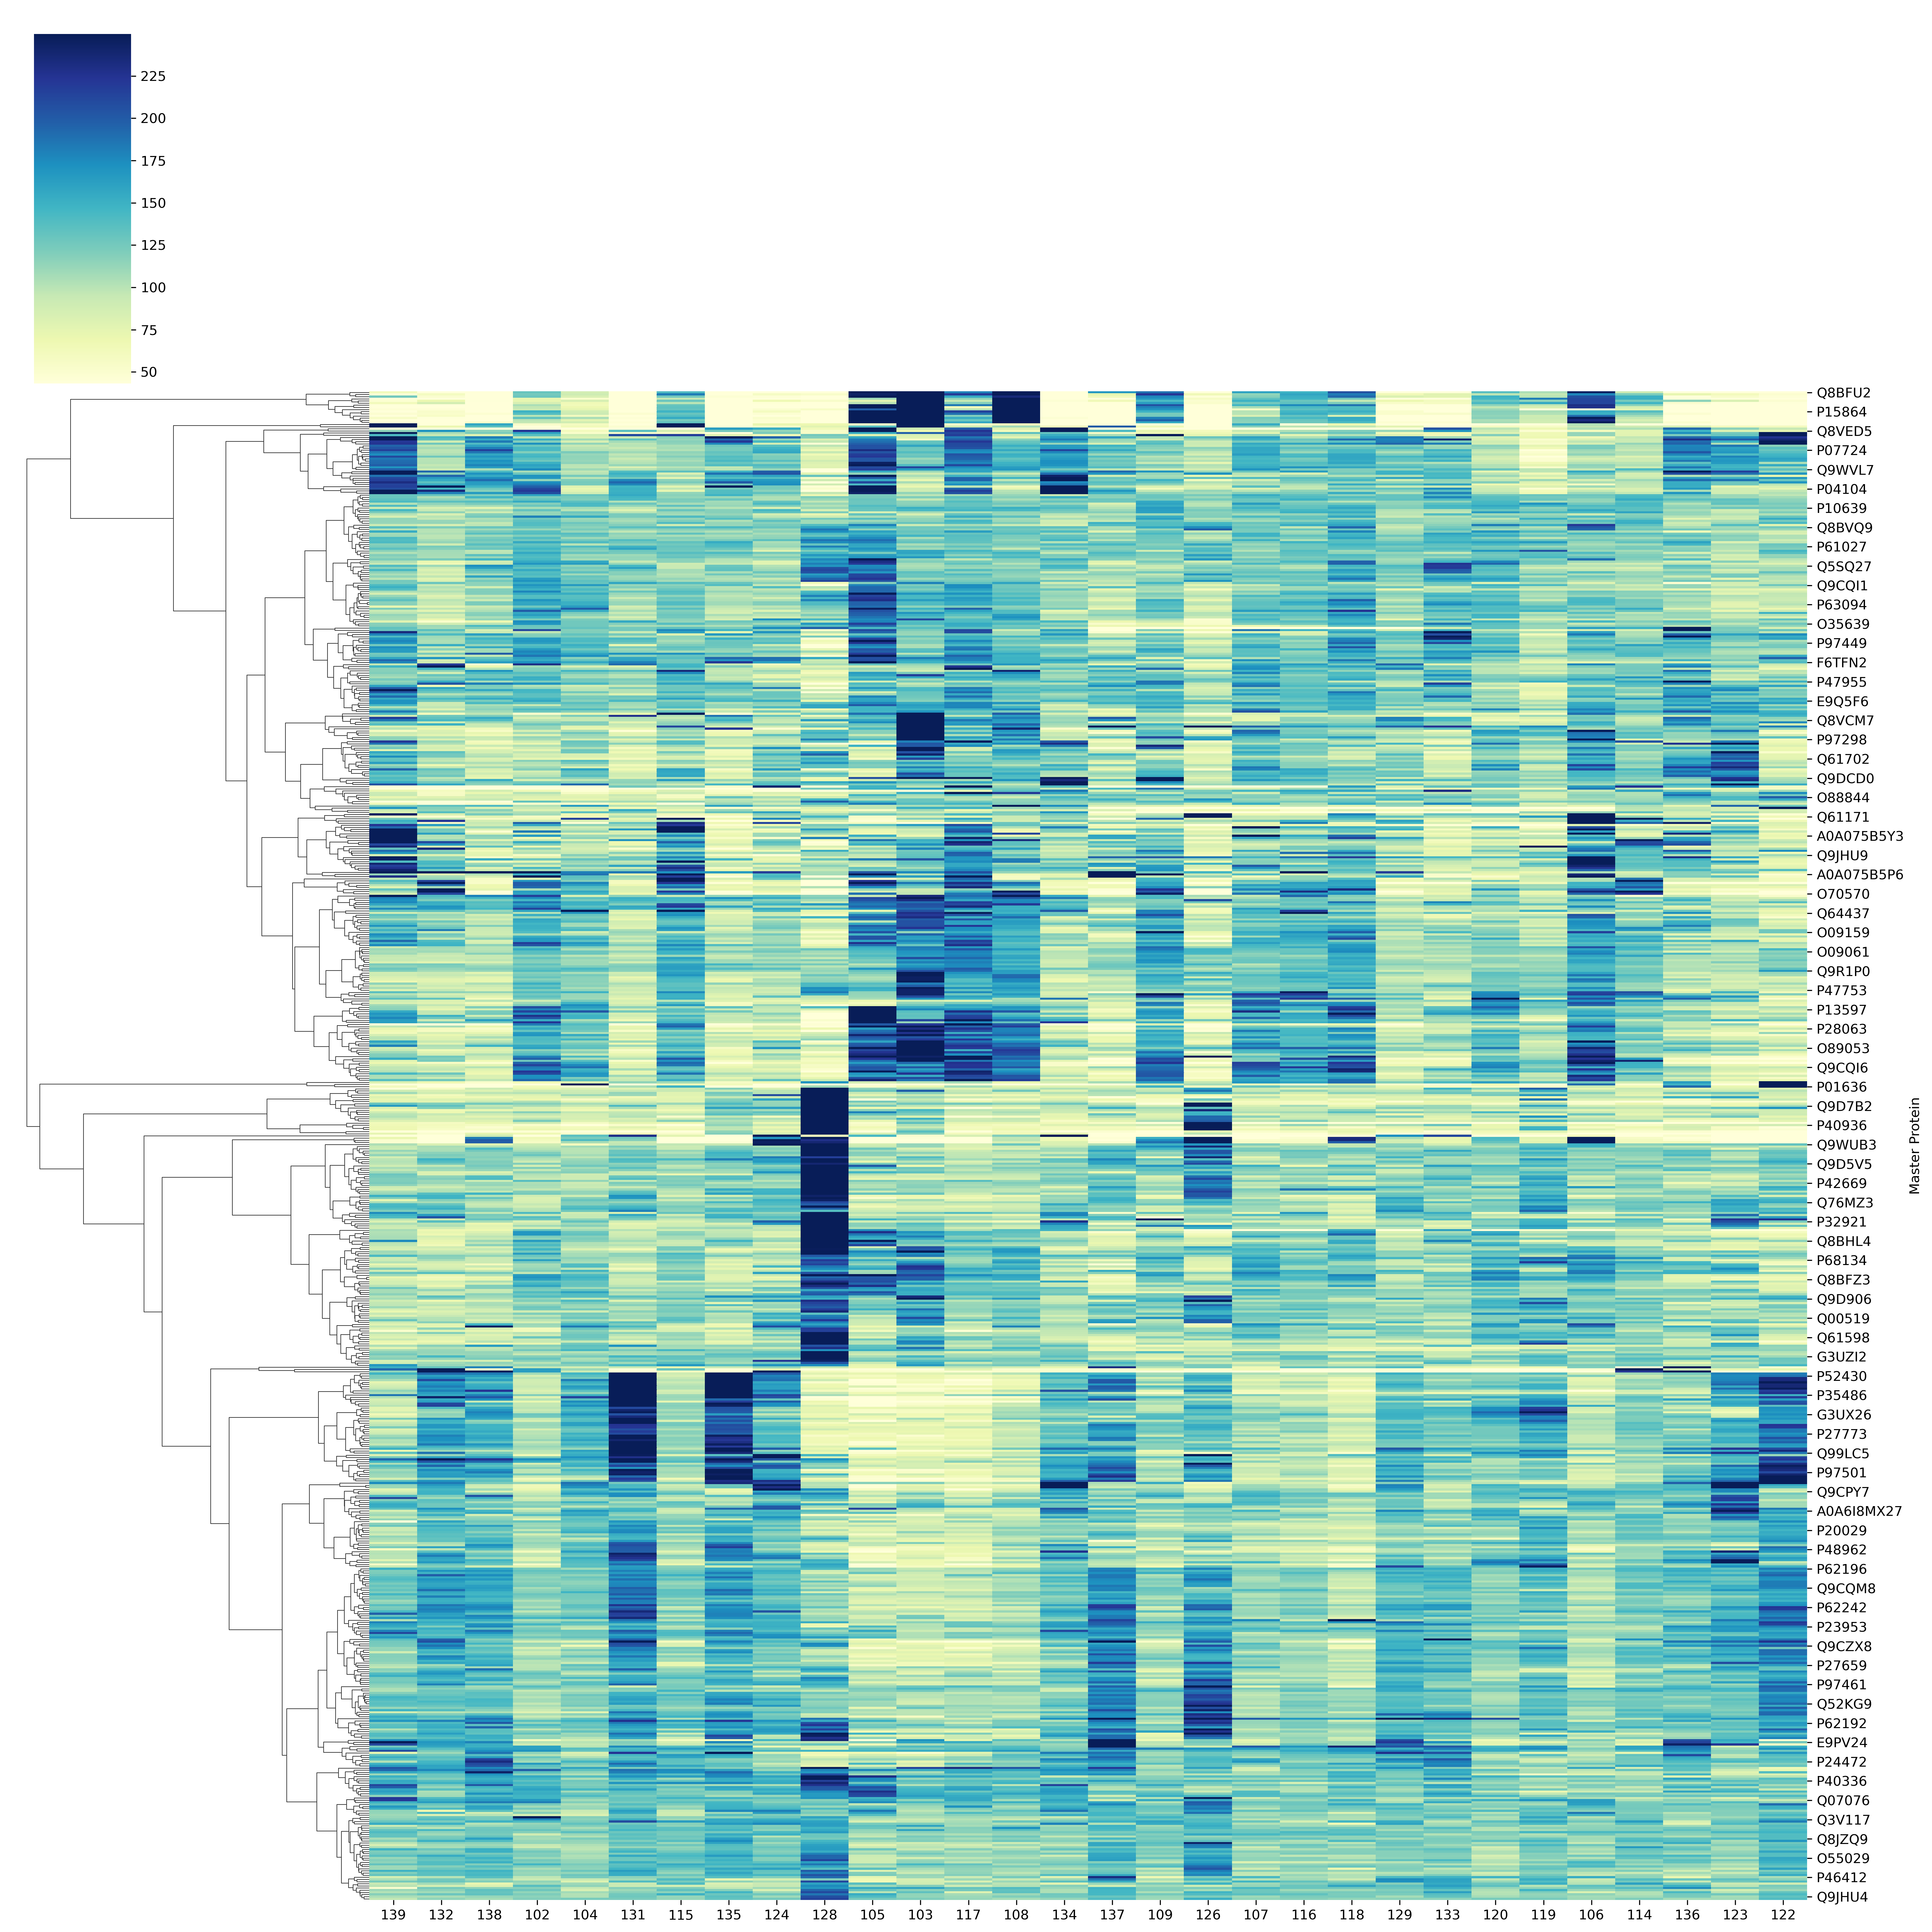

In [183]:
sns.clustermap(dfd, robust = True, cmap = "YlGnBu", method = 'ward', figsize=(20, 20), col_cluster=False, col_colors=None)

In [184]:
#Import Gene names
df2 = pd.read_excel (r'./allproteins.xlsx', index_col=0) 
df2

Proteins
Master Protein         
Q99J83             Atg5
P10417             Bcl2
O88597            Becn1
Q8K019           Bclaf1
Q8VC31            Ccdc9
...                 ...
Q61545            Ewsr1
Q3US41            Esrp1
Q80VP1             Epn1
Q78T81          Fam102a
P51880            Fabp7

[17102 rows x 1 columns]

In [185]:
#Determine the number of missing values in each sample column
Normalized_df.isnull().sum()

139    210
132    210
138    210
102    210
104    210
131    210
115    210
135    210
124    210
128    210
105    210
103    210
117    210
108    210
134    210
137    202
109    202
126    202
107    202
116    202
118    202
129    202
133    202
120    202
119    202
106    202
114    202
136    202
123    202
122    202
dtype: int64

In [186]:
#Determine the % of total missing values in each column
copydf = Normalized_df
copydf.isnull().sum()/len(copydf)

139    0.188172
132    0.188172
138    0.188172
102    0.188172
104    0.188172
131    0.188172
115    0.188172
135    0.188172
124    0.188172
128    0.188172
105    0.188172
103    0.188172
117    0.188172
108    0.188172
134    0.188172
137    0.181004
109    0.181004
126    0.181004
107    0.181004
116    0.181004
118    0.181004
129    0.181004
133    0.181004
120    0.181004
119    0.181004
106    0.181004
114    0.181004
136    0.181004
123    0.181004
122    0.181004
dtype: float64

In [187]:
#Drop all missing values from Normalized_df and assign a new name (df1)
df1 = Normalized_df.dropna()

#View missing values in df1 dataframe
df1.isnull().sum().head()

139    0
132    0
138    0
102    0
104    0
dtype: int64

In [188]:
#Use numpy to log2transform the data
df1 = np.log2(df1) #log2transforms the data
df1

139       132       138       102       104       131  \
Master Protein                                                                
A0A075B5K2       6.946804  6.615433  5.811810  5.993291  7.752379  6.195696   
A0A075B5M7       7.122029  5.940550  6.626725  5.683627  6.207868  6.191325   
A0A075B5N3       8.311375  6.840893  6.290366  6.557225  6.233539  7.417450   
A0A075B5N4      10.513669  5.405010  7.294176  5.742811  5.897884  3.549614   
A0A075B5N7       7.142490  7.147126  5.990395  6.265118  6.818141  6.612930   
...                   ...       ...       ...       ...       ...       ...   
Q9Z204           6.964942  7.293347  7.228193  7.328015  6.638839  7.450682   
Q9Z2U0           6.581404  6.516038  6.572980  6.849942  6.627711  6.448793   
Q9Z2U1           6.690987  6.606475  6.793916  6.937321  6.920346  6.691245   
S4R239           7.441130  6.580474  7.279753  7.178235  7.167309  6.938063   
W4VSP4           6.555264  6.035292  6.534317  7.398858  7.355033  6.799277   

                     115       135       124       128  ...       118  \
Master Protein                                          ...             
A0A075B5K2      8.128574  6.102325  7.475047  6.772681  ...  7.083630   
A0A075B5M7      7.950688  5.583924  6.300349  6.955180  ...  6.912170   
A0A075B5N3      7.254144  6.178642  6.928456  5.933660  ...  6.920637   
A0A075B5N4      9.308832  4.390075  6.146764  6.109547  ...  6.092421   
A0A075B5N7      8.130294  6.311169  6.271634  6.491217  ...  7.230217   
...                  ...       ...       ...       ...  ...       ...   
Q9Z204          7.119497  7.424248  6.139802  6.421037  ...  7.900068   
Q9Z2U0          6.792055  6.535073  6.826192  6.817315  ...  7.201681   
Q9Z2U1          7.142324  6.826534  7.140685  7.291208  ...  7.256030   
S4R239          7.065838  6.985614  6.870979  5.468370  ...  7.686278   
W4VSP4          6.496920  6.575379  6.257564  7.505069  ...  7.621851   

                     129       133       120       119       106       114  \
Master Protein                                                               
A0A075B5K2      6.493957  6.273730  6.220173  6.571735  8.474093  8.196012   
A0A075B5M7      6.691054  5.823109  6.198400  5.944772  7.558636  6.927891   
A0A075B5N3      6.903838  5.886791  6.203769  6.029816  7.242512  8.060542   
A0A075B5N4      4.778606  4.504901  4.590555  4.339156  6.680154  5.000849   
A0A075B5N7      6.884871  6.602233  6.426193  6.810713  8.098250  7.008911   
...                  ...       ...       ...       ...       ...       ...   
Q9Z204          7.681229  7.659866  7.160519  7.390227  6.645743  7.318691   
Q9Z2U0          6.453094  6.552726  6.599698  6.575872  7.310488  7.306227   
Q9Z2U1          6.636140  6.852767  6.843590  6.568846  7.295982  7.002098   
S4R239          6.776868  7.182783  7.163259  6.513406  7.118976  7.031072   
W4VSP4          6.864152  7.817443  7.597340  6.971712  6.547682  6.453853   

                     136       123       122  
Master Protein                                
A0A075B5K2      7.254969  6.221017  5.427131  
A0A075B5M7      7.143902  7.236791  7.264620  
A0A075B5N3      7.353620  6.643005  6.544168  
A0A075B5N4      5.353027  4.457326  4.131011  
A0A075B5N7      7.098692  7.361393  6.175781  
...                  ...       ...       ...  
Q9Z204          7.565516  6.415840  7.230018  
Q9Z2U0          6.724083  6.645041  6.849149  
Q9Z2U1          6.987029  7.382070  7.120187  
S4R239          7.208239  7.048518  6.969566  
W4VSP4          6.618216  6.412584  6.307114  

[704 rows x 30 columns]

array([[<AxesSubplot:title={'center':'139'}>,
        <AxesSubplot:title={'center':'132'}>,
        <AxesSubplot:title={'center':'138'}>,
        <AxesSubplot:title={'center':'102'}>,
        <AxesSubplot:title={'center':'104'}>],
       [<AxesSubplot:title={'center':'131'}>,
        <AxesSubplot:title={'center':'115'}>,
        <AxesSubplot:title={'center':'135'}>,
        <AxesSubplot:title={'center':'124'}>,
        <AxesSubplot:title={'center':'128'}>],
       [<AxesSubplot:title={'center':'105'}>,
        <AxesSubplot:title={'center':'103'}>,
        <AxesSubplot:title={'center':'117'}>,
        <AxesSubplot:title={'center':'108'}>,
        <AxesSubplot:title={'center':'134'}>],
       [<AxesSubplot:title={'center':'137'}>,
        <AxesSubplot:title={'center':'109'}>,
        <AxesSubplot:title={'center':'126'}>,
        <AxesSubplot:title={'center':'107'}>,
        <AxesSubplot:title={'center':'116'}>],
       [<AxesSubplot:title={'center':'118'}>,
        <AxesSubplot:title={'c

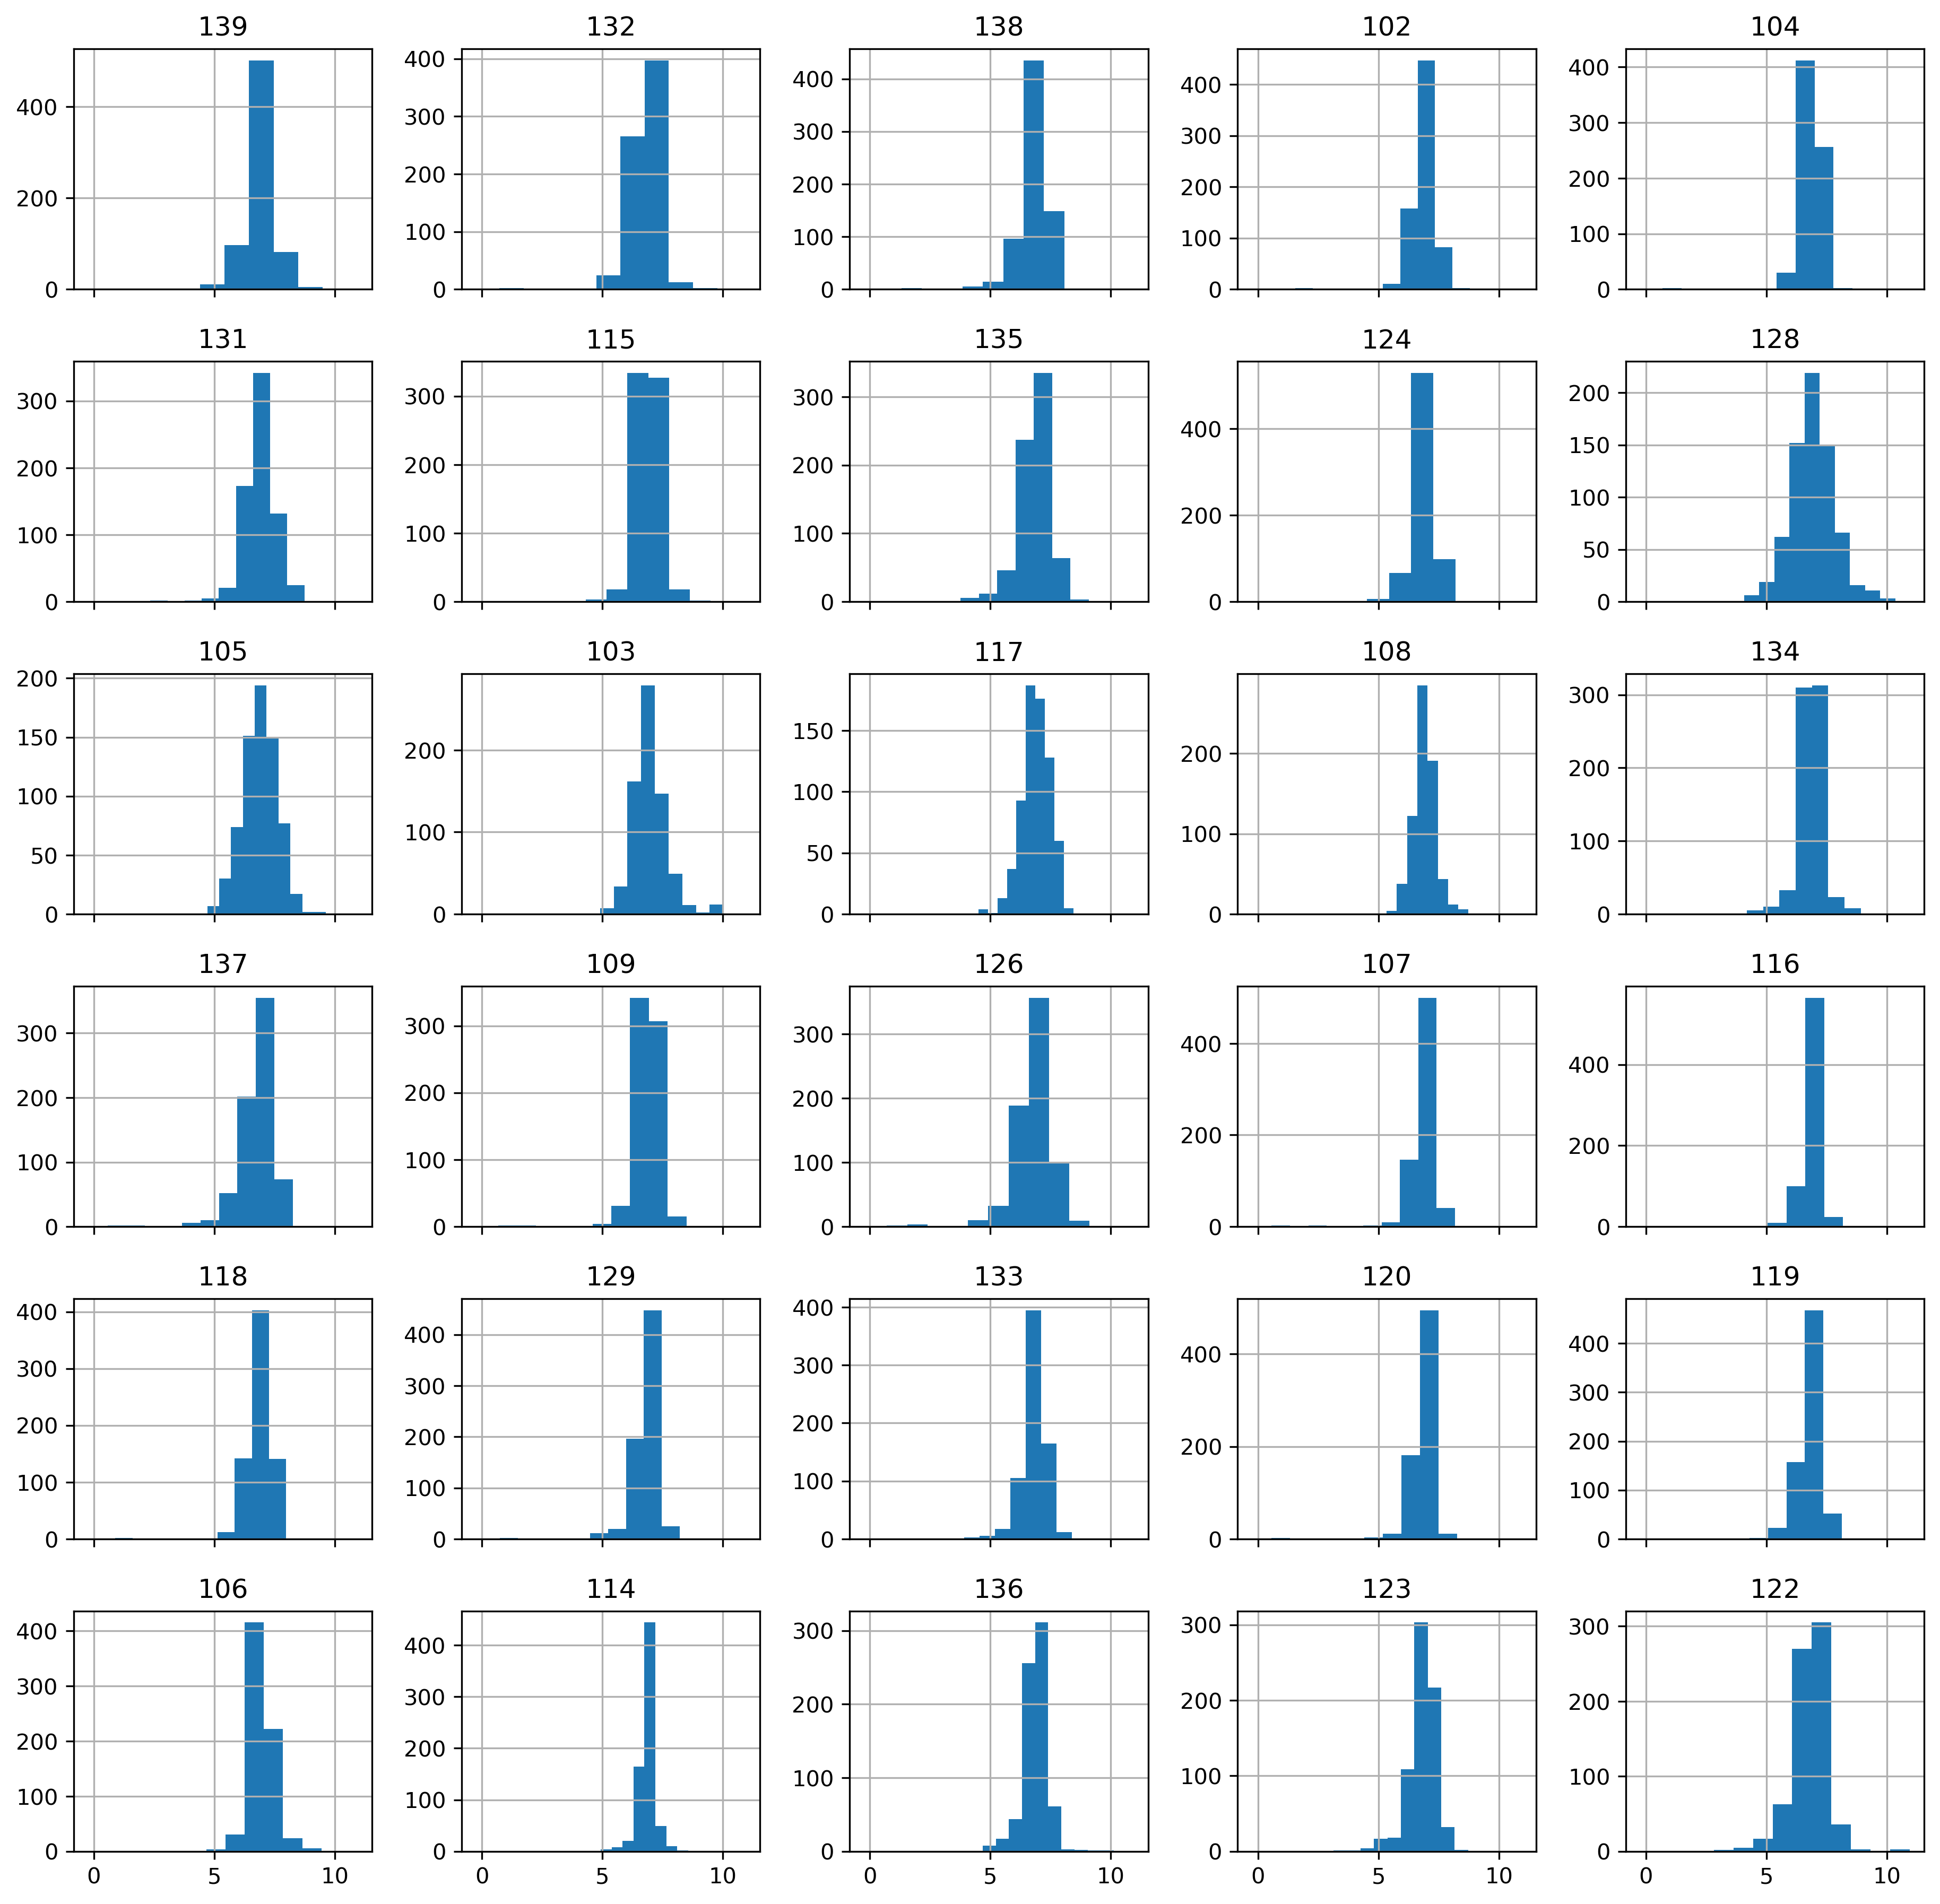

In [189]:
#View the distribution of each column
df1.hist(figsize=(15,15), sharex = True)

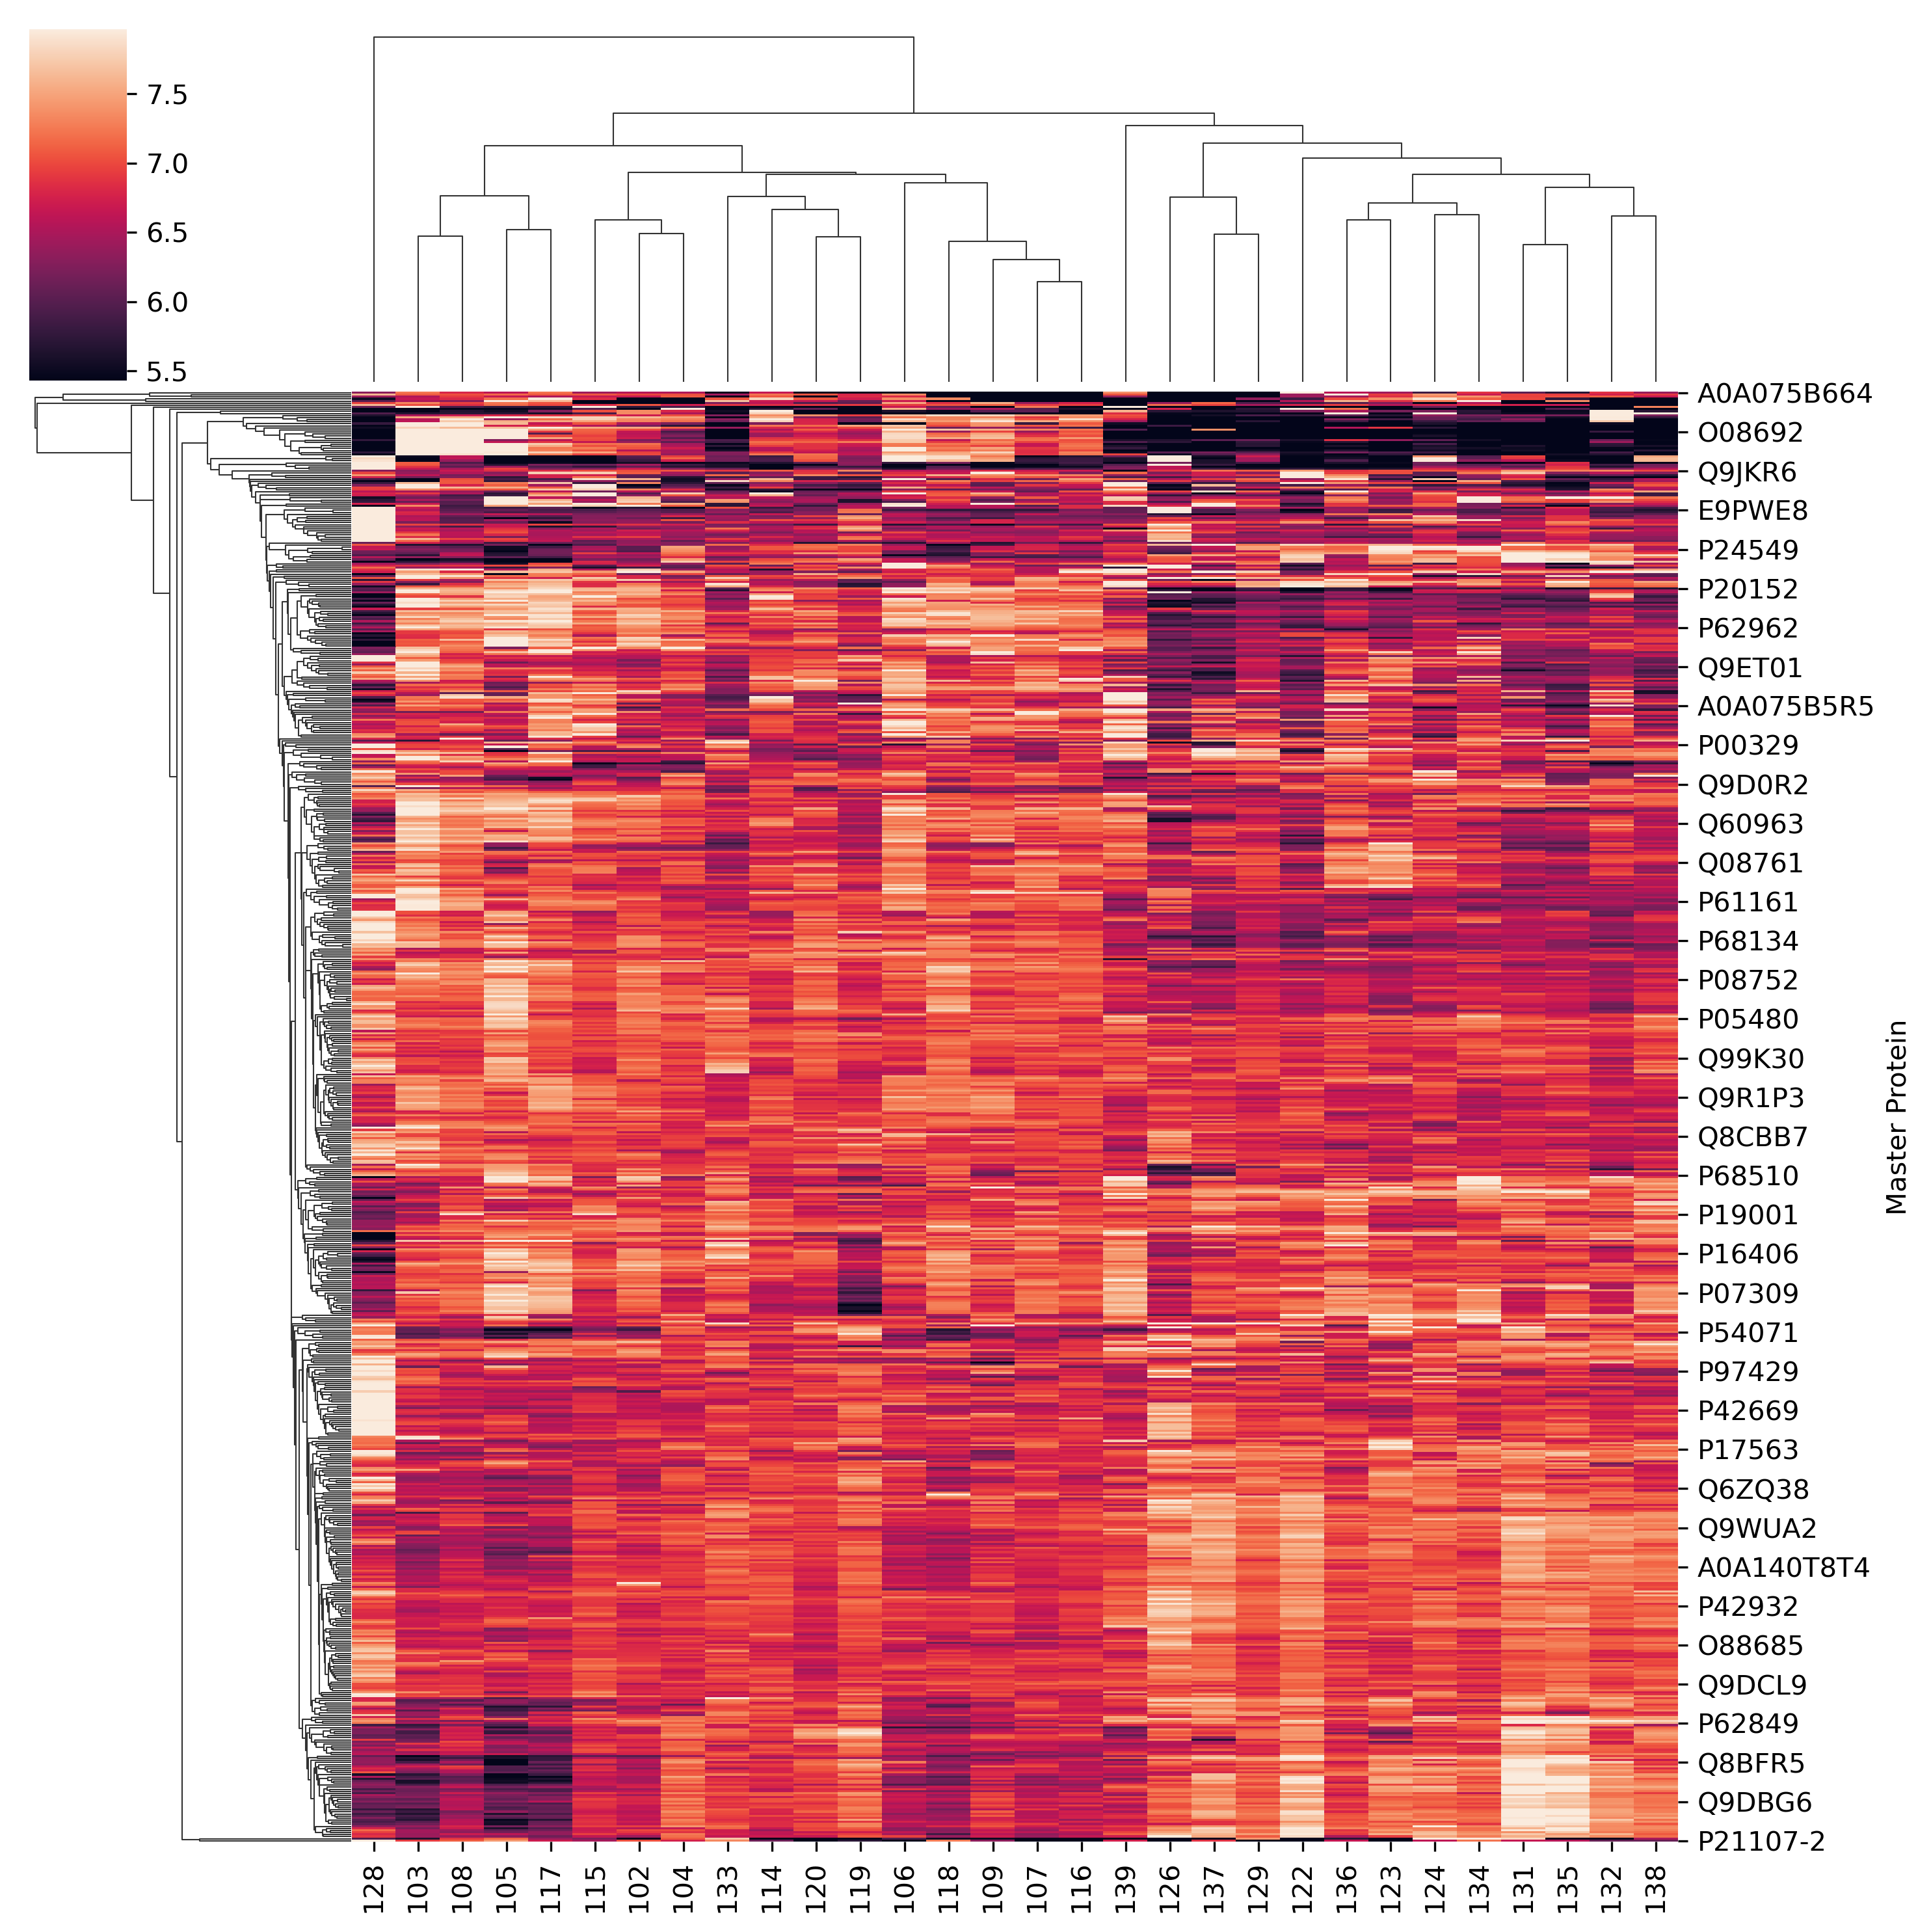

In [190]:
#Perform a mainly default settings (added robustness for better visualization) heirchical clustering analysis on the data using seaborn clustermap to look for batch effects
sns.clustermap(df1, robust = True)

In [191]:
Labels

Experiment Abundance: 126 Abundance: 127N Abundance: 127C  \
Experiment                                                             
exp1             exp1            139             132             138   
exp2             exp2            137             109             126   

           Abundance: 128N Abundance: 128C Abundance: 129N Abundance: 129C  \
Experiment                                                                   
exp1                   102             104             131             115   
exp2                   107             116             118             129   

           Abundance: 130N Abundance: 130C Abundance: 131N Abundance: 131C  \
Experiment                                                                   
exp1                   135             124             128             105   
exp2                   133             120             119             106   

           Abundance: 132N Abundance: 132C Abundance: 133N Abundance: 133C  \
Experiment                                                                   
exp1                   103             117             108             134   
exp2                   114             136             123             122   

           Abundance: 134N  
Experiment                  
exp1                    B1  
exp2                    B2

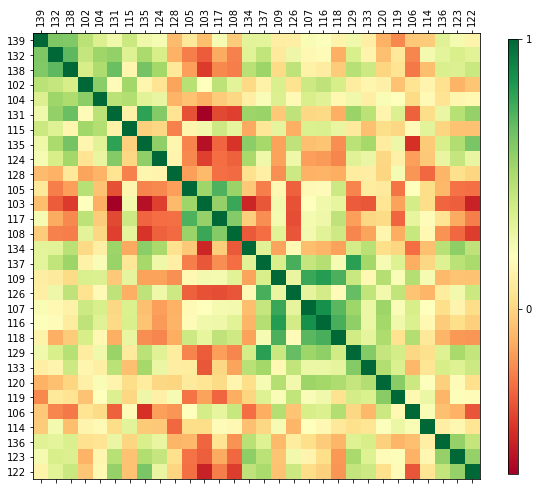

In [192]:
plot_corr(df1)

<AxesSubplot:>

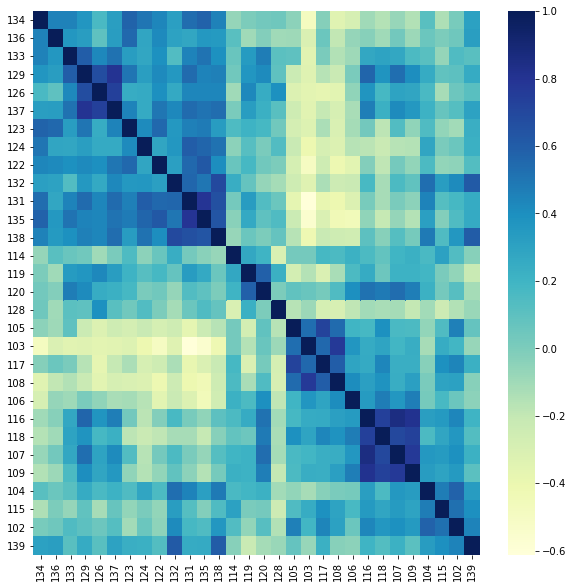

In [193]:
#sns.heatmap(df.corr()) # unclustered version
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(cluster_corr(df1.corr()), cmap='YlGnBu', ax=ax)

### At this point I opened the Normalized_df file in excel, renamed the columns with the correct groups, and saved it as an excel file (Normalized_named).

In [323]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_named.xlsx', index_col=0)
Normalized_df2.head()

Grp2      Grp2.1     Grp2.2        Grp4      Grp4.1  \
Master Protein                                                              
A0A075B5K0      156.846470  225.231942  86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104  56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672  60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621  67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN        NaN         NaN         NaN   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   

                ...      Grp3.5      Grp2.5     Grp2.6      Grp4.5     Grp4.6  \
Master Protein  ...                                                             
A0A075B5K0      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5K2      ...  135.639160   90.131332  77.371496   74.551864  95.123837   
A0A075B5K9      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L2      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L7      ...  133.142607  119.017735  86.630495  150.284217  78.427115   

                    Grp3.6      Grp4.7      Grp2.7      Grp2.8     Grp1.5  
Master Protein                                                             
A0A075B5K0             NaN         NaN         NaN         NaN        NaN  
A0A075B5K2      355.595548  293.254940  152.743678   74.595525  43.025838  
A0A075B5K9             NaN         NaN         NaN         NaN        NaN  
A0A075B5L2             NaN         NaN         NaN         NaN        NaN  
A0A075B5L7      136.159220  170.375509  160.412703  100.762541  63.119272  

[5 rows x 30 columns]

In [195]:
#Drop missing values
df2 = Normalized_df2.dropna()
df2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                                
A0A075B5K2       123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5M7       139.297789   61.416313   98.819612   51.397515   73.918719   
A0A075B5N3       317.667826  114.634174   78.268822   94.171901   75.245818   
A0A075B5N4      1461.940504   42.371130  156.951608   53.549850   59.626580   
A0A075B5N7       141.287476  141.742250   63.575324   76.911022  112.840506   
...                     ...         ...         ...         ...         ...   
Q9Z204           124.927060  156.861404  149.934941  160.676491   99.652817   
Q9Z2U0            95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1           103.320808   97.442221  110.961522  122.557996  121.124421   
S4R239           173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4            94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A075B5K2       73.297693  279.862419   68.704155  177.915272  109.340257   
A0A075B5M7       73.075985  247.397569   47.965474   78.812297  124.084596   
A0A075B5N3      170.952308  152.656321   72.436329  121.807195   61.123687   
A0A075B5N4       11.709551  634.216827   20.967391   70.853338   69.048912   
A0A075B5N7       97.879156  280.196299   79.405624   77.259182   89.960353   
...                    ...         ...         ...         ...         ...   
Q9Z204          174.935877  139.053556  171.759758   70.512239   85.688920   
Q9Z2U0           87.353437  110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252  141.271226  113.498894  141.110834  156.629045   
S4R239          122.621058  133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674   90.316628   95.364378   76.509363  181.656526   

                ...      Grp3.5      Grp2.5      Grp2.6      Grp4.5  \
Master Protein  ...                                                   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5M7      ...  120.439941  103.325596   56.614864   73.435216   
A0A075B5N3      ...  121.148842  119.746401   59.169868   73.708986   
A0A075B5N4      ...   68.234087   27.447552   22.704408   24.093212   
A0A075B5N7      ...  150.145411  118.182399   97.156130   85.995741   
...             ...         ...         ...         ...         ...   
Q9Z204          ...  238.867699  205.248649  202.231829  143.064213   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581559  114.848648   
S4R239          ...  205.968231  109.658089  145.289108  143.336170   
W4VSP4          ...  196.972559  116.497244  225.571851  193.654322   

                    Grp4.6      Grp3.6      Grp4.7      Grp2.7      Grp2.8  \
Master Protein                                                               
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5M7       61.596304  188.528107  121.759500  141.425800  150.831145   
A0A075B5N3       65.336425  151.430475  266.971523  163.553678   99.941049   
A0A075B5N4       20.240260  102.547922   32.018834   40.871605   21.967920   
A0A075B5N7      112.260978  274.041404  128.793029  137.062648  164.437155   
...                    ...         ...         ...         ...         ...   
Q9Z204          167.756712  100.130894  159.641377  189.429335   85.380830   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                    Grp1.5  
Master Prote

In [196]:
#Use numpy to log2transform the data
df22 = np.log2(df2) #log2transforms the data
df22

Grp2    Grp2.1    Grp2.2      Grp4    Grp4.1    Grp2.3  \
Master Protein                                                                
A0A075B5K2       6.946804  6.615433  5.811810  5.993291  7.752379  6.195696   
A0A075B5M7       7.122029  5.940550  6.626725  5.683627  6.207868  6.191325   
A0A075B5N3       8.311375  6.840893  6.290366  6.557225  6.233539  7.417450   
A0A075B5N4      10.513669  5.405010  7.294176  5.742811  5.897884  3.549614   
A0A075B5N7       7.142490  7.147126  5.990395  6.265118  6.818141  6.612930   
...                   ...       ...       ...       ...       ...       ...   
Q9Z204           6.964942  7.293347  7.228193  7.328015  6.638839  7.450682   
Q9Z2U0           6.581404  6.516038  6.572980  6.849942  6.627711  6.448793   
Q9Z2U1           6.690987  6.606475  6.793916  6.937321  6.920346  6.691245   
S4R239           7.441130  6.580474  7.279753  7.178235  7.167309  6.938063   
W4VSP4           6.555264  6.035292  6.534317  7.398858  7.355033  6.799277   

                    Grp3    Grp2.4      Grp1    Grp1.1  ...    Grp3.5  \
Master Protein                                          ...             
A0A075B5K2      8.128574  6.102325  7.475047  6.772681  ...  7.083630   
A0A075B5M7      7.950688  5.583924  6.300349  6.955180  ...  6.912170   
A0A075B5N3      7.254144  6.178642  6.928456  5.933660  ...  6.920637   
A0A075B5N4      9.308832  4.390075  6.146764  6.109547  ...  6.092421   
A0A075B5N7      8.130294  6.311169  6.271634  6.491217  ...  7.230217   
...                  ...       ...       ...       ...  ...       ...   
Q9Z204          7.119497  7.424248  6.139802  6.421037  ...  7.900068   
Q9Z2U0          6.792055  6.535073  6.826192  6.817315  ...  7.201681   
Q9Z2U1          7.142324  6.826534  7.140685  7.291208  ...  7.256030   
S4R239          7.065838  6.985614  6.870979  5.468370  ...  7.686278   
W4VSP4          6.496920  6.575379  6.257564  7.505069  ...  7.621851   

                  Grp2.5    Grp2.6    Grp4.5    Grp4.6    Grp3.6    Grp4.7  \
Master Protein                                                               
A0A075B5K2      6.493957  6.273730  6.220173  6.571735  8.474093  8.196012   
A0A075B5M7      6.691054  5.823109  6.198400  5.944772  7.558636  6.927891   
A0A075B5N3      6.903838  5.886791  6.203769  6.029816  7.242512  8.060542   
A0A075B5N4      4.778606  4.504901  4.590555  4.339156  6.680154  5.000849   
A0A075B5N7      6.884871  6.602233  6.426193  6.810713  8.098250  7.008911   
...                  ...       ...       ...       ...       ...       ...   
Q9Z204          7.681229  7.659866  7.160519  7.390227  6.645743  7.318691   
Q9Z2U0          6.453094  6.552726  6.599698  6.575872  7.310488  7.306227   
Q9Z2U1          6.636140  6.852767  6.843590  6.568846  7.295982  7.002098   
S4R239          6.776868  7.182783  7.163259  6.513406  7.118976  7.031072   
W4VSP4          6.864152  7.817443  7.597340  6.971712  6.547682  6.453853   

                  Grp2.7    Grp2.8    Grp1.5  
Master Protein                                
A0A075B5K2      7.254969  6.221017  5.427131  
A0A075B5M7      7.143902  7.236791  7.264620  
A0A075B5N3      7.353620  6.643005  6.544168  
A0A075B5N4      5.353027  4.457326  4.131011  
A0A075B5N7      7.098692  7.361393  6.175781  
...                  ...       ...       ...  
Q9Z204          7.565516  6.415840  7.230018  
Q9Z2U0          6.724083  6.645041  6.849149  
Q9Z2U1          6.987029  7.382070  7.120187  
S4R239          7.208239  7.048518  6.969566  
W4VSP4          6.618216  6.412584  6.307114  

[704 rows x 30 columns]

<AxesSubplot:>

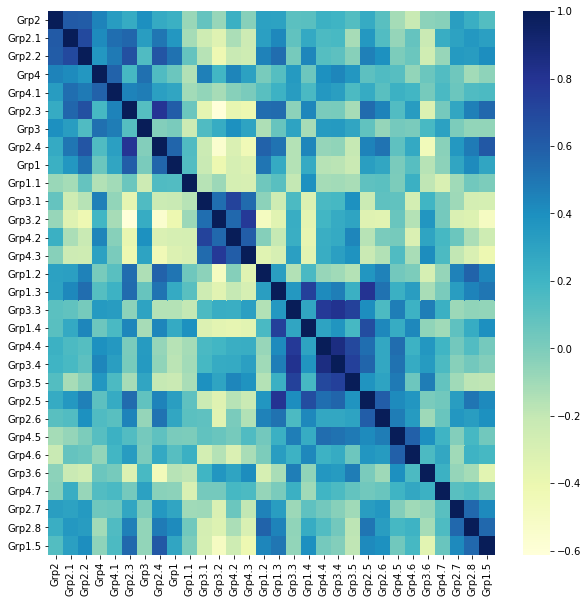

In [197]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df22.corr(), cmap='YlGnBu', ax=ax) # unclustered version

<AxesSubplot:>

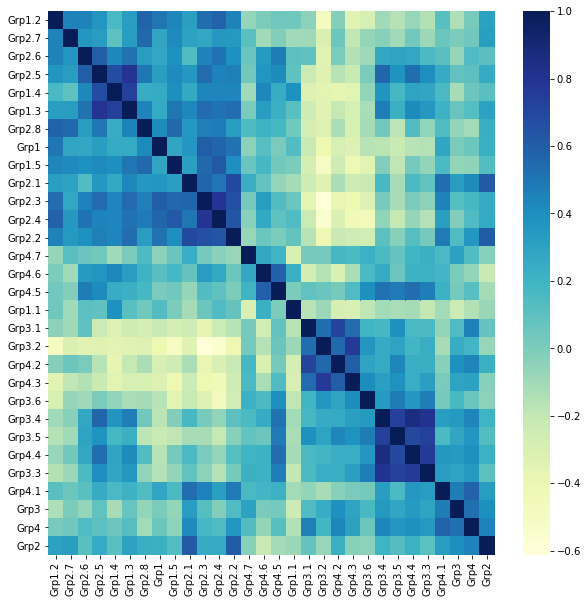

In [198]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(cluster_corr(df22.corr()), cmap='YlGnBu', ax=ax)

In [199]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df22.reset_index(), id_vars=['Master Protein'], value_vars=['Grp1', 'Grp2', 'Grp3', 'Grp4'])
# replace column names
df_melt.columns = ['index', 'group', 'value']
df_melt

index group     value
0     A0A075B5K2  Grp1  7.475047
1     A0A075B5M7  Grp1  6.300349
2     A0A075B5N3  Grp1  6.928456
3     A0A075B5N4  Grp1  6.146764
4     A0A075B5N7  Grp1  6.271634
...          ...   ...       ...
2811      Q9Z204  Grp4  7.328015
2812      Q9Z2U0  Grp4  6.849942
2813      Q9Z2U1  Grp4  6.937321
2814      S4R239  Grp4  7.178235
2815      W4VSP4  Grp4  7.398858

[2816 rows x 3 columns]

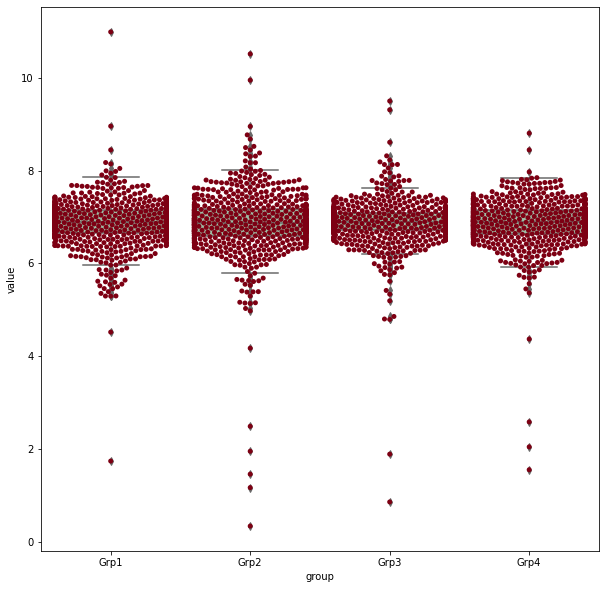

In [200]:
# generate a boxplot to see the data distribution
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='group', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="group", y="value", data=df_melt, color='#7d0013')
plt.show()

In [201]:
# ANOVA table using bioinfokit v1.0.3 or later 
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(group)')
res.anova_summary
# output (ANOVA F and p value)

df      sum_sq   mean_sq         F    PR(>F)
C(group)     3.0    0.298667  0.099556  0.293241  0.830314
Residual  2812.0  954.679241  0.339502       NaN       NaN

In [202]:
# perform multiple pairwise comparison (Tukey's HSD)
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='group', anova_model='value ~ C(group)')
res.tukey_summary

group1 group2      Diff     Lower     Upper   q-value   p-value
0   Grp1   Grp2  0.011721 -0.068112  0.091553  0.533729  0.900000
1   Grp1   Grp3  0.013957 -0.065876  0.093789  0.635550  0.900000
2   Grp1   Grp4  0.010435 -0.069398  0.090267  0.475160  0.900000
3   Grp2   Grp3  0.025678 -0.054155  0.105510  1.169279  0.821095
4   Grp2   Grp4  0.001286 -0.078546  0.081118  0.058569  0.900000
5   Grp3   Grp4  0.024391 -0.055441  0.104224  1.110710  0.844335

In [203]:
df22.columns = ['Grp2','Grp2','Grp2','Grp4','Grp4','Grp2','Grp3','Grp2','Grp1','Grp1','Grp3','Grp3','Grp4','Grp4','Grp1','Grp1','Grp3','Grp1','Grp4','Grp3','Grp3','Grp2','Grp2','Grp4','Grp4','Grp3','Grp4','Grp2','Grp2','Grp1']
df22

Grp2      Grp2      Grp2      Grp4      Grp4      Grp2  \
Master Protein                                                                
A0A075B5K2       6.946804  6.615433  5.811810  5.993291  7.752379  6.195696   
A0A075B5M7       7.122029  5.940550  6.626725  5.683627  6.207868  6.191325   
A0A075B5N3       8.311375  6.840893  6.290366  6.557225  6.233539  7.417450   
A0A075B5N4      10.513669  5.405010  7.294176  5.742811  5.897884  3.549614   
A0A075B5N7       7.142490  7.147126  5.990395  6.265118  6.818141  6.612930   
...                   ...       ...       ...       ...       ...       ...   
Q9Z204           6.964942  7.293347  7.228193  7.328015  6.638839  7.450682   
Q9Z2U0           6.581404  6.516038  6.572980  6.849942  6.627711  6.448793   
Q9Z2U1           6.690987  6.606475  6.793916  6.937321  6.920346  6.691245   
S4R239           7.441130  6.580474  7.279753  7.178235  7.167309  6.938063   
W4VSP4           6.555264  6.035292  6.534317  7.398858  7.355033  6.799277   

                    Grp3      Grp2      Grp1      Grp1  ...      Grp3  \
Master Protein                                          ...             
A0A075B5K2      8.128574  6.102325  7.475047  6.772681  ...  7.083630   
A0A075B5M7      7.950688  5.583924  6.300349  6.955180  ...  6.912170   
A0A075B5N3      7.254144  6.178642  6.928456  5.933660  ...  6.920637   
A0A075B5N4      9.308832  4.390075  6.146764  6.109547  ...  6.092421   
A0A075B5N7      8.130294  6.311169  6.271634  6.491217  ...  7.230217   
...                  ...       ...       ...       ...  ...       ...   
Q9Z204          7.119497  7.424248  6.139802  6.421037  ...  7.900068   
Q9Z2U0          6.792055  6.535073  6.826192  6.817315  ...  7.201681   
Q9Z2U1          7.142324  6.826534  7.140685  7.291208  ...  7.256030   
S4R239          7.065838  6.985614  6.870979  5.468370  ...  7.686278   
W4VSP4          6.496920  6.575379  6.257564  7.505069  ...  7.621851   

                    Grp2      Grp2      Grp4      Grp4      Grp3      Grp4  \
Master Protein                                                               
A0A075B5K2      6.493957  6.273730  6.220173  6.571735  8.474093  8.196012   
A0A075B5M7      6.691054  5.823109  6.198400  5.944772  7.558636  6.927891   
A0A075B5N3      6.903838  5.886791  6.203769  6.029816  7.242512  8.060542   
A0A075B5N4      4.778606  4.504901  4.590555  4.339156  6.680154  5.000849   
A0A075B5N7      6.884871  6.602233  6.426193  6.810713  8.098250  7.008911   
...                  ...       ...       ...       ...       ...       ...   
Q9Z204          7.681229  7.659866  7.160519  7.390227  6.645743  7.318691   
Q9Z2U0          6.453094  6.552726  6.599698  6.575872  7.310488  7.306227   
Q9Z2U1          6.636140  6.852767  6.843590  6.568846  7.295982  7.002098   
S4R239          6.776868  7.182783  7.163259  6.513406  7.118976  7.031072   
W4VSP4          6.864152  7.817443  7.597340  6.971712  6.547682  6.453853   

                    Grp2      Grp2      Grp1  
Master Protein                                
A0A075B5K2      7.254969  6.221017  5.427131  
A0A075B5M7      7.143902  7.236791  7.264620  
A0A075B5N3      7.353620  6.643005  6.544168  
A0A075B5N4      5.353027  4.457326  4.131011  
A0A075B5N7      7.098692  7.361393  6.175781  
...                  ...       ...       ...  
Q9Z204          7.565516  6.415840  7.230018  
Q9Z2U0          6.724083  6.645041  6.849149  
Q9Z2U1          6.987029  7.382070  7.120187  
S4R239          7.208239  7.048518  6.969566  
W4VSP4          6.618216  6.412584  6.307114  

[704 rows x 30 columns]

In [204]:
#transpose the data and reset index
dfidgroup = df22.transpose()
dfidgroup2 = dfidgroup.reset_index()
dfidgroup2

Master Protein index  A0A075B5K2  A0A075B5M7  A0A075B5N3  A0A075B5N4  \
0               Grp2    6.946804    7.122029    8.311375   10.513669   
1               Grp2    6.615433    5.940550    6.840893    5.405010   
2               Grp2    5.811810    6.626725    6.290366    7.294176   
3               Grp4    5.993291    5.683627    6.557225    5.742811   
4               Grp4    7.752379    6.207868    6.233539    5.897884   
5               Grp2    6.195696    6.191325    7.417450    3.549614   
6               Grp3    8.128574    7.950688    7.254144    9.308832   
7               Grp2    6.102325    5.583924    6.178642    4.390075   
8               Grp1    7.475047    6.300349    6.928456    6.146764   
9               Grp1    6.772681    6.955180    5.933660    6.109547   
10              Grp3    5.721060    7.563191    7.553211    5.760598   
11              Grp3    6.903881    8.339681    7.246847    7.999628   
12              Grp4    7.291136    7.092180    7.398205    5.727438   
13              Grp4    6.511178    7.627411    7.878032    5.917519   
14              Grp1    6.738375    6.391041    6.857725    4.823732   
15              Grp1    4.947139    6.041379    6.521510    4.958316   
16              Grp3    7.582773    6.606106    7.070720    4.959251   
17              Grp1    6.352775    5.622408    6.454735    4.329069   
18              Grp4    6.560916    6.393719    6.883950    7.257016   
19              Grp3    6.554601    6.571716    6.745372    5.125402   
20              Grp3    7.083630    6.912170    6.920637    6.092421   
21              Grp2    6.493957    6.691054    6.903838    4.778606   
22              Grp2    6.273730    5.823109    5.886791    4.504901   
23              Grp4    6.220173    6.198400    6.203769    4.590555   
24              Grp4    6.571735    5.944772    6.029816    4.339156   
25              Grp3    8.474093    7.558636    7.242512    6.680154   
26              Grp4    8.196012    6.927891    8.060542    5.000849   
27              Grp2    7.254969    7.143902    7.353620    5.353027   
28              Grp2    6.221017    7.236791    6.643005    4.457326   
29              Grp1    5.427131    7.264620    6.544168    4.131011   

Master Protein  A0A075B5N7  A0A075B5P6  A0A075B5Q3  A0A075B5R0  A0A075B5R2  \
0                 7.142490    6.822322    7.794693    5.161093    1.950588   
1                 7.147126    6.301997    6.796757    4.847443    1.332952   
2                 5.990395    6.683076    5.944445    5.057609    2.077285   
3                 6.265118    7.251170    6.471004    4.368405    2.044918   
4                 6.818141    7.551027    7.021318    8.578160    1.170080   
5                 6.612930    6.105230    6.561692    4.605689    6.989031   
6                 8.130294    8.054150    7.102804    5.992635    6.839617   
7                 6.311169    5.927086    6.458628    5.976713    5.741861   
8                 6.271634    7.126517    6.564587    4.517766    7.904673   
9                 6.491217    6.743512    7.066420    4.928384    5.546061   
10                6.725114    8.052375    6.182348    4.714252    7.203835   
11                7.053253    6.679581    7.499239    4.335694    6.651196   
12                7.451524    7.477734    7.953208    5.542925    8.120260   
13                7.522980    6.008477    7.222899    4.913725    6.813742   
14                6.703533    6.201424    7.657556    5.465890    7.108021   
15                6.539709    7.969993    5.937964    5.359711    2.104614   
16                7.133136    8.062315    6.821135    6.518985    2.210177   
17                6.165442    6.562803    5.770257    6.748235    2.229689   
18                6.875860    7.125123    6.945738    5.977516    2.090473   
19                6.929611    6.329028    6.760905    5.626282    1.853432   
20                7.230217    6.722577    6.602908    6.411670    7.350101   
21                6.884871    6.810253    6.476839 

In [205]:
#Assign unique numbers based upon the genotype column
dfidgroup2['group'] = dfidgroup2.groupby(['index']).ngroup()
dfidgroup2

Master Protein index  A0A075B5K2  A0A075B5M7  A0A075B5N3  A0A075B5N4  \
0               Grp2    6.946804    7.122029    8.311375   10.513669   
1               Grp2    6.615433    5.940550    6.840893    5.405010   
2               Grp2    5.811810    6.626725    6.290366    7.294176   
3               Grp4    5.993291    5.683627    6.557225    5.742811   
4               Grp4    7.752379    6.207868    6.233539    5.897884   
5               Grp2    6.195696    6.191325    7.417450    3.549614   
6               Grp3    8.128574    7.950688    7.254144    9.308832   
7               Grp2    6.102325    5.583924    6.178642    4.390075   
8               Grp1    7.475047    6.300349    6.928456    6.146764   
9               Grp1    6.772681    6.955180    5.933660    6.109547   
10              Grp3    5.721060    7.563191    7.553211    5.760598   
11              Grp3    6.903881    8.339681    7.246847    7.999628   
12              Grp4    7.291136    7.092180    7.398205    5.727438   
13              Grp4    6.511178    7.627411    7.878032    5.917519   
14              Grp1    6.738375    6.391041    6.857725    4.823732   
15              Grp1    4.947139    6.041379    6.521510    4.958316   
16              Grp3    7.582773    6.606106    7.070720    4.959251   
17              Grp1    6.352775    5.622408    6.454735    4.329069   
18              Grp4    6.560916    6.393719    6.883950    7.257016   
19              Grp3    6.554601    6.571716    6.745372    5.125402   
20              Grp3    7.083630    6.912170    6.920637    6.092421   
21              Grp2    6.493957    6.691054    6.903838    4.778606   
22              Grp2    6.273730    5.823109    5.886791    4.504901   
23              Grp4    6.220173    6.198400    6.203769    4.590555   
24              Grp4    6.571735    5.944772    6.029816    4.339156   
25              Grp3    8.474093    7.558636    7.242512    6.680154   
26              Grp4    8.196012    6.927891    8.060542    5.000849   
27              Grp2    7.254969    7.143902    7.353620    5.353027   
28              Grp2    6.221017    7.236791    6.643005    4.457326   
29              Grp1    5.427131    7.264620    6.544168    4.131011   

Master Protein  A0A075B5N7  A0A075B5P6  A0A075B5Q3  A0A075B5R0  A0A075B5R2  \
0                 7.142490    6.822322    7.794693    5.161093    1.950588   
1                 7.147126    6.301997    6.796757    4.847443    1.332952   
2                 5.990395    6.683076    5.944445    5.057609    2.077285   
3                 6.265118    7.251170    6.471004    4.368405    2.044918   
4                 6.818141    7.551027    7.021318    8.578160    1.170080   
5                 6.612930    6.105230    6.561692    4.605689    6.989031   
6                 8.130294    8.054150    7.102804    5.992635    6.839617   
7                 6.311169    5.927086    6.458628    5.976713    5.741861   
8                 6.271634    7.126517    6.564587    4.517766    7.904673   
9                 6.491217    6.743512    7.066420    4.928384    5.546061   
10                6.725114    8.052375    6.182348    4.714252    7.203835   
11                7.053253    6.679581    7.499239    4.335694    6.651196   
12                7.451524    7.477734    7.953208    5.542925    8.120260   
13                7.522980    6.008477    7.222899    4.913725    6.813742   
14                6.703533    6.201424    7.657556    5.465890    7.108021   
15                6.539709    7.969993    5.937964    5.359711    2.104614   
16                7.133136    8.062315    6.821135    6.518985    2.210177   
17                6.165442    6.562803    5.770257    6.748235    2.229689   
18                6.875860    7.125123    6.945738    5.977516    2.090473   
19                6.929611    6.329028    6.760905    5.626282    1.853432   
20                7.230217    6.722577    6.602908    6.411670    7.350101   
21                6.884871    6.810253    6.476839 

In [206]:
#set the index
dfidgroups = dfidgroup2.set_index('index')
dfidgroups

Master Protein  A0A075B5K2  A0A075B5M7  A0A075B5N3  A0A075B5N4  A0A075B5N7  \
index                                                                        
Grp2              6.946804    7.122029    8.311375   10.513669    7.142490   
Grp2              6.615433    5.940550    6.840893    5.405010    7.147126   
Grp2              5.811810    6.626725    6.290366    7.294176    5.990395   
Grp4              5.993291    5.683627    6.557225    5.742811    6.265118   
Grp4              7.752379    6.207868    6.233539    5.897884    6.818141   
Grp2              6.195696    6.191325    7.417450    3.549614    6.612930   
Grp3              8.128574    7.950688    7.254144    9.308832    8.130294   
Grp2              6.102325    5.583924    6.178642    4.390075    6.311169   
Grp1              7.475047    6.300349    6.928456    6.146764    6.271634   
Grp1              6.772681    6.955180    5.933660    6.109547    6.491217   
Grp3              5.721060    7.563191    7.553211    5.760598    6.725114   
Grp3              6.903881    8.339681    7.246847    7.999628    7.053253   
Grp4              7.291136    7.092180    7.398205    5.727438    7.451524   
Grp4              6.511178    7.627411    7.878032    5.917519    7.522980   
Grp1              6.738375    6.391041    6.857725    4.823732    6.703533   
Grp1              4.947139    6.041379    6.521510    4.958316    6.539709   
Grp3              7.582773    6.606106    7.070720    4.959251    7.133136   
Grp1              6.352775    5.622408    6.454735    4.329069    6.165442   
Grp4              6.560916    6.393719    6.883950    7.257016    6.875860   
Grp3              6.554601    6.571716    6.745372    5.125402    6.929611   
Grp3              7.083630    6.912170    6.920637    6.092421    7.230217   
Grp2              6.493957    6.691054    6.903838    4.778606    6.884871   
Grp2              6.273730    5.823109    5.886791    4.504901    6.602233   
Grp4              6.220173    6.198400    6.203769    4.590555    6.426193   
Grp4              6.571735    5.944772    6.029816    4.339156    6.810713   
Grp3              8.474093    7.558636    7.242512    6.680154    8.098250   
Grp4              8.196012    6.927891    8.060542    5.000849    7.008911   
Grp2              7.254969    7.143902    7.353620    5.353027    7.098692   
Grp2              6.221017    7.236791    6.643005    4.457326    7.361393   
Grp1              5.427131    7.264620    6.544168    4.131011    6.175781   

Master Protein  A0A075B5P6  A0A075B5Q3  A0A075B5R0  A0A075B5R2  A0A075B5R5  \
index                                                                        
Grp2              6.822322    7.794693    5.161093    1.950588    7.037940   
Grp2              6.301997    6.796757    4.847443    1.332952    7.868450   
Grp2              6.683076    5.944445    5.057609    2.077285    6.205279   
Grp4              7.251170    6.471004    4.368405    2.044918    6.850985   
Grp4              7.551027    7.021318    8.578160    1.170080    6.402411   
Grp2              6.105230    6.561692    4.605689    6.989031    5.716422   
Grp3              8.054150    7.102804    5.992635    6.839617    6.908956   
Grp2              5.927086    6.458628    5.976713    5.741861    5.507286   
Grp1              7.126517    6.564587    4.517766    7.904673    6.561876   
Grp1              6.743512    7.066420    4.928384    5.546061    5.955694   
Grp3              8.052375    6.182348    4.714252    7.203835    6.814931   
Grp3              6.679581    7.499239    4.335694    6.651196    7.483375   
Grp4              7.477734    7.953208    5.542925    8.120260    7.162882   
Grp4              6.008477    7.222899    4.913725    6.813742    7.324685   
Grp1              6.201424    7.657556    5.465890    7.108021    6.580663   
Grp1              7.969993    5.937964    5.359711    2.104614    6.408994   
Grp3              8.062315    6.821135    6.518985    2.210177    6.936640   
Grp1              6.5

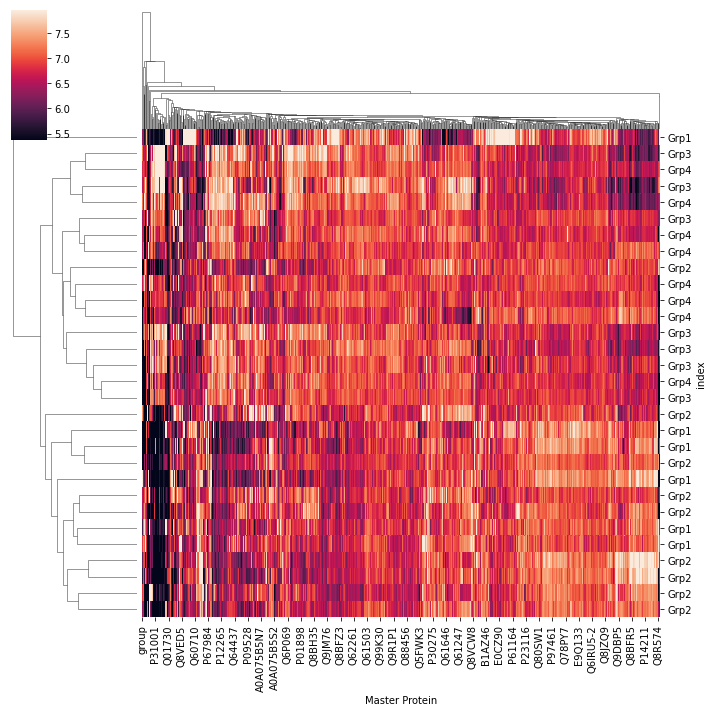

In [207]:
sns.clustermap(dfidgroups, robust = True)

Text(0.5, 1.3, 'Hierarchical Clustering of Mouse BAL - No imputation')

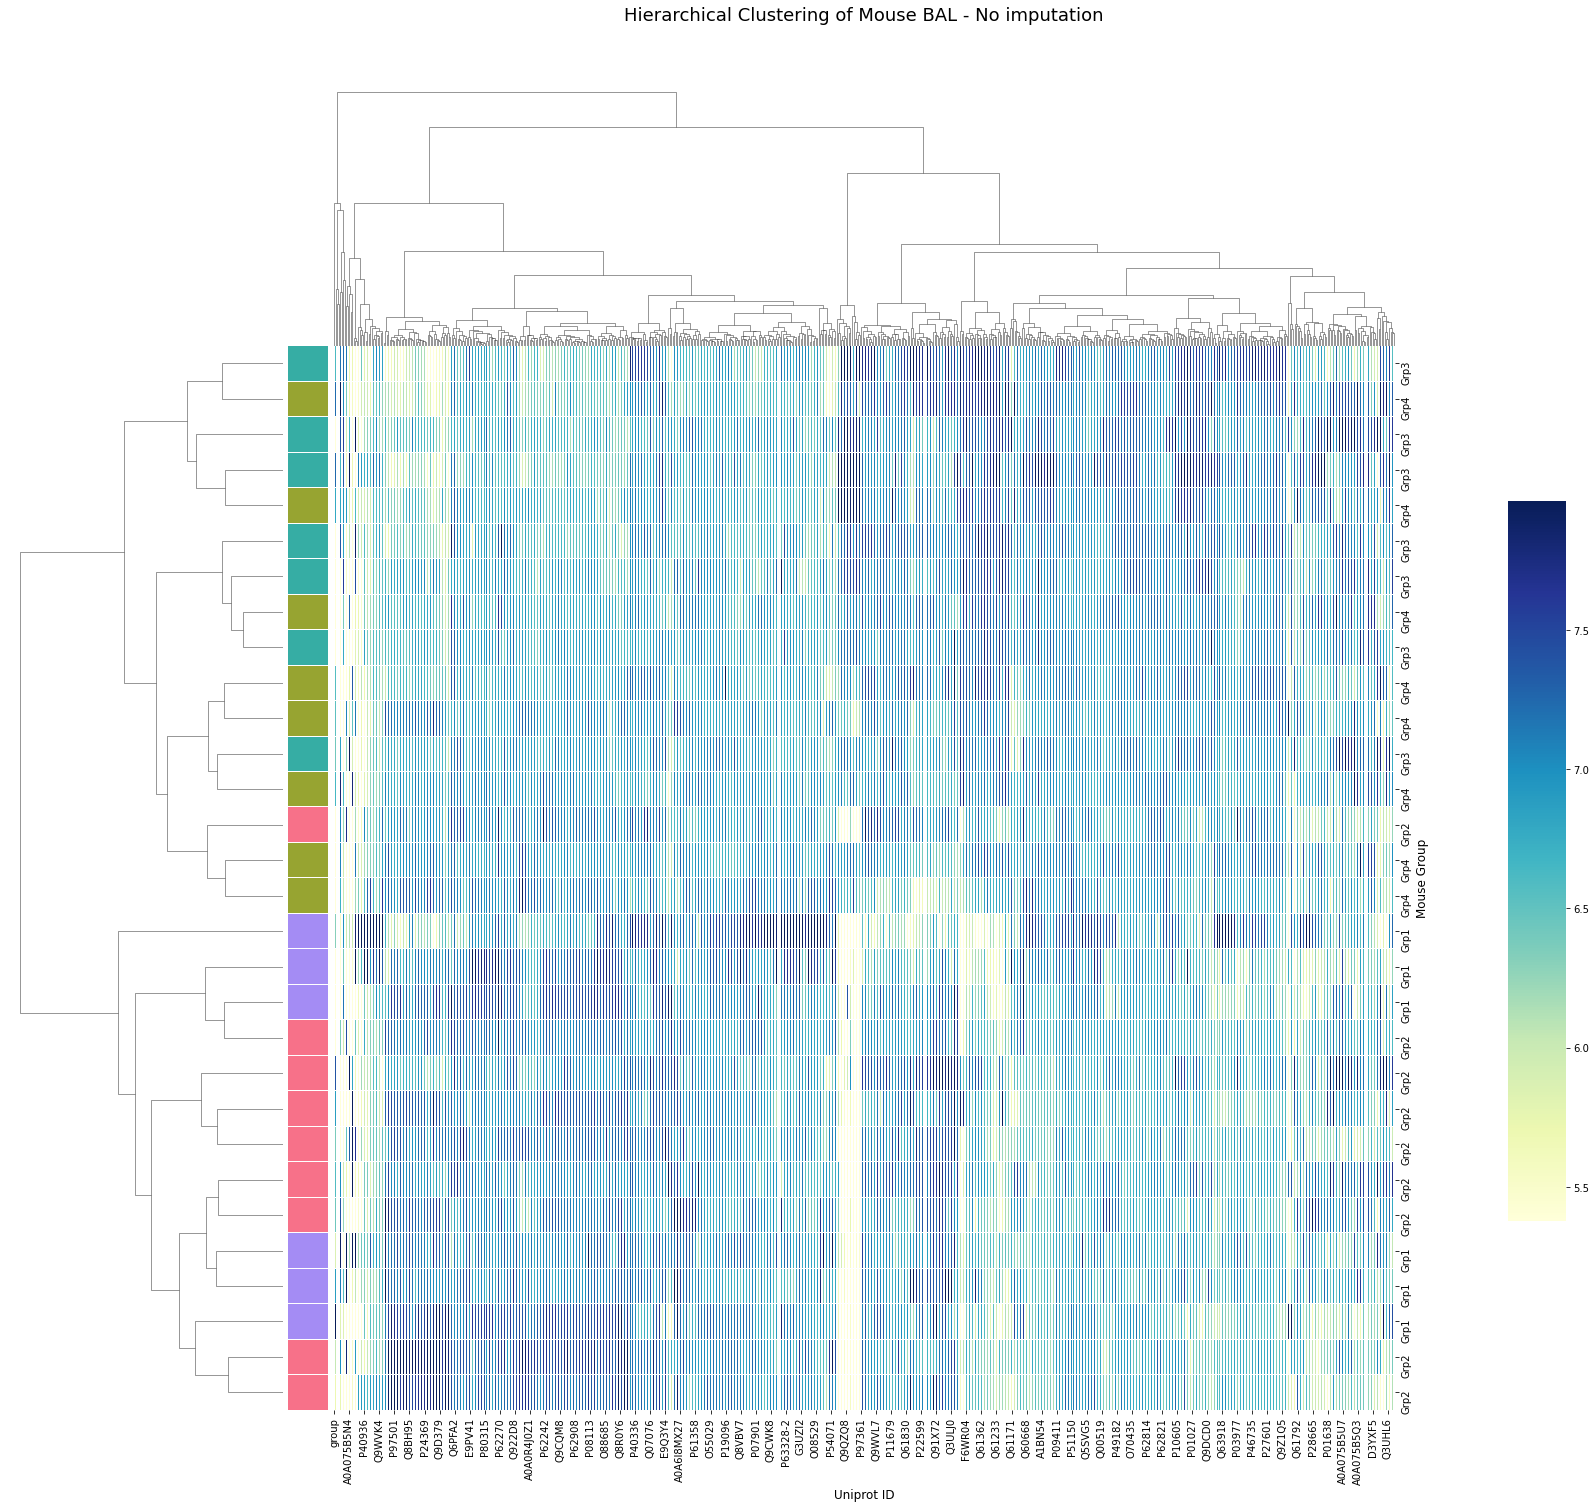

In [208]:
#create a second color palette with the same number of colors as unique values in the Source column
network_pal2 = sns.color_palette('husl', len(dfidgroups.group.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut2 = dict(zip(dfidgroups.group.unique(), network_pal2))

#get the series of all of the categories
networks2 = dfidgroups.group

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors2 = pd.Series(networks2).map(network_lut2)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(dfidgroups, robust = True, method = 'ward', cmap = "YlGnBu", figsize=(20,20), linewidths=0.01, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors2])
ax = g.ax_heatmap
ax.set_xlabel("Uniprot ID", fontsize = 12)
ax.set_ylabel("Mouse Group", fontsize = 12)
ax.set_title('Hierarchical Clustering of Mouse BAL - No imputation', y=1.3, fontsize = 18)

In [209]:
for label in dfidgroups.group.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut2[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [210]:
#Export image with legends 
g.cax.set_position([1.05, .2, .04, .5])
g.savefig("clustermap4.png")

In [211]:
df22

Grp2      Grp2      Grp2      Grp4      Grp4      Grp2  \
Master Protein                                                                
A0A075B5K2       6.946804  6.615433  5.811810  5.993291  7.752379  6.195696   
A0A075B5M7       7.122029  5.940550  6.626725  5.683627  6.207868  6.191325   
A0A075B5N3       8.311375  6.840893  6.290366  6.557225  6.233539  7.417450   
A0A075B5N4      10.513669  5.405010  7.294176  5.742811  5.897884  3.549614   
A0A075B5N7       7.142490  7.147126  5.990395  6.265118  6.818141  6.612930   
...                   ...       ...       ...       ...       ...       ...   
Q9Z204           6.964942  7.293347  7.228193  7.328015  6.638839  7.450682   
Q9Z2U0           6.581404  6.516038  6.572980  6.849942  6.627711  6.448793   
Q9Z2U1           6.690987  6.606475  6.793916  6.937321  6.920346  6.691245   
S4R239           7.441130  6.580474  7.279753  7.178235  7.167309  6.938063   
W4VSP4           6.555264  6.035292  6.534317  7.398858  7.355033  6.799277   

                    Grp3      Grp2      Grp1      Grp1  ...      Grp3  \
Master Protein                                          ...             
A0A075B5K2      8.128574  6.102325  7.475047  6.772681  ...  7.083630   
A0A075B5M7      7.950688  5.583924  6.300349  6.955180  ...  6.912170   
A0A075B5N3      7.254144  6.178642  6.928456  5.933660  ...  6.920637   
A0A075B5N4      9.308832  4.390075  6.146764  6.109547  ...  6.092421   
A0A075B5N7      8.130294  6.311169  6.271634  6.491217  ...  7.230217   
...                  ...       ...       ...       ...  ...       ...   
Q9Z204          7.119497  7.424248  6.139802  6.421037  ...  7.900068   
Q9Z2U0          6.792055  6.535073  6.826192  6.817315  ...  7.201681   
Q9Z2U1          7.142324  6.826534  7.140685  7.291208  ...  7.256030   
S4R239          7.065838  6.985614  6.870979  5.468370  ...  7.686278   
W4VSP4          6.496920  6.575379  6.257564  7.505069  ...  7.621851   

                    Grp2      Grp2      Grp4      Grp4      Grp3      Grp4  \
Master Protein                                                               
A0A075B5K2      6.493957  6.273730  6.220173  6.571735  8.474093  8.196012   
A0A075B5M7      6.691054  5.823109  6.198400  5.944772  7.558636  6.927891   
A0A075B5N3      6.903838  5.886791  6.203769  6.029816  7.242512  8.060542   
A0A075B5N4      4.778606  4.504901  4.590555  4.339156  6.680154  5.000849   
A0A075B5N7      6.884871  6.602233  6.426193  6.810713  8.098250  7.008911   
...                  ...       ...       ...       ...       ...       ...   
Q9Z204          7.681229  7.659866  7.160519  7.390227  6.645743  7.318691   
Q9Z2U0          6.453094  6.552726  6.599698  6.575872  7.310488  7.306227   
Q9Z2U1          6.636140  6.852767  6.843590  6.568846  7.295982  7.002098   
S4R239          6.776868  7.182783  7.163259  6.513406  7.118976  7.031072   
W4VSP4          6.864152  7.817443  7.597340  6.971712  6.547682  6.453853   

                    Grp2      Grp2      Grp1  
Master Protein                                
A0A075B5K2      7.254969  6.221017  5.427131  
A0A075B5M7      7.143902  7.236791  7.264620  
A0A075B5N3      7.353620  6.643005  6.544168  
A0A075B5N4      5.353027  4.457326  4.131011  
A0A075B5N7      7.098692  7.361393  6.175781  
...                  ...       ...       ...  
Q9Z204          7.565516  6.415840  7.230018  
Q9Z2U0          6.724083  6.645041  6.849149  
Q9Z2U1          6.987029  7.382070  7.120187  
S4R239          7.208239  7.048518  6.969566  
W4VSP4          6.618216  6.412584  6.307114  

[704 rows x 30 columns]

In [212]:
df2transpose = df22.transpose()
df2transpose

Master Protein  A0A075B5K2  A0A075B5M7  A0A075B5N3  A0A075B5N4  A0A075B5N7  \
Grp2              6.946804    7.122029    8.311375   10.513669    7.142490   
Grp2              6.615433    5.940550    6.840893    5.405010    7.147126   
Grp2              5.811810    6.626725    6.290366    7.294176    5.990395   
Grp4              5.993291    5.683627    6.557225    5.742811    6.265118   
Grp4              7.752379    6.207868    6.233539    5.897884    6.818141   
Grp2              6.195696    6.191325    7.417450    3.549614    6.612930   
Grp3              8.128574    7.950688    7.254144    9.308832    8.130294   
Grp2              6.102325    5.583924    6.178642    4.390075    6.311169   
Grp1              7.475047    6.300349    6.928456    6.146764    6.271634   
Grp1              6.772681    6.955180    5.933660    6.109547    6.491217   
Grp3              5.721060    7.563191    7.553211    5.760598    6.725114   
Grp3              6.903881    8.339681    7.246847    7.999628    7.053253   
Grp4              7.291136    7.092180    7.398205    5.727438    7.451524   
Grp4              6.511178    7.627411    7.878032    5.917519    7.522980   
Grp1              6.738375    6.391041    6.857725    4.823732    6.703533   
Grp1              4.947139    6.041379    6.521510    4.958316    6.539709   
Grp3              7.582773    6.606106    7.070720    4.959251    7.133136   
Grp1              6.352775    5.622408    6.454735    4.329069    6.165442   
Grp4              6.560916    6.393719    6.883950    7.257016    6.875860   
Grp3              6.554601    6.571716    6.745372    5.125402    6.929611   
Grp3              7.083630    6.912170    6.920637    6.092421    7.230217   
Grp2              6.493957    6.691054    6.903838    4.778606    6.884871   
Grp2              6.273730    5.823109    5.886791    4.504901    6.602233   
Grp4              6.220173    6.198400    6.203769    4.590555    6.426193   
Grp4              6.571735    5.944772    6.029816    4.339156    6.810713   
Grp3              8.474093    7.558636    7.242512    6.680154    8.098250   
Grp4              8.196012    6.927891    8.060542    5.000849    7.008911   
Grp2              7.254969    7.143902    7.353620    5.353027    7.098692   
Grp2              6.221017    7.236791    6.643005    4.457326    7.361393   
Grp1              5.427131    7.264620    6.544168    4.131011    6.175781   

Master Protein  A0A075B5P6  A0A075B5Q3  A0A075B5R0  A0A075B5R2  A0A075B5R5  \
Grp2              6.822322    7.794693    5.161093    1.950588    7.037940   
Grp2              6.301997    6.796757    4.847443    1.332952    7.868450   
Grp2              6.683076    5.944445    5.057609    2.077285    6.205279   
Grp4              7.251170    6.471004    4.368405    2.044918    6.850985   
Grp4              7.551027    7.021318    8.578160    1.170080    6.402411   
Grp2              6.105230    6.561692    4.605689    6.989031    5.716422   
Grp3              8.054150    7.102804    5.992635    6.839617    6.908956   
Grp2              5.927086    6.458628    5.976713    5.741861    5.507286   
Grp1              7.126517    6.564587    4.517766    7.904673    6.561876   
Grp1              6.743512    7.066420    4.928384    5.546061    5.955694   
Grp3              8.052375    6.182348    4.714252    7.203835    6.814931   
Grp3              6.679581    7.499239    4.335694    6.651196    7.483375   
Grp4              7.477734    7.953208    5.542925    8.120260    7.162882   
Grp4              6.008477    7.222899    4.913725    6.813742    7.324685   
Grp1              6.201424    7.657556    5.465890    7.108021    6.580663   
Grp1              7.969993    5.937964    5.359711    2.104614    6.408994   
Grp3              8.062315    6.821135    6.518985    2.210177    6.936640   
Grp1              6.562803    5.770257    6.748235    2.229689    6.261723   
Grp4              7.125123    6.945738    5.977516    2.090473    6.606540   
Grp3              6.3

In [213]:
df2transpose = df2transpose.reset_index()
df2transpose.head()

Master Protein index  A0A075B5K2  A0A075B5M7  A0A075B5N3  A0A075B5N4  \
0               Grp2    6.946804    7.122029    8.311375   10.513669   
1               Grp2    6.615433    5.940550    6.840893    5.405010   
2               Grp2    5.811810    6.626725    6.290366    7.294176   
3               Grp4    5.993291    5.683627    6.557225    5.742811   
4               Grp4    7.752379    6.207868    6.233539    5.897884   

Master Protein  A0A075B5N7  A0A075B5P6  A0A075B5Q3  A0A075B5R0  A0A075B5R2  \
0                 7.142490    6.822322    7.794693    5.161093    1.950588   
1                 7.147126    6.301997    6.796757    4.847443    1.332952   
2                 5.990395    6.683076    5.944445    5.057609    2.077285   
3                 6.265118    7.251170    6.471004    4.368405    2.044918   
4                 6.818141    7.551027    7.021318    8.578160    1.170080   

Master Protein  ...    Q9WVL7    Q9Z0K8    Q9Z0N1    Q9Z1Q5    Q9Z1Q9  \
0               ...  7.628619  7.042408  7.045243  7.168163  6.490108   
1               ...  6.504644  8.547170  7.172731  6.614105  7.215594   
2               ...  6.713426  6.242354  7.003587  6.860381  6.981930   
3               ...  7.449734  6.711648  7.031811  7.371981  6.451976   
4               ...  6.781726  7.034490  6.875168  7.235024  6.738708   

Master Protein    Q9Z204    Q9Z2U0    Q9Z2U1    S4R239    W4VSP4  
0               6.964942  6.581404  6.690987  7.441130  6.555264  
1               7.293347  6.516038  6.606475  6.580474  6.035292  
2               7.228193  6.572980  6.793916  7.279753  6.534317  
3               7.328015  6.849942  6.937321  7.178235  7.398858  
4               6.638839  6.627711  6.920346  7.167309  7.355033  

[5 rows x 705 columns]

In [214]:
#assign all protein values in dataframe to x
x = df2transpose.iloc[:, 1: 705].values
#assign groups to y 
y = df2transpose.loc[:,['index']].values

#view x and y values
x, y

(array([[6.94680416, 7.12202855, 8.31137517, ..., 6.69098702, 7.44113016,
         6.55526416],
        [6.61543254, 5.94055   , 6.84089339, ..., 6.60647511, 6.58047431,
         6.03529195],
        [5.81181049, 6.62672549, 6.29036583, ..., 6.79391567, 7.27975334,
         6.53431743],
        ...,
        [7.25496886, 7.14390152, 7.3536204 , ..., 6.98702917, 7.20823864,
         6.61821571],
        [6.22101718, 7.23679055, 6.64300546, ..., 7.38206955, 7.04851806,
         6.41258364],
        [5.4271314 , 7.26461976, 6.54416805, ..., 7.12018673, 6.96956636,
         6.307114  ]]),
 array([['Grp2'],
        ['Grp2'],
        ['Grp2'],
        ['Grp4'],
        ['Grp4'],
        ['Grp2'],
        ['Grp3'],
        ['Grp2'],
        ['Grp1'],
        ['Grp1'],
        ['Grp3'],
        ['Grp3'],
        ['Grp4'],
        ['Grp4'],
        ['Grp1'],
        ['Grp1'],
        ['Grp3'],
        ['Grp1'],
        ['Grp4'],
        ['Grp3'],
        ['Grp3'],
        ['Grp2'],
        ['Grp

In [215]:
#Scale the data using Standardscaler from sklearn to remove  - this is important for PCA and machine learning processes
x = StandardScaler().fit_transform(x)
x

array([[ 0.30060362,  0.6238441 ,  2.36231076, ..., -1.12990233,
         1.13942442, -0.62894594],
       [-0.11273334, -1.05786068, -0.06142243, ..., -1.45431386,
        -1.07851775, -1.71754924],
       [-1.11513265, -0.08116534, -0.96883382, ..., -0.73479537,
         0.72355033, -0.67279959],
       ...,
       [ 0.68499338,  0.65497787,  0.7836839 , ...,  0.00649955,
         0.5392543 , -0.49715185],
       [-0.60470799,  0.78719519, -0.38759278, ...,  1.52292087,
         0.12764842, -0.927659  ],
       [-1.59496277,  0.82680701, -0.55050231, ...,  0.51764467,
        -0.07581304, -1.1484681 ]])

In [216]:
#Perform 2 component PCA analysis using sklearn
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

principal component 1  principal component 2
0               1.083436             -11.350967
1             -13.974616              -8.925755
2             -13.508414              -6.832340
3              11.192927              -3.866233
4               1.854134              -2.765731

In [217]:
#Merge x PCA analysis with y (groups) into a single dataframe
finalDf = pd.concat([principalDf, df2transpose[['index']]], axis = 1)
finalDf.head(5)

principal component 1  principal component 2 index
0               1.083436             -11.350967  Grp2
1             -13.974616              -8.925755  Grp2
2             -13.508414              -6.832340  Grp2
3              11.192927              -3.866233  Grp4
4               1.854134              -2.765731  Grp4

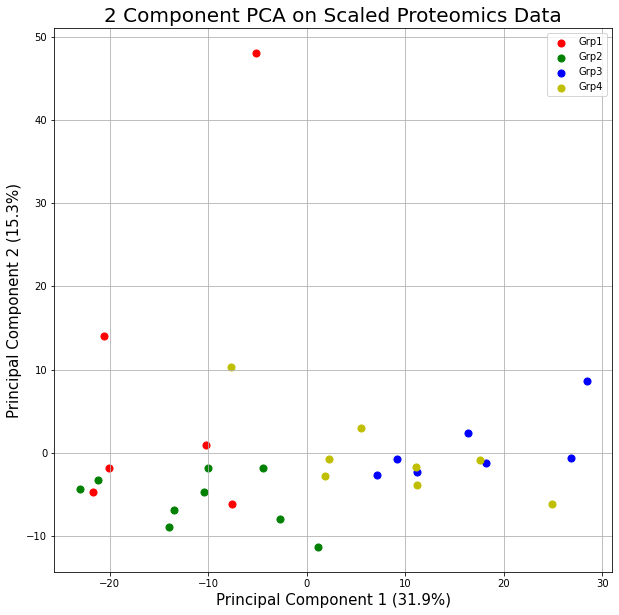

In [218]:
#Plot PCA dataframe
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (31.9%)', fontsize = 15)
ax.set_ylabel('Principal Component 2 (15.3%)', fontsize = 15)
ax.set_title('2 Component PCA on Scaled Proteomics Data', fontsize = 20)


targets = ['Grp1', 'Grp2', 'Grp3', 'Grp4']
colors = ['r', 'g', 'b', 'y', 'k', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['index'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [219]:
pca.explained_variance_ratio_

array([0.31931865, 0.15277853])

In [220]:
#Perform 3 component PCA analysis using sklearn
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head()

principal component 1  principal component 2  principal component 3
0               1.083438             -11.350983              11.531949
1             -13.974612              -8.925689              -1.470882
2             -13.508405              -6.832301               9.782279
3              11.192930              -3.866197               8.085983
4               1.854135              -2.765695              -4.597453

In [221]:
pca.explained_variance_ratio_

array([0.31931865, 0.15277853, 0.08537096])

In [222]:
#Merge x PCA analysis with y (groups) into a single dataframe
finalDf = pd.concat([principalDf, df2transpose[['index']]], axis = 1)
finalDf.head(5)

principal component 1  principal component 2  principal component 3 index
0               1.083438             -11.350983              11.531949  Grp2
1             -13.974612              -8.925689              -1.470882  Grp2
2             -13.508405              -6.832301               9.782279  Grp2
3              11.192930              -3.866197               8.085983  Grp4
4               1.854135              -2.765695              -4.597453  Grp4

In [223]:
finalDf.columns = ['PC1','PC2','PC3','group']
finalDf

PC1        PC2        PC3 group
0    1.083438 -11.350983  11.531949  Grp2
1  -13.974612  -8.925689  -1.470882  Grp2
2  -13.508405  -6.832301   9.782279  Grp2
3   11.192930  -3.866197   8.085983  Grp4
4    1.854135  -2.765695  -4.597453  Grp4
5  -23.060307  -4.408502   2.025604  Grp2
6    7.139078  -2.633757  -3.146899  Grp3
7  -21.203284  -3.235877   7.720615  Grp2
8  -10.206971   0.980848   0.348774  Grp1
9   -5.204903  48.084366  10.248756  Grp1
10  26.848221  -0.652465  19.774921  Grp3
11  28.433382   8.566494  -2.835304  Grp3
12  24.850860  -6.124991   6.855555  Grp4
13  17.528190  -0.898275  -1.256934  Grp4
14  -7.604148  -6.209178   6.811092  Grp1
15 -20.062680  -1.862749  -0.184358  Grp1
16  11.140430  -2.324248  -9.320760  Grp3
17 -20.619161  14.078666  -0.624435  Grp1
18  11.038512  -1.674092  -6.779017  Grp4
19   9.132507  -0.754011  -4.941854  Grp3
20  18.185282  -1.206921   1.819715  Grp3
21 -10.015224  -1.840536  -2.705556  Grp2
22  -4.432326  -1.873528   6.710042  Grp2
23   5.538557   3.012560  -8.815250  Grp4
24  -7.721804  10.362439 -14.674645  Grp4
25  16.341643   2.404459 -11.954072  Grp3
26   2.249591  -0.758519 -10.499547  Grp4
27  -2.694492  -7.926097   0.059651  Grp2
28 -10.488893  -4.687692  -7.267929  Grp2
29 -21.759547  -4.677530  -0.700040  Grp1

In [224]:
pca.explained_variance_ratio_

array([0.31931865, 0.15277853, 0.08537096])

In [225]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    principalComponents, x=0, y=1, z=2, color=finalDf['group'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1 (31.9%)', '1': 'PC 2 (15.3%)', '2': 'PC 3 (8.5%)'}
)
fig.show()

# Binary comparisons Grp2 vs Grp1

In [344]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_named.xlsx', index_col=0)
Normalized_df2.head()

Grp2      Grp2.1     Grp2.2        Grp4      Grp4.1  \
Master Protein                                                              
A0A075B5K0      156.846470  225.231942  86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104  56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672  60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621  67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN        NaN         NaN         NaN   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   

                ...      Grp3.5      Grp2.5     Grp2.6      Grp4.5     Grp4.6  \
Master Protein  ...                                                             
A0A075B5K0      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5K2      ...  135.639160   90.131332  77.371496   74.551864  95.123837   
A0A075B5K9      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L2      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L7      ...  133.142607  119.017735  86.630495  150.284217  78.427115   

                    Grp3.6      Grp4.7      Grp2.7      Grp2.8     Grp1.5  
Master Protein                                                             
A0A075B5K0             NaN         NaN         NaN         NaN        NaN  
A0A075B5K2      355.595548  293.254940  152.743678   74.595525  43.025838  
A0A075B5K9             NaN         NaN         NaN         NaN        NaN  
A0A075B5L2             NaN         NaN         NaN         NaN        NaN  
A0A075B5L7      136.159220  170.375509  160.412703  100.762541  63.119272  

[5 rows x 30 columns]

In [345]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'./proteins.xlsx', index_col=0) 

#View dataframe
proteinlist

Proteins
Master Protein         
A8DUK4           Hbb-bs
P06728            Apoa4
Q91VB8           Hba-a1
P02088           Hbb-b1
P99027            Rplp2
...                 ...
E9Q0B5            Fcgbp
E9Q1Y3             Apob
E9Q6R7             Utrn
O88738            Birc6
Q7TMY8            Huwe1

[1603 rows x 1 columns]

In [346]:
Normalized_df2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp3.5      Grp2.5      Grp2.6      Grp4.5  \
Master Protein  ...                                                   
A0A075B5K0      ...         NaN         NaN         NaN         NaN   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5K9      ...         NaN         NaN         NaN         NaN   
A0A075B5L2      ...         NaN         NaN         NaN         NaN   
A0A075B5L7      ...  133.142607  119.017735   86.630495  150.284217   
...             ...         ...         ...         ...         ...   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581559  114.848648   
Q9Z2X1          ...         NaN         NaN         NaN         NaN   
S4R239          ...  205.968231  109.658089  145.289108  143.336170   
W4VSP4          ...  196.972559  116.497244  225.571851  193.654322   

                    Grp4.6      Grp3.6      Grp4.7      Grp2.7      Grp2.8  \
Master Protein                                                               
A0A075B5K0             NaN         NaN         NaN         NaN         NaN   
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5K9             NaN         NaN         NaN         NaN         NaN   
A0A075B5L2             NaN         NaN         NaN         NaN         NaN   
A0A075B5L7       78.427115  136.159220  170.375509  160.412703  100.762541   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
Q9Z2X1                 NaN         NaN         NaN         NaN         NaN   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                    Grp1.5  
Master Prot

In [347]:
Grp1 = ['Grp1', 'Grp1.1', 'Grp1.2', 'Grp1.3', 'Grp1.4', 'Grp1.5']
Grp2 = ['Grp2', 'Grp2.1','Grp2.2', 'Grp2.3', 'Grp2.4', 'Grp2.5', 'Grp2.6', 'Grp2.7','Grp2.8']

In [348]:
Grp1_df = Normalized_df2[Grp1]
Grp2_df = Normalized_df2[Grp2]

In [349]:
Grp1Grp2 = TwoCategoryMaster(Normalized_df2,Grp2_df,Grp1_df,"Grp2","Grp1")
Grp1Grp2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN         NaN      0.216585   
A0A075B5K2      ...  152.743678   74.595525   43.025838      0.964226   
A0A075B5K9      ...         NaN         NaN         NaN      0.990601   
A0A075B5L2      ...         NaN         NaN         NaN      0.424347   
A0A075B5L7      ...  160.412703  100.762541   63.119272      0.175991   
...             ...         ...         ...         ...           ...   
Q9Z2U0          ...  105.718405  100.082138  115.292052      0.005828   
Q9Z2U1          ...  126.854349  166.810877  139.120068      0.424828   
Q9Z2X1          ...         NaN         NaN         NaN      0.956779   
S4R239          ...  147.875439  132.377861  125.328122      0.067780   
W4VSP4          ...   98.238438   85.188314   79.182735      0.878377   

                 Grp2 Mean   Grp1 Mean  Fold Change(Grp2/Grp1)  \
Master Protein                                                   
A0A075B5K0      115.157820   66.133258                1.741300   
A0A075B5K2       90.492496   91.604985                0.987856   
A0A075B5K9       64.738772   64.542712                1.003038   
A0A075B5L2      212.888234  141.597961                1.503470   
A0A075B5L7      116.705868   84.345278                1.383668   
...                    ...         ...                     ...   
Q9Z2U0           94.430543  108.286761                0.872041   
Q9Z2U1          115.252893  125.300303                0.919813   
Q9Z2X1          157.305000  154.872087                1.015709   
S4R239          134.380576  104.039564                1.291630   
W4VSP4          109.394695  105.811126                1.033868   

                Log2(Fold Change)  -Log(P-value)  Grp2/Grp1 pi score  
Master Protein                                                        
A0A075B5K0               0.8

In [350]:
#Annotate the file with protein names
Grp1Grp2a = pd.merge(Grp1Grp2, proteinlist, left_index=True, right_index=True)
Grp1Grp2a

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp2 Mean  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN      0.216585  115.157820   
A0A075B5K2      ...   74.595525   43.025838      0.964226   90.492496   
A0A075B5K9      ...         NaN         NaN      0.990601   64.738772   
A0A075B5L2      ...         NaN         NaN      0.424347  212.888234   
A0A075B5L7      ...  100.762541   63.119272      0.175991  116.705868   
...             ...         ...         ...           ...         ...   
Q9Z2U0          ...  100.082138  115.292052      0.005828   94.430543   
Q9Z2U1          ...  166.810877  139.120068      0.424828  115.252893   
Q9Z2X1          ...         NaN         NaN      0.956779  157.305000   
S4R239          ...  132.377861  125.328122      0.067780  134.380576   
W4VSP4          ...   85.188314   79.182735      0.878377  109.394695   

                 Grp1 Mean  Fold Change(Grp2/Grp1)  Log2(Fold Change)  \
Master Protein                                                          
A0A075B5K0       66.133258                1.741300           0.800165   
A0A075B5K2       91.604985                0.987856          -0.017628   
A0A075B5K9       64.542712                1.003038           0.004376   
A0A075B5L2      141.597961                1.503470           0.588296   
A0A075B5L7       84.345278                1.383668           0.468498   
...                    ...                     ...                ...   
Q9Z2U0          108.286761                0.872041          -0.197531   
Q9Z2U1          125.300303                0.919813          -0.120587   
Q9Z2X1          154.872087                1.015709           0.022487   
S4R239          104.039564                1.291630           0.369192   
W4VSP4          105.811126                1.033868           0.048051   

                -Log(P-value)  Grp2/Grp1 pi score    Proteins  
Master Protein 

In [351]:
top10 = Normalized_df2['Grp2/Grp1 pi score'].nlargest(10)
low10 = Normalized_df2['Grp2/Grp1 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp2/Grp1 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp2/Grp1 pi score'].isin(low10)]

In [352]:
top10

Master Protein
P49935        2.749883
Q9WV55        2.172211
Q64442        1.629269
A0A0A6YXW6    1.420727
Q9D9V4        1.402142
A0A140T8P3    1.332945
Q9D7Z6        1.332391
P68372        1.267187
Q06890        1.211614
O35640        1.172840
Name: Grp2/Grp1 pi score, dtype: float64

In [353]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

Grp2/Grp1 pi score    Proteins
Master Protein                                
P49935                    2.749883        Ctsh
Q9WV55                    2.172211        Vapa
Q64442                    1.629269        Sord
A0A0A6YXW6                1.420727        Igha
Q9D9V4                    1.402142       Rsph9
A0A140T8P3                1.332945  Igkv15-103
Q9D7Z6                    1.332391       Clca1
P68372                    1.267187      Tubb4b
Q06890                    1.211614         Clu
O35640                    1.172840       Anxa8

In [354]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp2/Grp1 pi score']) > (1))]

In [355]:
df_sign

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                                
A0A075B5N4      1461.940504   42.371130  156.951608   53.549850   59.626580   
A0A075B5R0        35.780276   28.788946   33.303657   20.654790  382.193695   
A0A0A6YXW6       106.966549  262.411674   38.273682  162.560700  156.733748   
A0A0G2JFZ3         2.746218    1.789815    2.998296    2.931780    1.598743   
A0A140T8P3       179.796478  204.512680  162.966197   72.432200  198.479212   
A0A1L1SUN1              NaN         NaN         NaN         NaN         NaN   
A0A1L1SV73              NaN         NaN         NaN         NaN         NaN   
E9PWE8            67.820953   59.627537   50.316705   64.871696   61.741502   
E9PZ88             6.865544    4.474537    7.495740    7.329449    3.996857   
H3BKM0             1.263597    0.823534    1.379584  132.874362  105.781845   
K3W4S6                  NaN         NaN         NaN         NaN         NaN   
O08553            67.451817   55.319895   55.128181   70.205376   64.240176   
O35593                  NaN         NaN         NaN         NaN         NaN   
O35640           158.676923  184.960404  238.829771  130.697972  102.264408   
P01636            60.448068   38.419859   34.602635   63.978881   50.152407   
P12265            97.611334   96.843501   79.627039  179.016834  148.359007   
P15105                  NaN         NaN         NaN         NaN         NaN   
P23927            61.056088   26.401582   56.846232   59.324024   23.107335   
P40936            65.665458   61.352334   58.924288   52.090743   38.339531   
P46935                  NaN         NaN         NaN         NaN         NaN   
P49935           154.935856   96.945528  122.169367  213.935123  202.318510   
P52480-2          80.933390  123.077230   74.842430   72.237788   99.124503   
P68372                  NaN         NaN         NaN         NaN         NaN   
P97807                  NaN         NaN         NaN         NaN         NaN   
Q01730            63.737213   57.990005   71.386698   87.633555   57.467535   
Q06890           191.750212  141.525161   82.417778  165.653100  133.469415   
Q61114           120.736755  202.868811  180.576009  168.805472  142.772916   
Q62151            42.332976   43.437487   38.050255   47.312494   42.755893   
Q64310                  NaN         NaN         NaN         NaN         NaN   
Q64442                  NaN         NaN         NaN         NaN         NaN   
Q64737           102.466520  140.476530  135.825809   98.065083  115.514511   
Q6IRU2           102.336989   98.755673  101.236577  109.251901  153.714414   
Q9D7N9                  NaN         NaN         NaN         NaN         NaN   
Q9D7Z6           114.326052  873.252962  484.034252  163.561285   90.911801   
Q9D8C4                  NaN         NaN         NaN         NaN         NaN   
Q9D9V4           140.320540  133.408853  182.120324   99.331076   78.078135   
Q9WTM5           150.346596  146.510780  141.242830  120.324246  120.333331   
Q9WV55            87.594870  124.515575  136.732629   72.030790  103.366989   

                    Grp2.3        Grp3      Grp2.4        Grp1       Grp1.1  \
Master Protein                                                                
A0A075B5N4       11.709551  634.216827   20.967391   70.853338    69.048912   
A0A075B5R0       24.347291   63.674129   62.975256   22.907784    30.450281   
A0A0A6YXW6       80.544229  220.456584   30.867607   68.366004    31.448954   
A0A0G2JFZ3        3.101449    1.812312    2.795652    3.338282   125.547424   
A0A140T8P3      674.291422  114.175673   84.609590   59.794527    56.077015   
A0A1L1SUN1             NaN         NaN         NaN         NaN          NaN   
A0A1L1SV73             NaN         NaN         NaN         NaN          NaN   
E9PWE8           77.107839   60.452129   98.233965   70.684900   803.026202   
E9PZ88            7.753622    4.530781   98.546738  120.178162   100.721

In [356]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                                
A0A075B5N4      1461.940504   42.371130  156.951608   53.549850   59.626580   
A0A075B5R0        35.780276   28.788946   33.303657   20.654790  382.193695   
A0A0A6YXW6       106.966549  262.411674   38.273682  162.560700  156.733748   
A0A0G2JFZ3         2.746218    1.789815    2.998296    2.931780    1.598743   
A0A140T8P3       179.796478  204.512680  162.966197   72.432200  198.479212   
A0A1L1SUN1              NaN         NaN         NaN         NaN         NaN   
A0A1L1SV73              NaN         NaN         NaN         NaN         NaN   
E9PWE8            67.820953   59.627537   50.316705   64.871696   61.741502   
E9PZ88             6.865544    4.474537    7.495740    7.329449    3.996857   
H3BKM0             1.263597    0.823534    1.379584  132.874362  105.781845   
K3W4S6                  NaN         NaN         NaN         NaN         NaN   
O08553            67.451817   55.319895   55.128181   70.205376   64.240176   
O35593                  NaN         NaN         NaN         NaN         NaN   
O35640           158.676923  184.960404  238.829771  130.697972  102.264408   
P01636            60.448068   38.419859   34.602635   63.978881   50.152407   
P12265            97.611334   96.843501   79.627039  179.016834  148.359007   
P15105                  NaN         NaN         NaN         NaN         NaN   
P23927            61.056088   26.401582   56.846232   59.324024   23.107335   
P40936            65.665458   61.352334   58.924288   52.090743   38.339531   
P46935                  NaN         NaN         NaN         NaN         NaN   
P49935           154.935856   96.945528  122.169367  213.935123  202.318510   
P52480-2          80.933390  123.077230   74.842430   72.237788   99.124503   
P68372                  NaN         NaN         NaN         NaN         NaN   
P97807                  NaN         NaN         NaN         NaN         NaN   
Q01730            63.737213   57.990005   71.386698   87.633555   57.467535   
Q06890           191.750212  141.525161   82.417778  165.653100  133.469415   
Q61114           120.736755  202.868811  180.576009  168.805472  142.772916   
Q62151            42.332976   43.437487   38.050255   47.312494   42.755893   
Q64310                  NaN         NaN         NaN         NaN         NaN   
Q64442                  NaN         NaN         NaN         NaN         NaN   
Q64737           102.466520  140.476530  135.825809   98.065083  115.514511   
Q6IRU2           102.336989   98.755673  101.236577  109.251901  153.714414   
Q9D7N9                  NaN         NaN         NaN         NaN         NaN   
Q9D7Z6           114.326052  873.252962  484.034252  163.561285   90.911801   
Q9D8C4                  NaN         NaN         NaN         NaN         NaN   
Q9D9V4           140.320540  133.408853  182.120324   99.331076   78.078135   
Q9WTM5           150.346596  146.510780  141.242830  120.324246  120.333331   
Q9WV55            87.594870  124.515575  136.732629   72.030790  103.366989   

                    Grp2.3        Grp3      Grp2.4        Grp1       Grp1.1  \
Master Protein                                                                
A0A075B5N4       11.709551  634.216827   20.967391   70.853338    69.048912   
A0A075B5R0       24.347291   63.674129   62.975256   22.907784    30.450281   
A0A0A6YXW6       80.544229  220.456584   30.867607   68.366004    31.448954   
A0A0G2JFZ3        3.101449    1.812312    2.795652    3.338282   125.547424   
A0A140T8P3      674.291422  114.175673   84.609590   59.794527    56.077015   
A0A1L1SUN1             NaN         NaN         NaN         NaN          NaN   
A0A1L1SV73             NaN         NaN         NaN         NaN          NaN   
E9PWE8           77.107839   60.452129   98.233965   70.684900   803.026202   
E9PZ88            7.753622    4.530781   98.546738  120.178162   100.721

In [360]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp21pi.csv')

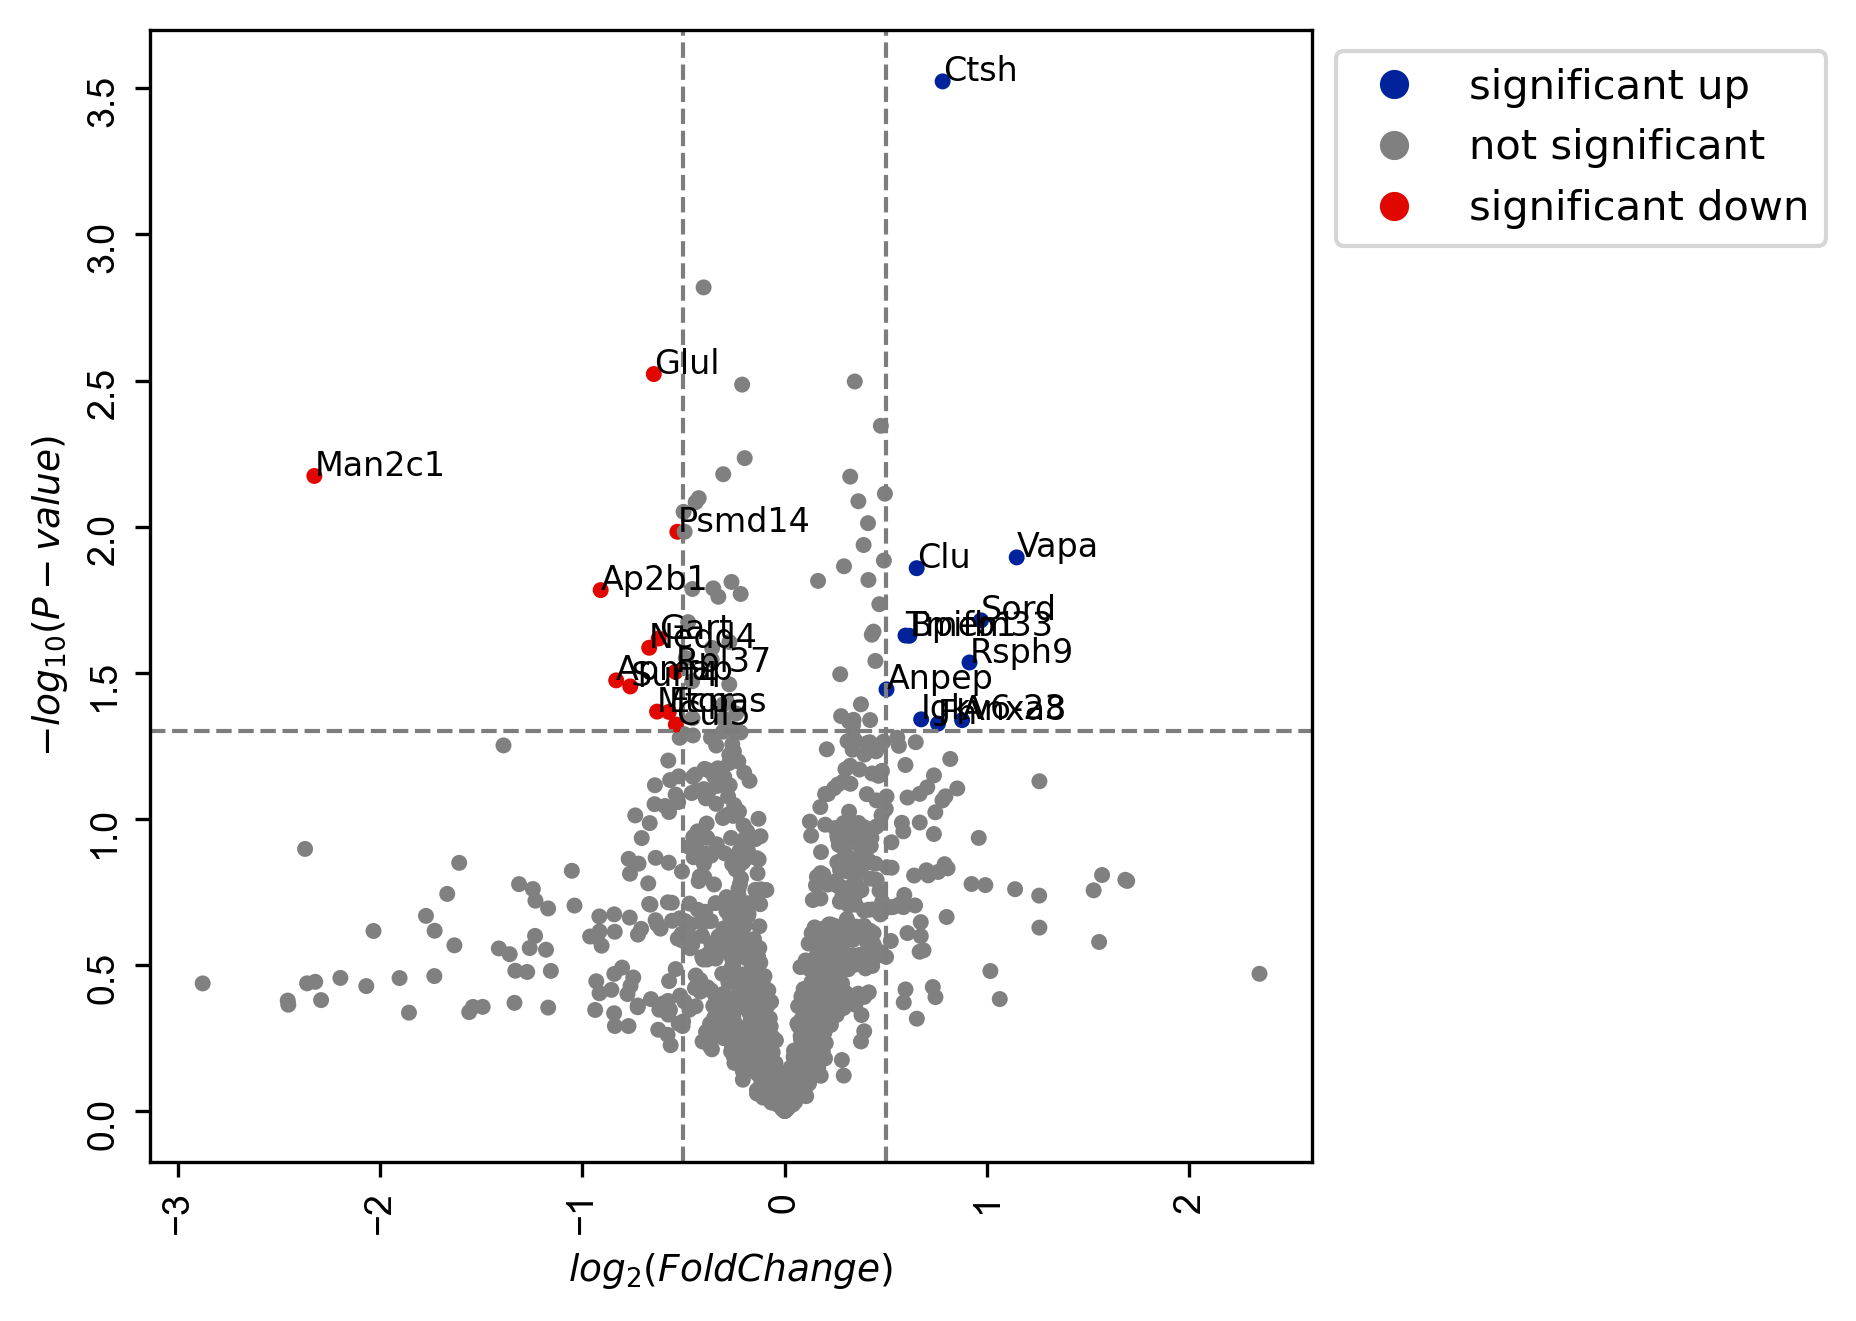

In [357]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp1Grp2a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

In [358]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp2')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

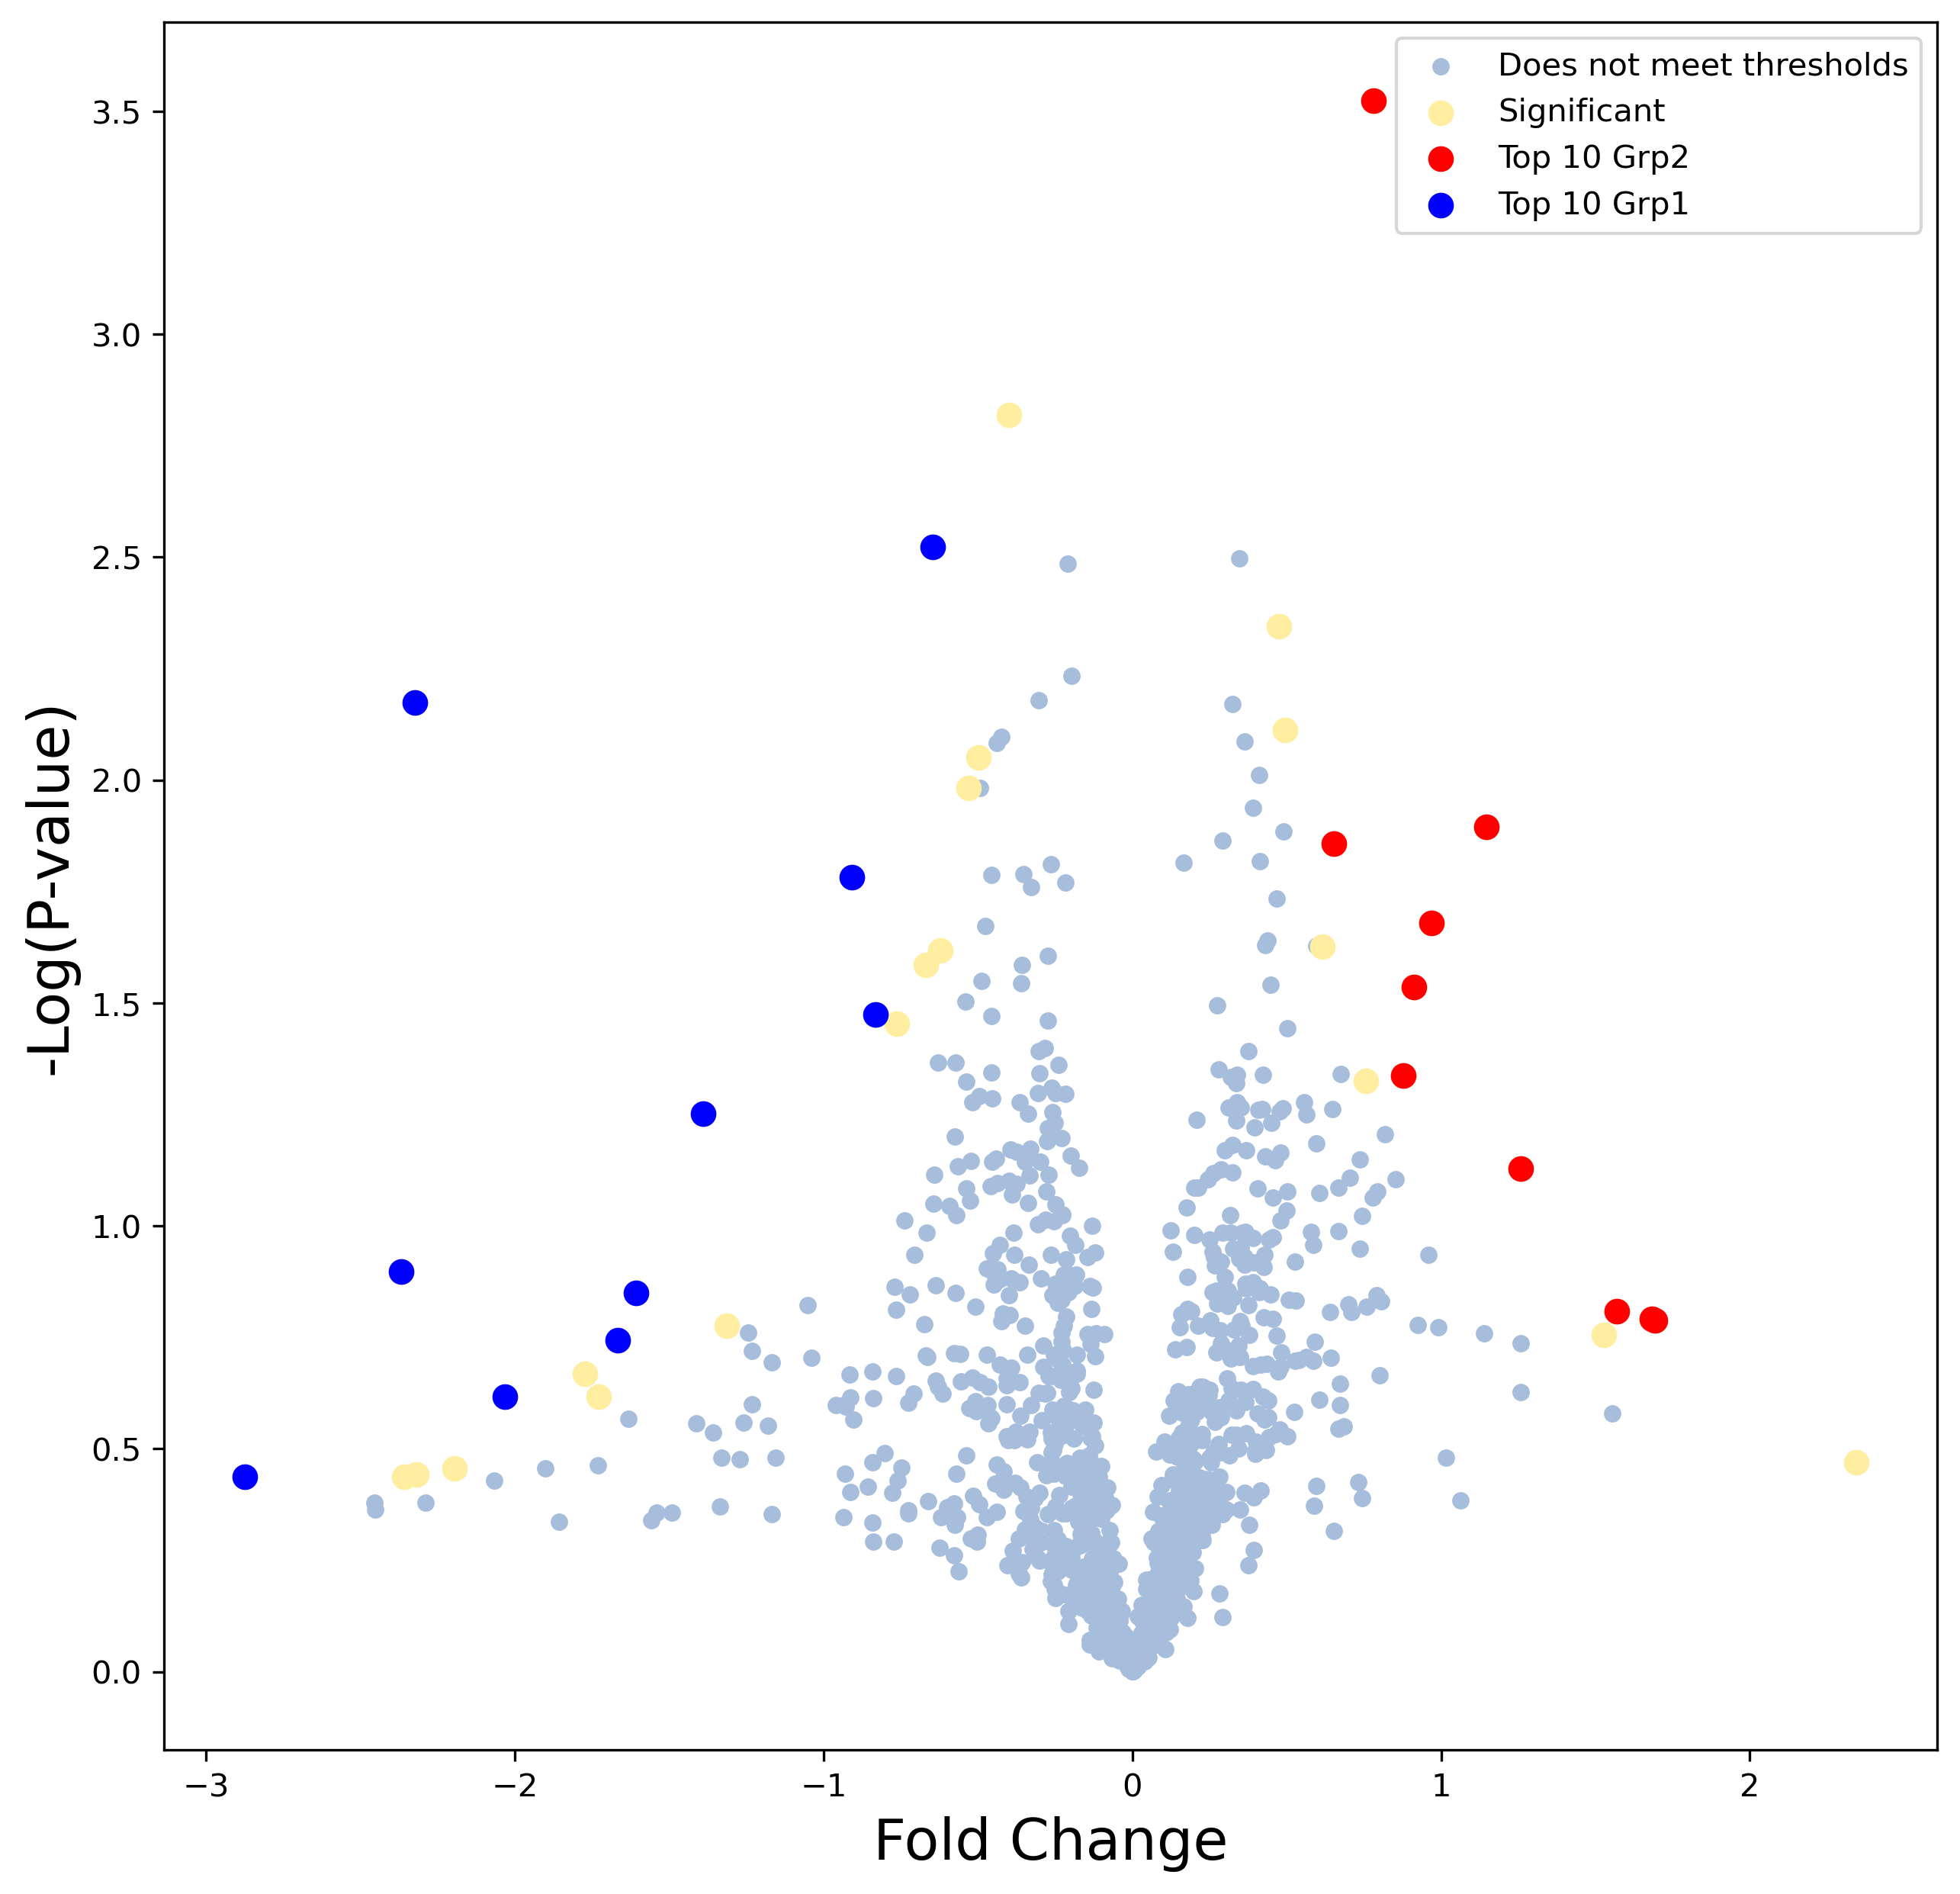

In [359]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

# Pathway analysis based upon biologically significant hits (pi score > 1)

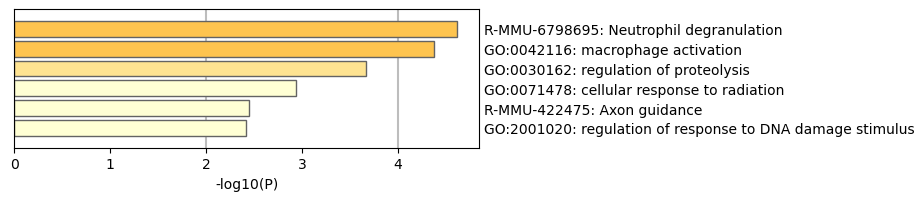

# Binary comparisons Grp4 vs Grp3

In [362]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_named.xlsx', index_col=0)
Normalized_df2.head()

Grp2      Grp2.1     Grp2.2        Grp4      Grp4.1  \
Master Protein                                                              
A0A075B5K0      156.846470  225.231942  86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104  56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672  60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621  67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN        NaN         NaN         NaN   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   

                ...      Grp3.5      Grp2.5     Grp2.6      Grp4.5     Grp4.6  \
Master Protein  ...                                                             
A0A075B5K0      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5K2      ...  135.639160   90.131332  77.371496   74.551864  95.123837   
A0A075B5K9      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L2      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L7      ...  133.142607  119.017735  86.630495  150.284217  78.427115   

                    Grp3.6      Grp4.7      Grp2.7      Grp2.8     Grp1.5  
Master Protein                                                             
A0A075B5K0             NaN         NaN         NaN         NaN        NaN  
A0A075B5K2      355.595548  293.254940  152.743678   74.595525  43.025838  
A0A075B5K9             NaN         NaN         NaN         NaN        NaN  
A0A075B5L2             NaN         NaN         NaN         NaN        NaN  
A0A075B5L7      136.159220  170.375509  160.412703  100.762541  63.119272  

[5 rows x 30 columns]

In [363]:
Normalized_df2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp3.5      Grp2.5      Grp2.6      Grp4.5  \
Master Protein  ...                                                   
A0A075B5K0      ...         NaN         NaN         NaN         NaN   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5K9      ...         NaN         NaN         NaN         NaN   
A0A075B5L2      ...         NaN         NaN         NaN         NaN   
A0A075B5L7      ...  133.142607  119.017735   86.630495  150.284217   
...             ...         ...         ...         ...         ...   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581559  114.848648   
Q9Z2X1          ...         NaN         NaN         NaN         NaN   
S4R239          ...  205.968231  109.658089  145.289108  143.336170   
W4VSP4          ...  196.972559  116.497244  225.571851  193.654322   

                    Grp4.6      Grp3.6      Grp4.7      Grp2.7      Grp2.8  \
Master Protein                                                               
A0A075B5K0             NaN         NaN         NaN         NaN         NaN   
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5K9             NaN         NaN         NaN         NaN         NaN   
A0A075B5L2             NaN         NaN         NaN         NaN         NaN   
A0A075B5L7       78.427115  136.159220  170.375509  160.412703  100.762541   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
Q9Z2X1                 NaN         NaN         NaN         NaN         NaN   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                    Grp1.5  
Master Prot

In [364]:
Grp3 = ['Grp3', 'Grp3.1', 'Grp3.2', 'Grp3.3', 'Grp3.4', 'Grp3.5', 'Grp3.6']
Grp4 = ['Grp4', 'Grp4.1','Grp4.2', 'Grp4.3', 'Grp4.4', 'Grp4.5', 'Grp4.6', 'Grp4.7']

In [365]:
Grp3_df = Normalized_df2[Grp3]
Grp4_df = Normalized_df2[Grp4]

In [366]:
Grp3Grp4 = TwoCategoryMaster(Normalized_df2,Grp4_df,Grp3_df,"Grp4","Grp3")
Grp3Grp4

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN         NaN      0.852557   
A0A075B5K2      ...  152.743678   74.595525   43.025838      0.438752   
A0A075B5K9      ...         NaN         NaN         NaN      0.556448   
A0A075B5L2      ...         NaN         NaN         NaN      0.390382   
A0A075B5L7      ...  160.412703  100.762541   63.119272      0.857145   
...             ...         ...         ...         ...           ...   
Q9Z2U0          ...  105.718405  100.082138  115.292052      0.316413   
Q9Z2U1          ...  126.854349  166.810877  139.120068      0.083704   
Q9Z2X1          ...         NaN         NaN         NaN      0.910849   
S4R239          ...  147.875439  132.377861  125.328122      0.991512   
W4VSP4          ...   98.238438   85.188314   79.182735      0.848342   

                 Grp4 Mean   Grp3 Mean  Fold Change(Grp4/Grp3)  \
Master Protein                                                   
A0A075B5K0      120.636087  125.502719                0.961223   
A0A075B5K2      135.563306  175.615041                0.771934   
A0A075B5K9      145.253068   93.589182                1.552028   
A0A075B5L2      111.398840  523.882970                0.212641   
A0A075B5L7      123.995604  128.575468                0.964380   
...                    ...         ...                     ...   
Q9Z2U0          127.331620  142.610852                0.892861   
Q9Z2U1          129.341874  148.554855                0.870667   
Q9Z2X1          116.878700  115.488730                1.012036   
S4R239          141.829437  141.655700                1.001226   
W4VSP4          139.460677  134.872765                1.034017   

                Log2(Fold Change)  -Log(P-value)  Grp4/Grp3 pi score  
Master Protein                                                        
A0A075B5K0              -0.0

In [367]:
#Annotate the file with protein names
Grp3Grp4a = pd.merge(Grp3Grp4, proteinlist, left_index=True, right_index=True)
Grp3Grp4a

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp4 Mean  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN      0.852557  120.636087   
A0A075B5K2      ...   74.595525   43.025838      0.438752  135.563306   
A0A075B5K9      ...         NaN         NaN      0.556448  145.253068   
A0A075B5L2      ...         NaN         NaN      0.390382  111.398840   
A0A075B5L7      ...  100.762541   63.119272      0.857145  123.995604   
...             ...         ...         ...           ...         ...   
Q9Z2U0          ...  100.082138  115.292052      0.316413  127.331620   
Q9Z2U1          ...  166.810877  139.120068      0.083704  129.341874   
Q9Z2X1          ...         NaN         NaN      0.910849  116.878700   
S4R239          ...  132.377861  125.328122      0.991512  141.829437   
W4VSP4          ...   85.188314   79.182735      0.848342  139.460677   

                 Grp3 Mean  Fold Change(Grp4/Grp3)  Log2(Fold Change)  \
Master Protein                                                          
A0A075B5K0      125.502719                0.961223          -0.057057   
A0A075B5K2      175.615041                0.771934          -0.373450   
A0A075B5K9       93.589182                1.552028           0.634155   
A0A075B5L2      523.882970                0.212641          -2.233510   
A0A075B5L7      128.575468                0.964380          -0.052326   
...                    ...                     ...                ...   
Q9Z2U0          142.610852                0.892861          -0.163493   
Q9Z2U1          148.554855                0.870667          -0.199806   
Q9Z2X1          115.488730                1.012036           0.017260   
S4R239          141.655700                1.001226           0.001768   
W4VSP4          134.872765                1.034017           0.048259   

                -Log(P-value)  Grp4/Grp3 pi score    Proteins  
Master Protein 

In [368]:
top10 = Normalized_df2['Grp4/Grp3 pi score'].nlargest(10)
low10 = Normalized_df2['Grp4/Grp3 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp4/Grp3 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp4/Grp3 pi score'].isin(low10)]

In [369]:
top10

Master Protein
P35486        1.936287
P48962        1.672099
Q99LC5        1.464918
Q3UBX0        1.119376
A0A1L1SUN1    1.014541
Q9CPU0        0.952350
Q61425        0.918510
P62849        0.913858
P08074        0.899591
G5E902        0.897036
Name: Grp4/Grp3 pi score, dtype: float64

In [370]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

Grp4/Grp3 pi score Proteins
Master Protein                             
P35486                    1.936287    Pdha1
P48962                    1.672099  Slc25a4
Q99LC5                    1.464918     Etfa
Q3UBX0                    1.119376  Tmem109
A0A1L1SUN1                1.014541    Rpl29
Q9CPU0                    0.952350     Glo1
Q61425                    0.918510     Hadh
P62849                    0.913858    Rps24
P08074                    0.899591     Cbr2
G5E902                    0.897036  Slc25a3

In [371]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp4/Grp3 pi score']) > (1))]

In [372]:
df_sign

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5M7      139.297789   61.416313   98.819612   51.397515   73.918719   
A0A075B5T6             NaN         NaN         NaN         NaN         NaN   
A0A140T8P7      987.203099   70.416528  135.280689   43.654125   63.617453   
A0A1L1SUN1             NaN         NaN         NaN         NaN         NaN   
P01659                 NaN         NaN         NaN         NaN         NaN   
P18525                 NaN         NaN         NaN         NaN         NaN   
P35486          186.663193  156.154870  180.984089  119.714330  150.026948   
P48962           59.498572   98.000604  137.967594   91.343817  136.663081   
Q3UBX0          113.706147  180.180857  223.944879   81.719576  134.553982   
Q64475           31.496023   29.579359   23.879143   96.863277   68.251493   
Q99LC5          132.825428  188.421038  122.696682   97.680287  148.773828   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A075B5M7       73.075985  247.397569   47.965474   78.812297  124.084596   
A0A075B5T6             NaN         NaN         NaN         NaN         NaN   
A0A140T8P7       49.166302  390.356110   44.498033   54.420531   76.480342   
A0A1L1SUN1             NaN         NaN         NaN         NaN         NaN   
P01659                 NaN         NaN         NaN         NaN         NaN   
P18525                 NaN         NaN         NaN         NaN         NaN   
P35486          420.830622  109.855015  365.865781  214.206447  106.498920   
P48962          199.520187  101.995378  179.667816  107.378000   88.946288   
Q3UBX0          360.063799   86.318378  317.753246  181.583628   61.424565   
Q64475           21.264436  133.566214   16.070371   43.888464   35.203259   
Q99LC5          270.762942  122.336990  237.362906  137.524452   69.779936   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A075B5M7      ...  141.425800  150.831145  153.768882      0.053809   
A0A075B5T6      ...  314.548942  160.705258   60.928027      0.076996   
A0A140T8P7      ...   86.151071   61.235062   60.336360      0.103008   
A0A1L1SUN1      ...  137.315282  160.640816  203.037450      0.002335   
P01659          ...   90.343221   62.393684   13.439550      0.002019   
P18525          ...   57.528471   60.736022   22.705669      0.044218   
P35486          ...  119.117136  113.095423  149.536997      0.000149   
P48962          ...  107.871502   90.480964  177.127694      0.004497   
Q3UBX0          ...   84.730500  162.572236  218.019360      0.011447   
Q64475          ...   31.591056   31.700658   20.989439      0.180689   
Q99LC5          ...  181.020931  225.408279  186.457771      0.008560   

                 Grp4 Mean   Grp3 Mean  Fold Change(Grp4/Grp3)  \
Master Protein                                                   
A0A075B5M7      100.045939  180.284575                0.554933   
A0A075B5T6      123.100600  234.491361                0.524969   
A0A140T8P7       78.161711  170.854303                0.457476   
A0A1L1SUN1      104.575669   80.053873                1.306316   
P01659           89.018024  248.178137                0.358686   
P18525          110.417183  239.445332                0.461137   
P35486          127.870016   90.033002                1.420257   
P48962          109.633623   66.909184                1.638544   
Q3UBX0           93.163436   62.469603                1.491340   
Q64475          119.695936  311.512536                0.384241   
Q99LC5          122.713068   75.092830                1.634152   

                Log2(Fold Change)  -Log(P-value)  Grp4/Grp3 pi score  
Master Protein                                                        
A0A075B5M7              -0.849613       1

In [373]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5M7      139.297789   61.416313   98.819612   51.397515   73.918719   
A0A075B5T6             NaN         NaN         NaN         NaN         NaN   
A0A140T8P7      987.203099   70.416528  135.280689   43.654125   63.617453   
A0A1L1SUN1             NaN         NaN         NaN         NaN         NaN   
P01659                 NaN         NaN         NaN         NaN         NaN   
P18525                 NaN         NaN         NaN         NaN         NaN   
P35486          186.663193  156.154870  180.984089  119.714330  150.026948   
P48962           59.498572   98.000604  137.967594   91.343817  136.663081   
Q3UBX0          113.706147  180.180857  223.944879   81.719576  134.553982   
Q64475           31.496023   29.579359   23.879143   96.863277   68.251493   
Q99LC5          132.825428  188.421038  122.696682   97.680287  148.773828   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A075B5M7       73.075985  247.397569   47.965474   78.812297  124.084596   
A0A075B5T6             NaN         NaN         NaN         NaN         NaN   
A0A140T8P7       49.166302  390.356110   44.498033   54.420531   76.480342   
A0A1L1SUN1             NaN         NaN         NaN         NaN         NaN   
P01659                 NaN         NaN         NaN         NaN         NaN   
P18525                 NaN         NaN         NaN         NaN         NaN   
P35486          420.830622  109.855015  365.865781  214.206447  106.498920   
P48962          199.520187  101.995378  179.667816  107.378000   88.946288   
Q3UBX0          360.063799   86.318378  317.753246  181.583628   61.424565   
Q64475           21.264436  133.566214   16.070371   43.888464   35.203259   
Q99LC5          270.762942  122.336990  237.362906  137.524452   69.779936   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp4 Mean  \
Master Protein  ...                                                     
A0A075B5M7      ...  150.831145  153.768882      0.053809  100.045939   
A0A075B5T6      ...  160.705258   60.928027      0.076996  123.100600   
A0A140T8P7      ...   61.235062   60.336360      0.103008   78.161711   
A0A1L1SUN1      ...  160.640816  203.037450      0.002335  104.575669   
P01659          ...   62.393684   13.439550      0.002019   89.018024   
P18525          ...   60.736022   22.705669      0.044218  110.417183   
P35486          ...  113.095423  149.536997      0.000149  127.870016   
P48962          ...   90.480964  177.127694      0.004497  109.633623   
Q3UBX0          ...  162.572236  218.019360      0.011447   93.163436   
Q64475          ...   31.700658   20.989439      0.180689  119.695936   
Q99LC5          ...  225.408279  186.457771      0.008560  122.713068   

                 Grp3 Mean  Fold Change(Grp4/Grp3)  Log2(Fold Change)  \
Master Protein                                                          
A0A075B5M7      180.284575                0.554933          -0.849613   
A0A075B5T6      234.491361                0.524969          -0.929697   
A0A140T8P7      170.854303                0.457476          -1.128233   
A0A1L1SUN1       80.053873                1.306316           0.385504   
P01659          248.178137                0.358686          -1.479207   
P18525          239.445332                0.461137          -1.116732   
P35486           90.033002                1.420257           0.506152   
P48962           66.909184                1.638544           0.712414   
Q3UBX0           62.469603                1.491340           0.576609   
Q64475          311.512536                0.384241          -1.379916   
Q99LC5           75.092830                1.634152           0.708542   

                -Log(P-value)  Grp4/Grp3 pi score  Proteins  
Master Protein                

In [374]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp43pi.csv')

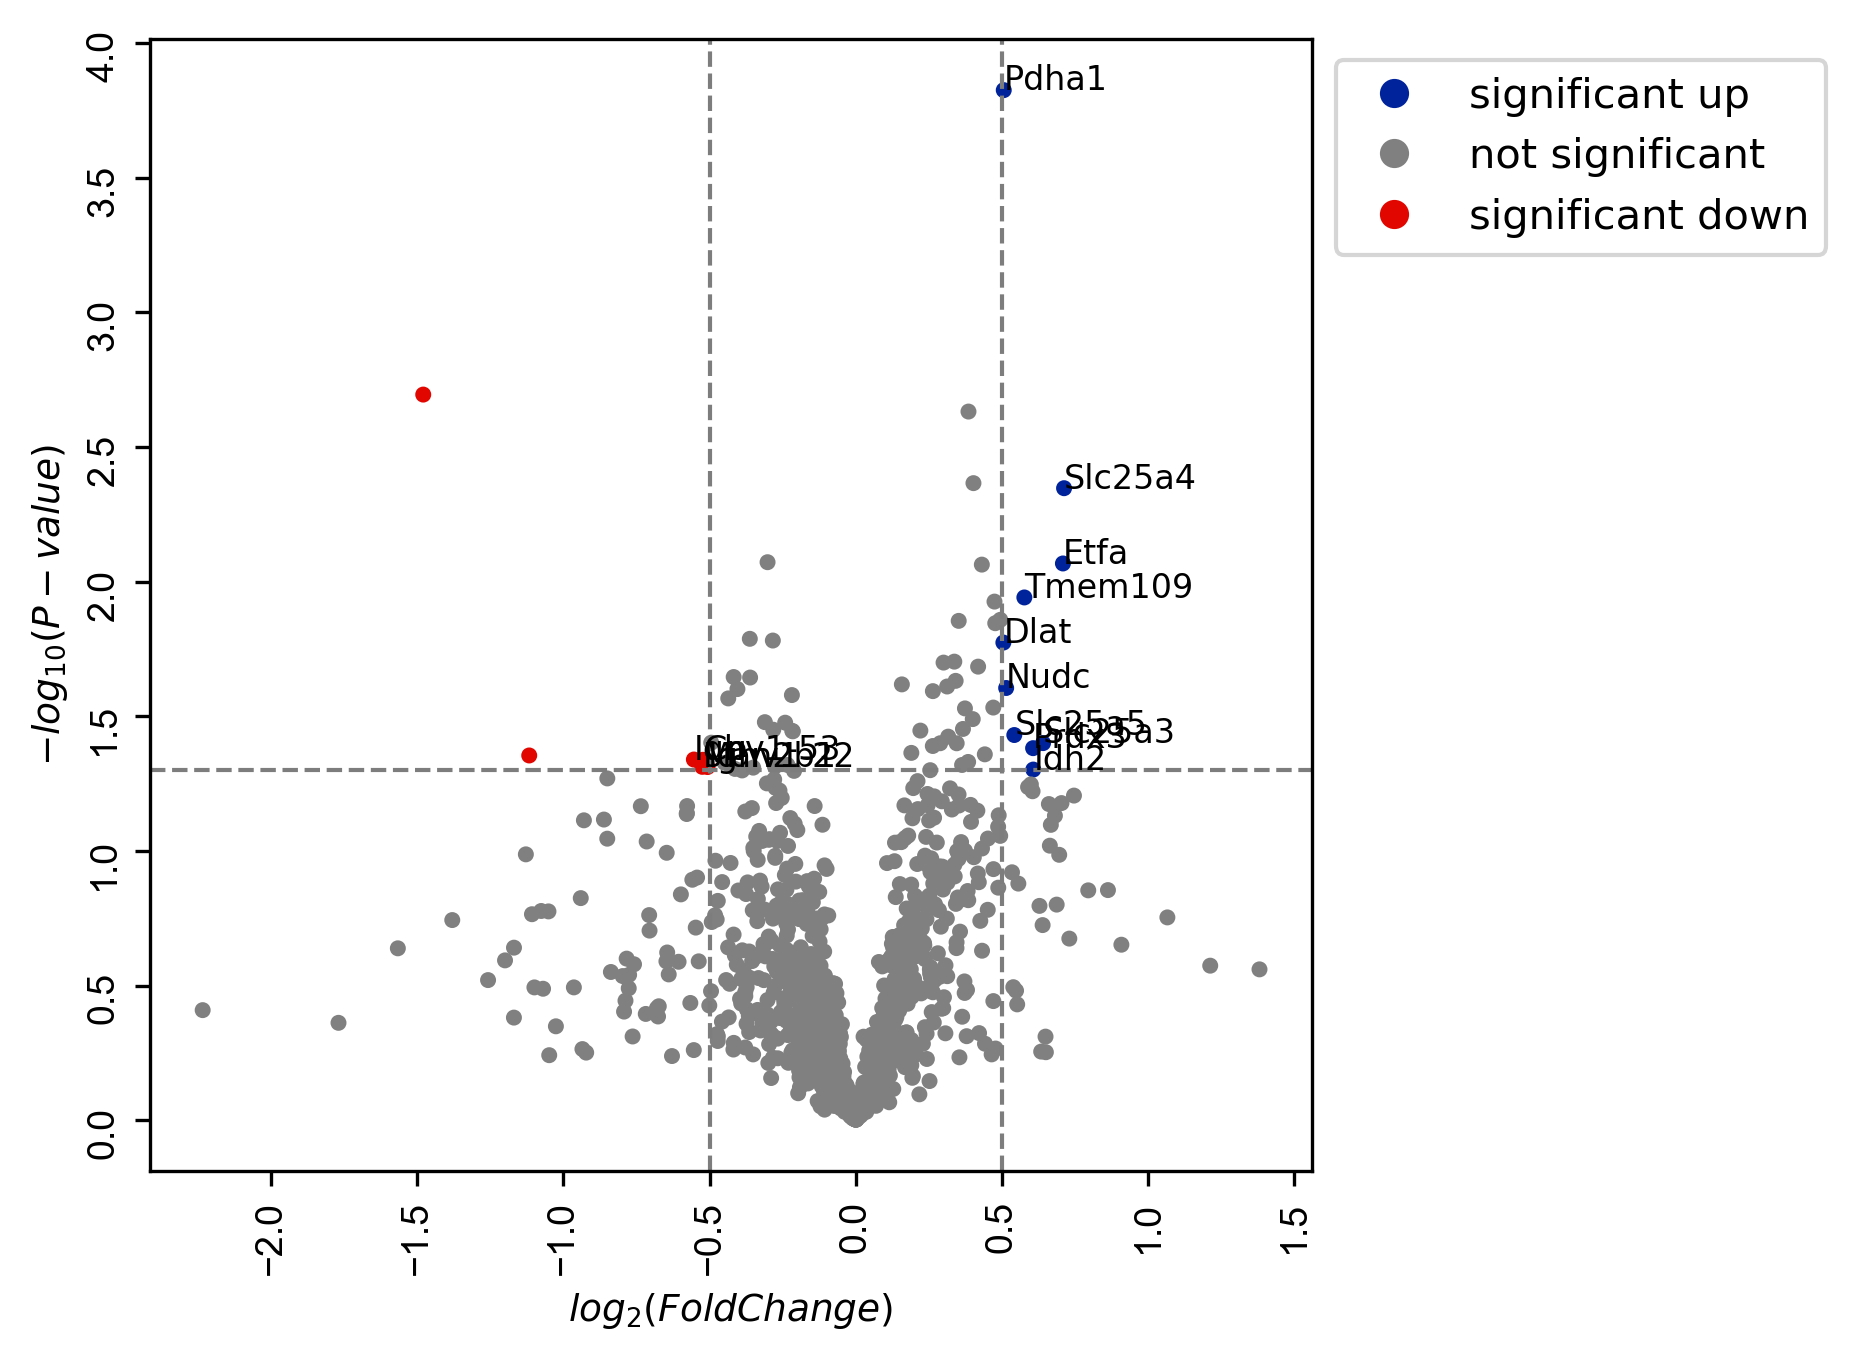

In [375]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp3Grp4a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

In [376]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp4')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp3')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

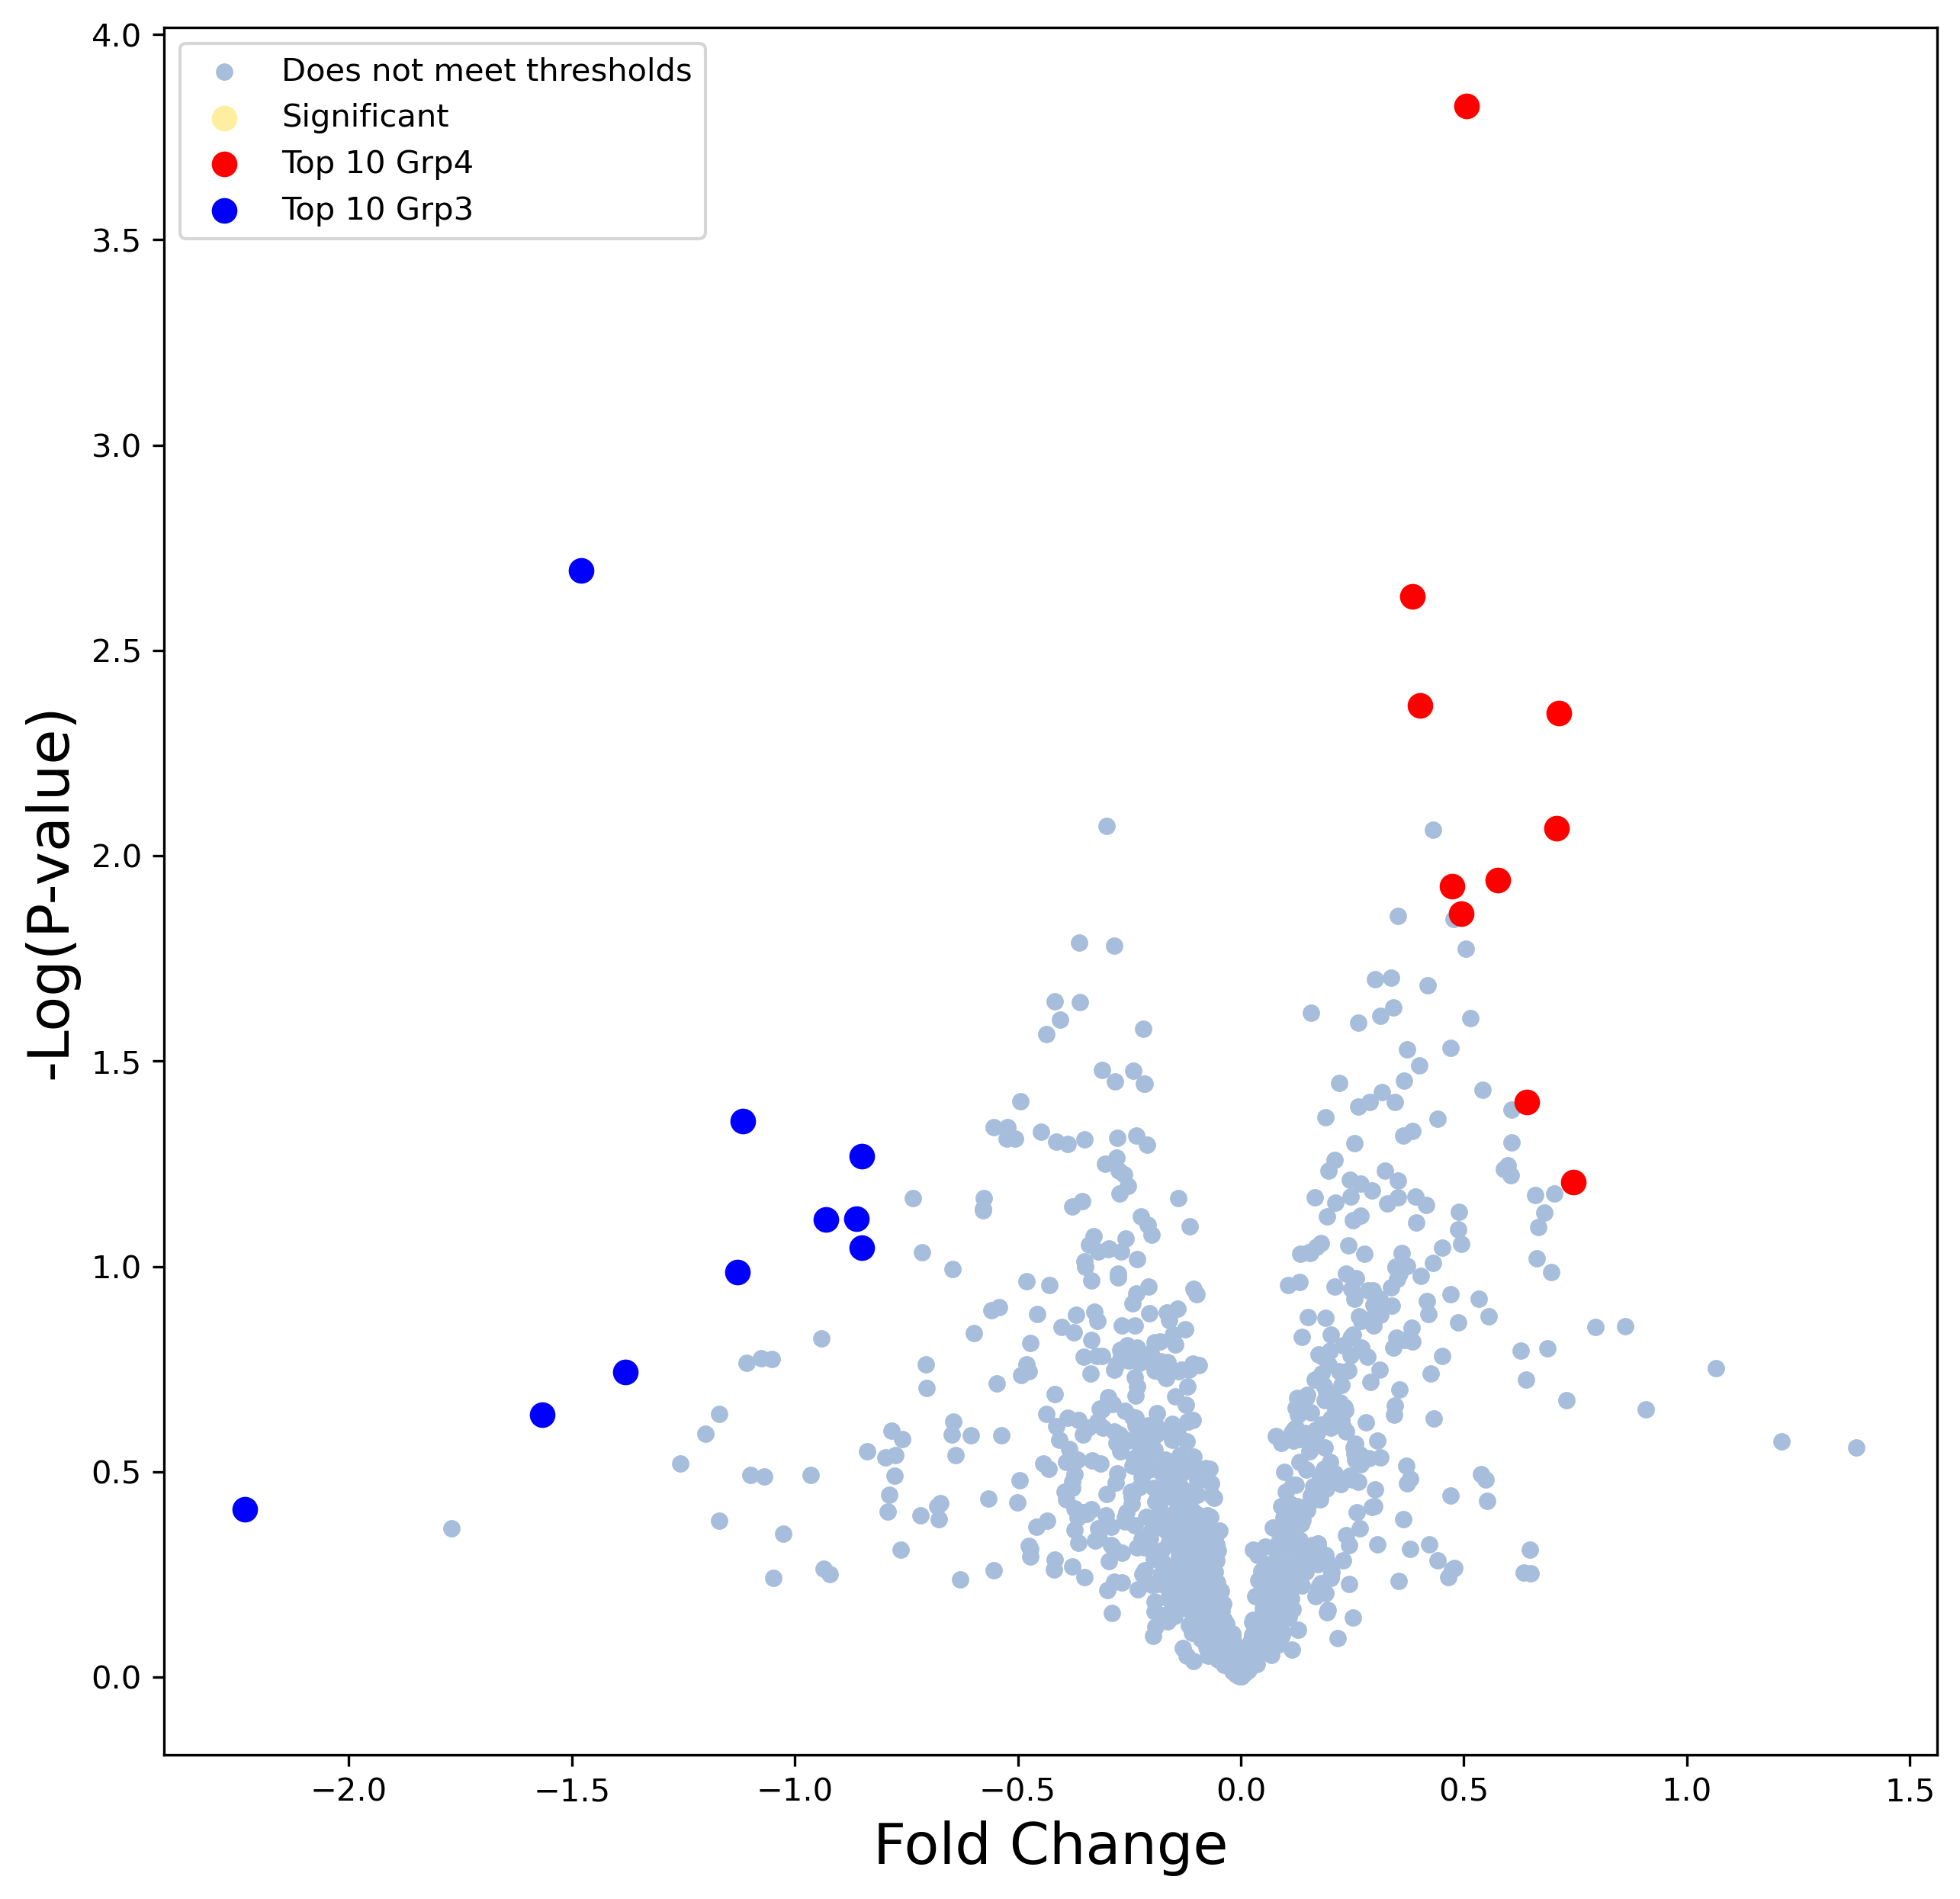

In [377]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_grp21.pdf')

In [343]:
Normalized_df2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp1.5  ttest_pvalue   Grp3 Mean   Grp4 Mean  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN      0.852557  125.502719  120.636087   
A0A075B5K2      ...   43.025838      0.438752  175.615041  135.563306   
A0A075B5K9      ...         NaN      0.556448   93.589182  145.253068   
A0A075B5L2      ...         NaN      0.390382  523.882970  111.398840   
A0A075B5L7      ...   63.119272      0.857145  128.575468  123.995604   
...             ...         ...           ...         ...         ...   
Q9Z2U0          ...  115.292052      0.316413  142.610852  127.331620   
Q9Z2U1          ...  139.120068      0.083704  148.554855  129.341874   
Q9Z2X1          ...         NaN      0.910849  115.488730  116.878700   
S4R239          ...  125.328122      0.991512  141.655700  141.829437   
W4VSP4          ...   79.182735      0.848342  134.872765  139.460677   

                Fold Change(Grp3/Grp4)  Log2(Fold Change)  -Log(P-value)  \
Master Protein                                                             
A0A075B5K0                    1.040341          -0.057057       0.069277   
A0A075B5K2                    1.295447          -0.373450       0.357780   
A0A075B5K9                    0.644318           0.634155       0.254575   
A0A075B5L2                    4.702769          -2.233510       0.408511   
A0A075B5L7                    1.036936          -0.052326       0.066946   
...                                ...                ...            ...   
Q9Z2U0                        1.119996          -0.163493       0.499746   
Q9Z2U1                        1.148544          -0.199806       1.077254   
Q9Z2X1                        0.988108           0.017260       0.040553   
S4R239                        0.998775           0.001768       0.003702   
W4VSP4                        0.967102           0.048259       0.071429   

                Grp3/Grp4 pi score  Fold

# Binary comparisons Grp4 vs Grp2

In [379]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_named.xlsx', index_col=0)
Normalized_df2.head()

Grp2      Grp2.1     Grp2.2        Grp4      Grp4.1  \
Master Protein                                                              
A0A075B5K0      156.846470  225.231942  86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104  56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672  60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621  67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN        NaN         NaN         NaN   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   

                ...      Grp3.5      Grp2.5     Grp2.6      Grp4.5     Grp4.6  \
Master Protein  ...                                                             
A0A075B5K0      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5K2      ...  135.639160   90.131332  77.371496   74.551864  95.123837   
A0A075B5K9      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L2      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L7      ...  133.142607  119.017735  86.630495  150.284217  78.427115   

                    Grp3.6      Grp4.7      Grp2.7      Grp2.8     Grp1.5  
Master Protein                                                             
A0A075B5K0             NaN         NaN         NaN         NaN        NaN  
A0A075B5K2      355.595548  293.254940  152.743678   74.595525  43.025838  
A0A075B5K9             NaN         NaN         NaN         NaN        NaN  
A0A075B5L2             NaN         NaN         NaN         NaN        NaN  
A0A075B5L7      136.159220  170.375509  160.412703  100.762541  63.119272  

[5 rows x 30 columns]

In [380]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'./proteins.xlsx', index_col=0) 

#View dataframe
proteinlist

Proteins
Master Protein         
A8DUK4           Hbb-bs
P06728            Apoa4
Q91VB8           Hba-a1
P02088           Hbb-b1
P99027            Rplp2
...                 ...
E9Q0B5            Fcgbp
E9Q1Y3             Apob
E9Q6R7             Utrn
O88738            Birc6
Q7TMY8            Huwe1

[1603 rows x 1 columns]

In [381]:
Normalized_df2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp3.5      Grp2.5      Grp2.6      Grp4.5  \
Master Protein  ...                                                   
A0A075B5K0      ...         NaN         NaN         NaN         NaN   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5K9      ...         NaN         NaN         NaN         NaN   
A0A075B5L2      ...         NaN         NaN         NaN         NaN   
A0A075B5L7      ...  133.142607  119.017735   86.630495  150.284217   
...             ...         ...         ...         ...         ...   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581559  114.848648   
Q9Z2X1          ...         NaN         NaN         NaN         NaN   
S4R239          ...  205.968231  109.658089  145.289108  143.336170   
W4VSP4          ...  196.972559  116.497244  225.571851  193.654322   

                    Grp4.6      Grp3.6      Grp4.7      Grp2.7      Grp2.8  \
Master Protein                                                               
A0A075B5K0             NaN         NaN         NaN         NaN         NaN   
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5K9             NaN         NaN         NaN         NaN         NaN   
A0A075B5L2             NaN         NaN         NaN         NaN         NaN   
A0A075B5L7       78.427115  136.159220  170.375509  160.412703  100.762541   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
Q9Z2X1                 NaN         NaN         NaN         NaN         NaN   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                    Grp1.5  
Master Prot

In [382]:
Grp4 = ['Grp4', 'Grp4.1','Grp4.2', 'Grp4.3', 'Grp4.4', 'Grp4.5', 'Grp4.6', 'Grp4.7']
Grp2 = ['Grp2', 'Grp2.1','Grp2.2', 'Grp2.3', 'Grp2.4', 'Grp2.5', 'Grp2.6', 'Grp2.7','Grp2.8']

In [383]:
Grp4_df = Normalized_df2[Grp4]
Grp2_df = Normalized_df2[Grp2]

In [384]:
Grp4Grp2 = TwoCategoryMaster(Normalized_df2,Grp4_df,Grp2_df,"Grp4","Grp2")
Grp4Grp2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN         NaN      0.883603   
A0A075B5K2      ...  152.743678   74.595525   43.025838      0.172913   
A0A075B5K9      ...         NaN         NaN         NaN      0.371216   
A0A075B5L2      ...         NaN         NaN         NaN      0.154438   
A0A075B5L7      ...  160.412703  100.762541   63.119272      0.796745   
...             ...         ...         ...         ...           ...   
Q9Z2U0          ...  105.718405  100.082138  115.292052      0.024972   
Q9Z2U1          ...  126.854349  166.810877  139.120068      0.231849   
Q9Z2X1          ...         NaN         NaN         NaN      0.094435   
S4R239          ...  147.875439  132.377861  125.328122      0.547890   
W4VSP4          ...   98.238438   85.188314   79.182735      0.149630   

                 Grp4 Mean   Grp2 Mean  Fold Change(Grp4/Grp2)  \
Master Protein                                                   
A0A075B5K0      120.636087  115.157820                1.047572   
A0A075B5K2      135.563306   90.492496                1.498061   
A0A075B5K9      145.253068   64.738772                2.243680   
A0A075B5L2      111.398840  212.888234                0.523274   
A0A075B5L7      123.995604  116.705868                1.062462   
...                    ...         ...                     ...   
Q9Z2U0          127.331620   94.430543                1.348416   
Q9Z2U1          129.341874  115.252893                1.122244   
Q9Z2X1          116.878700  157.305000                0.743007   
S4R239          141.829437  134.380576                1.055431   
W4VSP4          139.460677  109.394695                1.274839   

                Log2(Fold Change)  -Log(P-value)  Grp4/Grp2 pi score  
Master Protein                                                        
A0A075B5K0               0.0

In [385]:
#Annotate the file with protein names
Grp4Grp2a = pd.merge(Grp4Grp2, proteinlist, left_index=True, right_index=True)
Grp4Grp2a

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp4 Mean  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN      0.883603  120.636087   
A0A075B5K2      ...   74.595525   43.025838      0.172913  135.563306   
A0A075B5K9      ...         NaN         NaN      0.371216  145.253068   
A0A075B5L2      ...         NaN         NaN      0.154438  111.398840   
A0A075B5L7      ...  100.762541   63.119272      0.796745  123.995604   
...             ...         ...         ...           ...         ...   
Q9Z2U0          ...  100.082138  115.292052      0.024972  127.331620   
Q9Z2U1          ...  166.810877  139.120068      0.231849  129.341874   
Q9Z2X1          ...         NaN         NaN      0.094435  116.878700   
S4R239          ...  132.377861  125.328122      0.547890  141.829437   
W4VSP4          ...   85.188314   79.182735      0.149630  139.460677   

                 Grp2 Mean  Fold Change(Grp4/Grp2)  Log2(Fold Change)  \
Master Protein                                                          
A0A075B5K0      115.157820                1.047572           0.067049   
A0A075B5K2       90.492496                1.498061           0.583097   
A0A075B5K9       64.738772                2.243680           1.165867   
A0A075B5L2      212.888234                0.523274          -0.934362   
A0A075B5L7      116.705868                1.062462           0.087412   
...                    ...                     ...                ...   
Q9Z2U0           94.430543                1.348416           0.431265   
Q9Z2U1          115.252893                1.122244           0.166386   
Q9Z2X1          157.305000                0.743007          -0.428552   
S4R239          134.380576                1.055431           0.077832   
W4VSP4          109.394695                1.274839           0.350316   

                -Log(P-value)  Grp4/Grp2 pi score    Proteins  
Master Protein 

In [386]:
top10 = Normalized_df2['Grp4/Grp2 pi score'].nlargest(10)
low10 = Normalized_df2['Grp4/Grp2 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp4/Grp2 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp4/Grp2 pi score'].isin(low10)]

In [387]:
top10

Master Protein
P20152    8.750013
P60710    7.029403
Q8BFU2    5.919886
Q8BFZ3    5.822696
P27005    5.798735
P48678    5.523395
P68433    4.780414
Q61233    4.755006
P15864    4.681429
P31001    4.246104
Name: Grp4/Grp2 pi score, dtype: float64

In [388]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

Grp4/Grp2 pi score Proteins
Master Protein                             
P20152                    8.750013      Vim
P60710                    7.029403     Actb
Q8BFU2                    5.919886     H2aw
Q8BFZ3                    5.822696   Actbl2
P27005                    5.798735   S100a8
P48678                    5.523395     Lmna
P68433                    4.780414     H3c1
Q61233                    4.755006     Lcp1
P15864                    4.681429     H1-2
P31001                    4.246104      Des

In [389]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp4/Grp2 pi score']) > (1))]

In [390]:
df_sign

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A087WQ83       78.157814   76.742374   73.709724  116.734763  116.061580   
A0A0A6YX73             NaN         NaN         NaN         NaN         NaN   
A0A0A6YXW6      106.966549  262.411674   38.273682  162.560700  156.733748   
A0A0G2JFZ3        2.746218    1.789815    2.998296    2.931780    1.598743   
A0A0G2JGD2       62.674187   84.215757   74.622166  166.033649  103.003078   
...                    ...         ...         ...         ...         ...   
Q9WV32           82.113340   86.147434   76.427621  130.719305  117.028548   
Q9WV54          103.678051   83.585083   72.772403  222.910199  154.987431   
Q9WV55           87.594870  124.515575  136.732629   72.030790  103.366989   
Q9Z1Q5          143.824256   97.958925  116.193118  165.648406  150.646555   
Q9Z1R9                 NaN         NaN         NaN         NaN         NaN   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A087WQ83       78.987509  141.671994   69.203255  104.542937  115.188962   
A0A0A6YX73             NaN         NaN         NaN         NaN         NaN   
A0A0A6YXW6       80.544229  220.456584   30.867607   68.366004   31.448954   
A0A0G2JFZ3        3.101449    1.812312    2.795652    3.338282  125.547424   
A0A0G2JGD2       86.801725  129.868870  102.924009   87.786672   85.802096   
...                    ...         ...         ...         ...         ...   
Q9WV32           71.400010  149.220751   80.464892   85.868859  111.656059   
Q9WV54           73.580927  148.671973   84.605262   82.342044   36.786352   
Q9WV55          197.316302   83.585091  174.005246   53.815413   53.442650   
Q9Z1Q5          101.338736  132.238149   92.709261  108.905956   81.426558   
Q9Z1R9                 NaN         NaN         NaN         NaN         NaN   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A087WQ83      ...  115.421518   93.043212   86.296055      0.000154   
A0A0A6YX73      ...  174.962178  138.905169  104.244716      0.005072   
A0A0A6YXW6      ...   76.544198   58.819664   14.896850      0.037899   
A0A0G2JFZ3      ...   63.143112   75.894071   56.867741      0.086195   
A0A0G2JGD2      ...   93.765623   59.030835  114.492035      0.000719   
...             ...         ...         ...         ...           ...   
Q9WV32          ...   80.789571   88.194394   75.067294      0.000456   
Q9WV54          ...  107.257034   81.028876   75.496773      0.000563   
Q9WV55          ...         NaN         NaN         NaN      0.018157   
Q9Z1Q5          ...   78.627072   78.806747   72.752244      0.000250   
Q9Z1R9          ...  170.748854  125.485002  143.388055      0.004850   

                 Grp4 Mean   Grp2 Mean  Fold Change(Grp4/Grp2)  \
Master Protein                                                   
A0A087WQ83      130.239038   84.496827                1.541348   
A0A0A6YX73       97.650659  155.740677                0.627008   
A0A0A6YXW6      164.756321   86.050071                1.914656   
A0A0G2JFZ3       71.443888   32.205304                2.218389   
A0A0G2JGD2      138.452662   83.066849                1.666762   
...                    ...         ...                     ...   
Q9WV32          137.510195   81.994036                1.677076   
Q9WV54          173.490098   90.191153                1.923582   
Q9WV55           73.317833  144.032924                0.509035   
Q9Z1Q5          148.840055  102.792800                1.447962   
Q9Z1R9           81.122605  155.959297                0.520152   

                Log2(Fold Change)  -Log(P-value)  Grp4/Grp2 pi score  
Master Protein                                                        
A0A087WQ83               0.624193       3

In [391]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A087WQ83       78.157814   76.742374   73.709724  116.734763  116.061580   
A0A0A6YX73             NaN         NaN         NaN         NaN         NaN   
A0A0A6YXW6      106.966549  262.411674   38.273682  162.560700  156.733748   
A0A0G2JFZ3        2.746218    1.789815    2.998296    2.931780    1.598743   
A0A0G2JGD2       62.674187   84.215757   74.622166  166.033649  103.003078   
...                    ...         ...         ...         ...         ...   
Q9WV32           82.113340   86.147434   76.427621  130.719305  117.028548   
Q9WV54          103.678051   83.585083   72.772403  222.910199  154.987431   
Q9WV55           87.594870  124.515575  136.732629   72.030790  103.366989   
Q9Z1Q5          143.824256   97.958925  116.193118  165.648406  150.646555   
Q9Z1R9                 NaN         NaN         NaN         NaN         NaN   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A087WQ83       78.987509  141.671994   69.203255  104.542937  115.188962   
A0A0A6YX73             NaN         NaN         NaN         NaN         NaN   
A0A0A6YXW6       80.544229  220.456584   30.867607   68.366004   31.448954   
A0A0G2JFZ3        3.101449    1.812312    2.795652    3.338282  125.547424   
A0A0G2JGD2       86.801725  129.868870  102.924009   87.786672   85.802096   
...                    ...         ...         ...         ...         ...   
Q9WV32           71.400010  149.220751   80.464892   85.868859  111.656059   
Q9WV54           73.580927  148.671973   84.605262   82.342044   36.786352   
Q9WV55          197.316302   83.585091  174.005246   53.815413   53.442650   
Q9Z1Q5          101.338736  132.238149   92.709261  108.905956   81.426558   
Q9Z1R9                 NaN         NaN         NaN         NaN         NaN   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp4 Mean  \
Master Protein  ...                                                     
A0A087WQ83      ...   93.043212   86.296055      0.000154  130.239038   
A0A0A6YX73      ...  138.905169  104.244716      0.005072   97.650659   
A0A0A6YXW6      ...   58.819664   14.896850      0.037899  164.756321   
A0A0G2JFZ3      ...   75.894071   56.867741      0.086195   71.443888   
A0A0G2JGD2      ...   59.030835  114.492035      0.000719  138.452662   
...             ...         ...         ...           ...         ...   
Q9WV32          ...   88.194394   75.067294      0.000456  137.510195   
Q9WV54          ...   81.028876   75.496773      0.000563  173.490098   
Q9WV55          ...         NaN         NaN      0.018157   73.317833   
Q9Z1Q5          ...   78.806747   72.752244      0.000250  148.840055   
Q9Z1R9          ...  125.485002  143.388055      0.004850   81.122605   

                 Grp2 Mean  Fold Change(Grp4/Grp2)  Log2(Fold Change)  \
Master Protein                                                          
A0A087WQ83       84.496827                1.541348           0.624193   
A0A0A6YX73      155.740677                0.627008          -0.673444   
A0A0A6YXW6       86.050071                1.914656           0.937086   
A0A0G2JFZ3       32.205304                2.218389           1.149512   
A0A0G2JGD2       83.066849                1.666762           0.737048   
...                    ...                     ...                ...   
Q9WV32           81.994036                1.677076           0.745948   
Q9WV54           90.191153                1.923582           0.943795   
Q9WV55          144.032924                0.509035          -0.974163   
Q9Z1Q5          102.792800                1.447962           0.534024   
Q9Z1R9          155.959297                0.520152          -0.942994   

                -Log(P-value)  Grp4/Grp2 pi score   Proteins  
Master Protein               

In [392]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp42pi.csv')

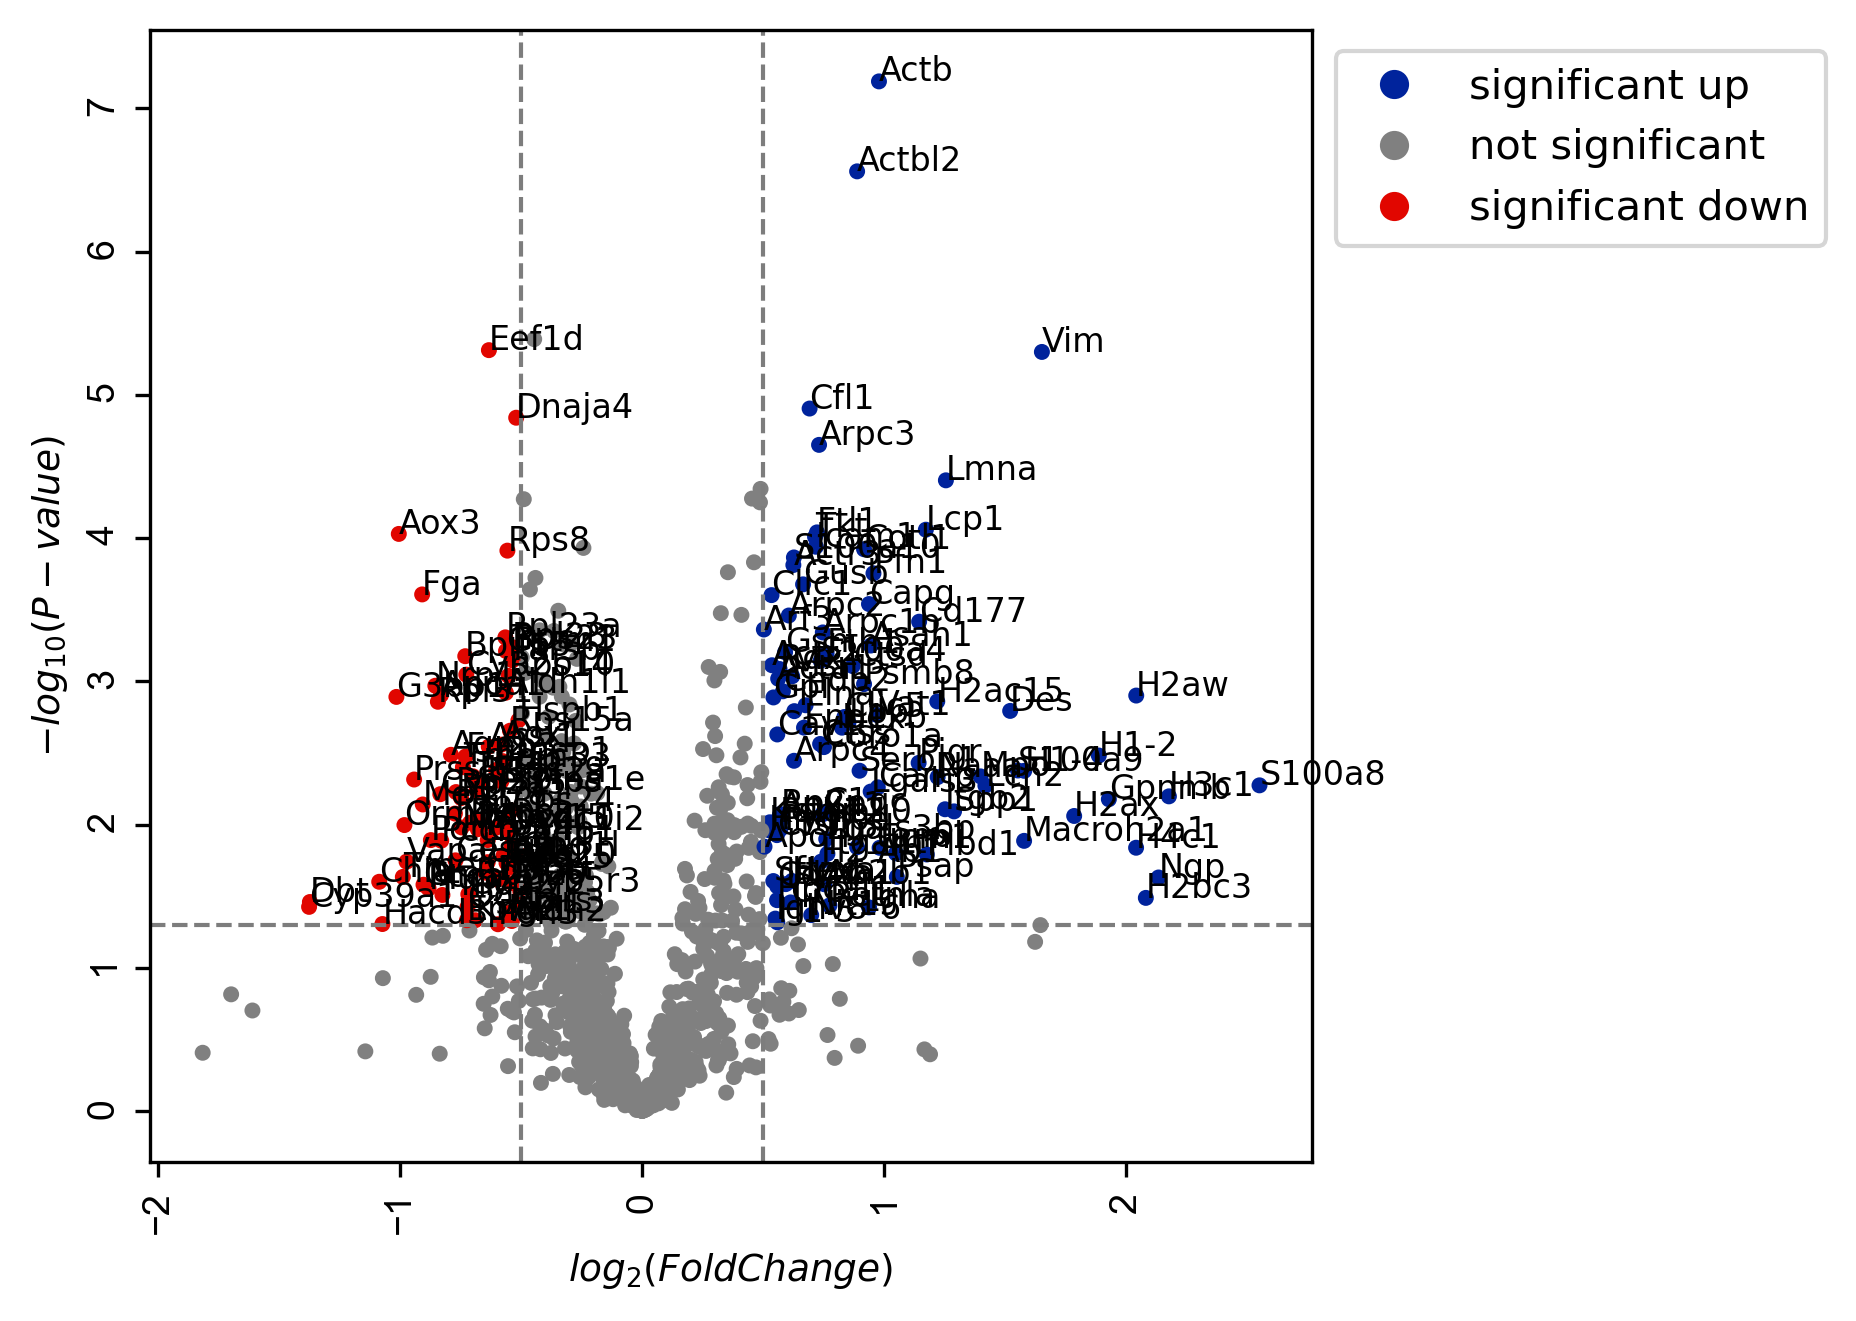

In [393]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp4Grp2a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

In [417]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp4')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp2')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

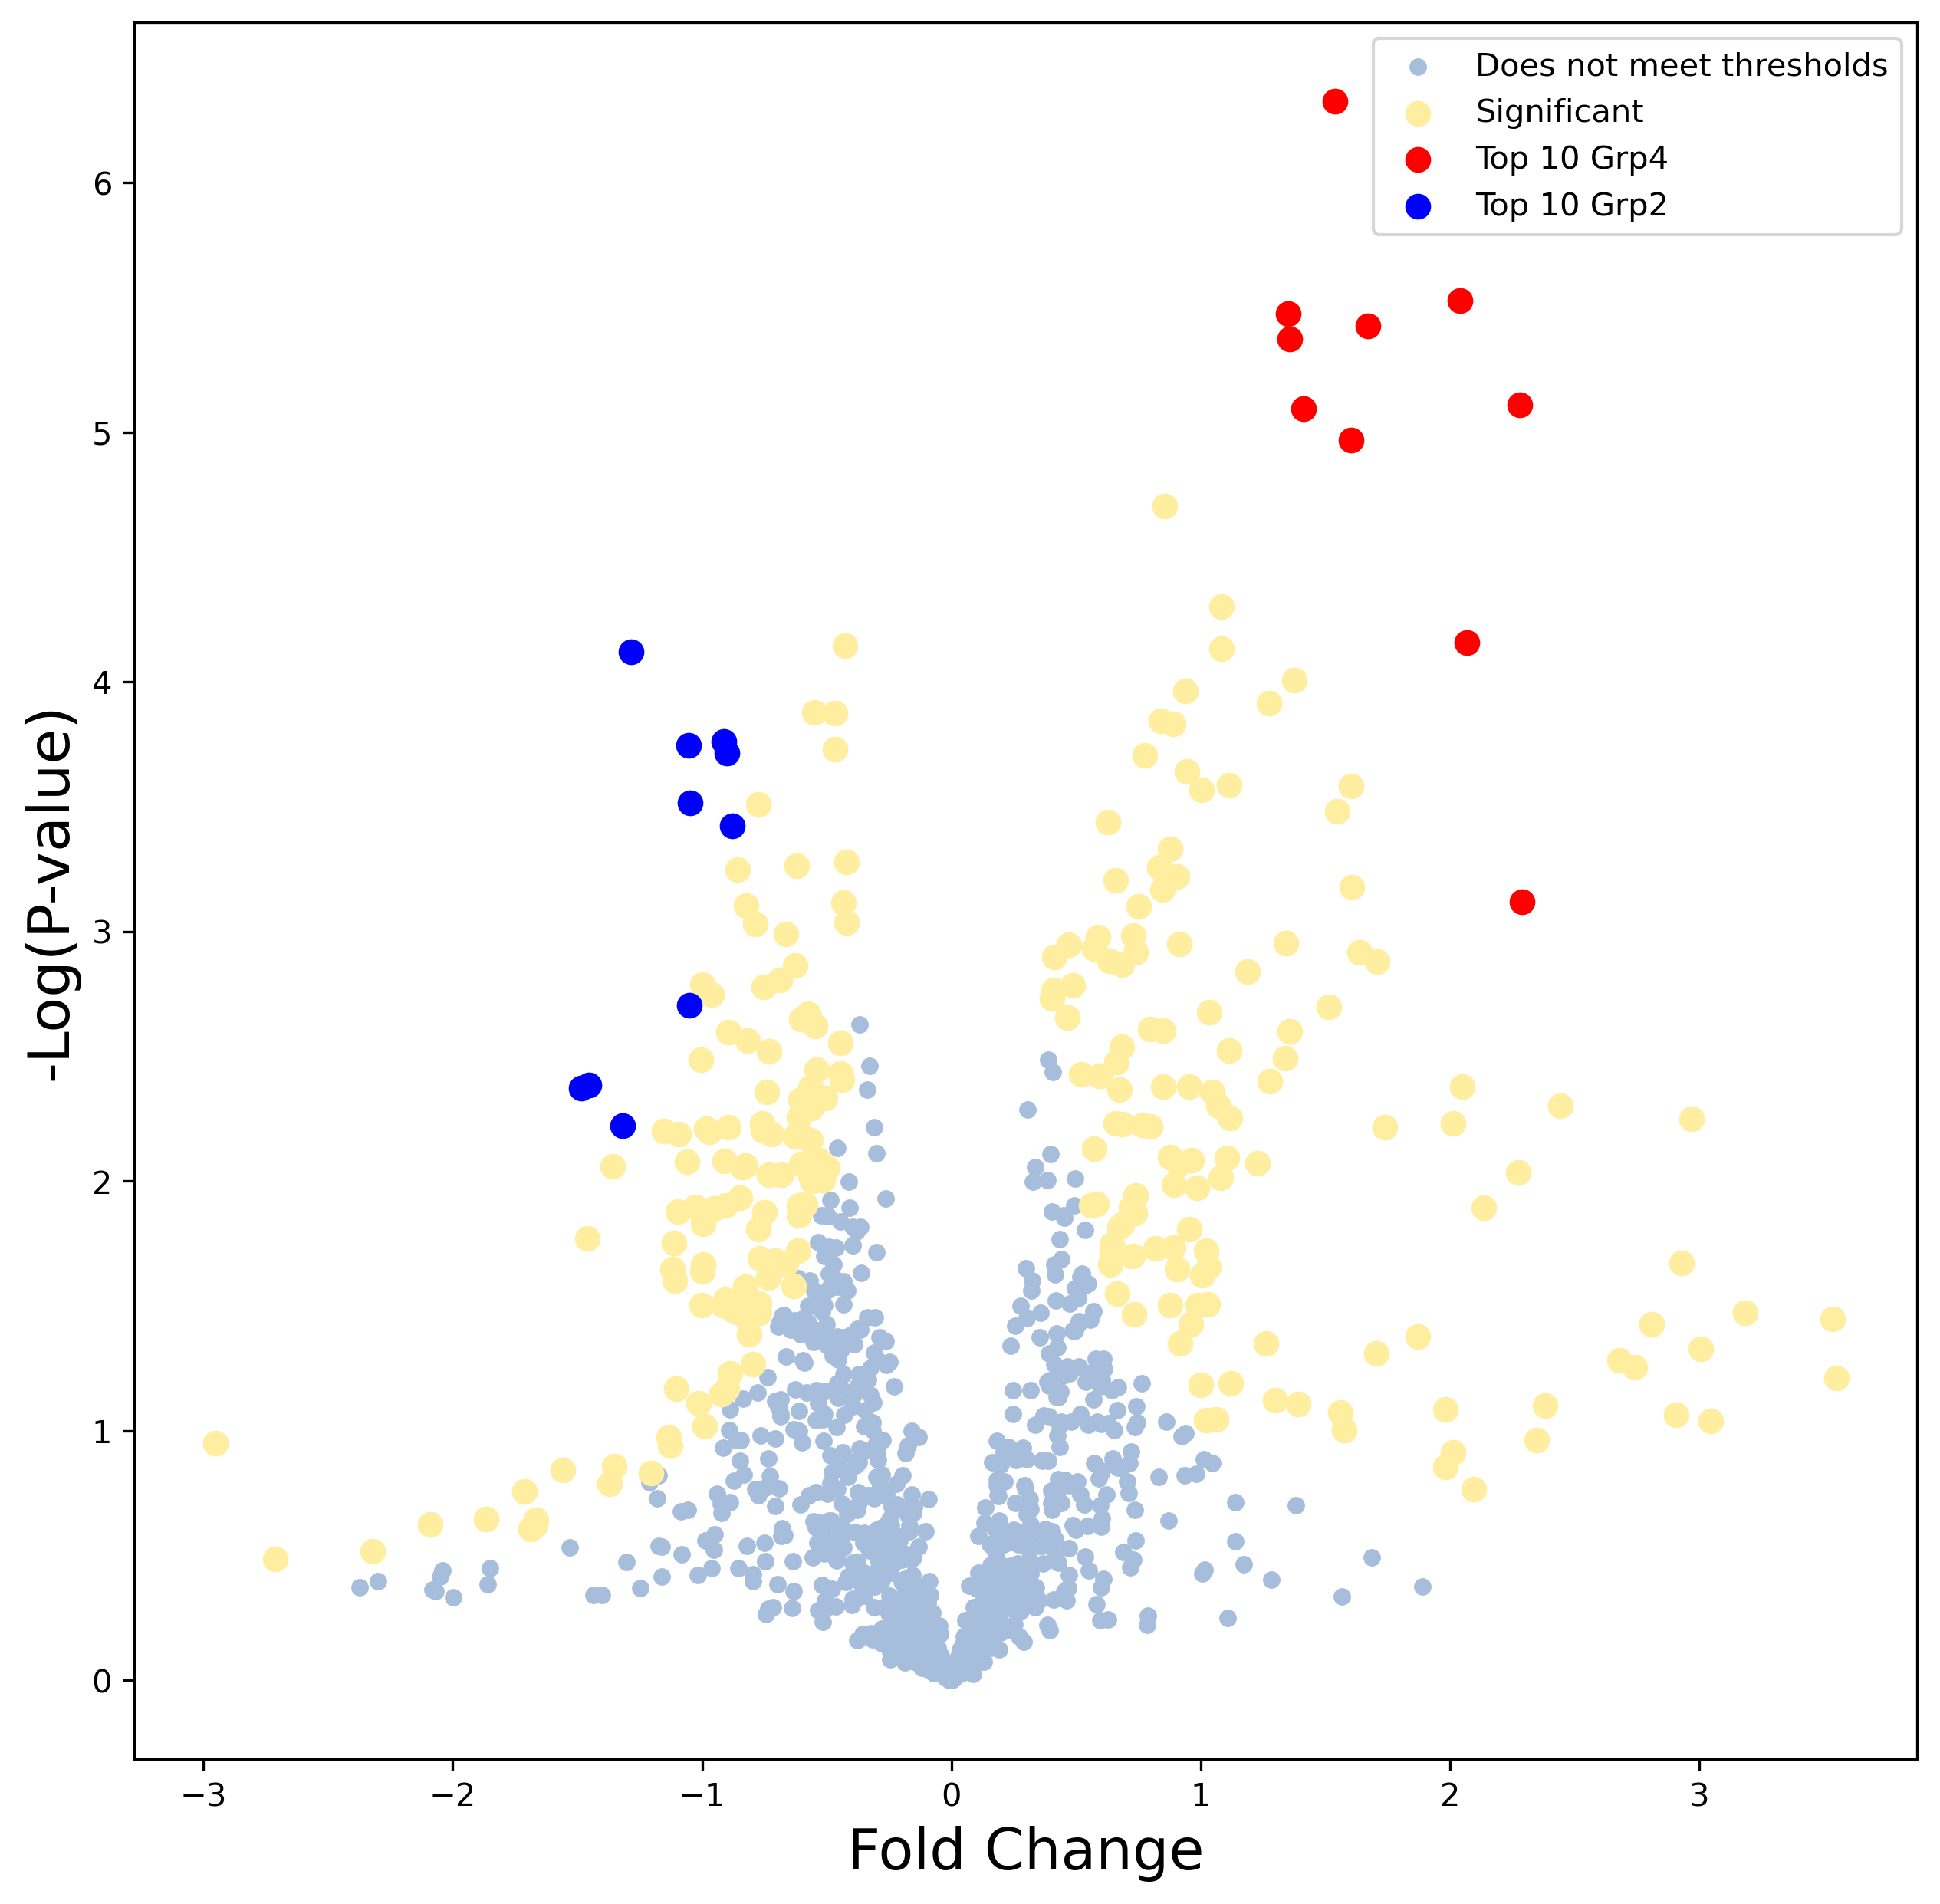

In [418]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

## Pathway analysis based upon biologically significant hits (pi score > 1)

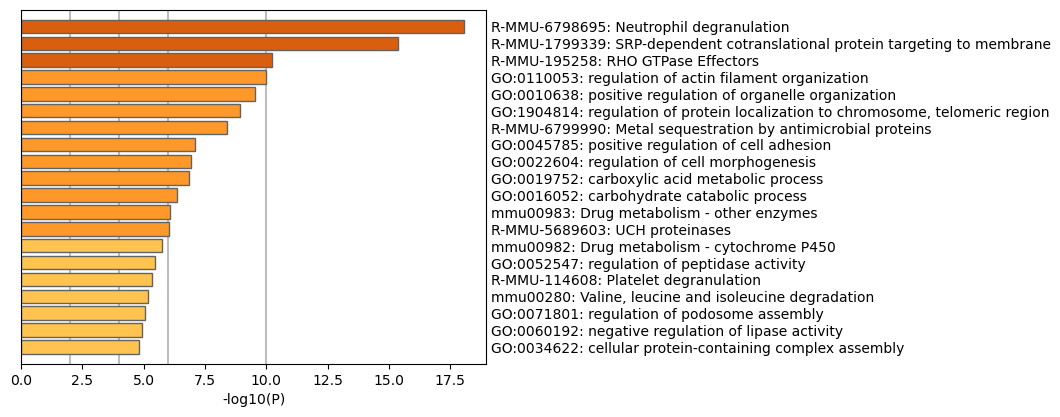

# Binary comparison Group 3 vs 1 

In [419]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_named.xlsx', index_col=0)
Normalized_df2.head()

Grp2      Grp2.1     Grp2.2        Grp4      Grp4.1  \
Master Protein                                                              
A0A075B5K0      156.846470  225.231942  86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104  56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672  60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621  67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN        NaN         NaN         NaN   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   

                ...      Grp3.5      Grp2.5     Grp2.6      Grp4.5     Grp4.6  \
Master Protein  ...                                                             
A0A075B5K0      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5K2      ...  135.639160   90.131332  77.371496   74.551864  95.123837   
A0A075B5K9      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L2      ...         NaN         NaN        NaN         NaN        NaN   
A0A075B5L7      ...  133.142607  119.017735  86.630495  150.284217  78.427115   

                    Grp3.6      Grp4.7      Grp2.7      Grp2.8     Grp1.5  
Master Protein                                                             
A0A075B5K0             NaN         NaN         NaN         NaN        NaN  
A0A075B5K2      355.595548  293.254940  152.743678   74.595525  43.025838  
A0A075B5K9             NaN         NaN         NaN         NaN        NaN  
A0A075B5L2             NaN         NaN         NaN         NaN        NaN  
A0A075B5L7      136.159220  170.375509  160.412703  100.762541  63.119272  

[5 rows x 30 columns]

In [420]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'./proteins.xlsx', index_col=0) 

#View dataframe
proteinlist

Proteins
Master Protein         
A8DUK4           Hbb-bs
P06728            Apoa4
Q91VB8           Hba-a1
P02088           Hbb-b1
P99027            Rplp2
...                 ...
E9Q0B5            Fcgbp
E9Q1Y3             Apob
E9Q6R7             Utrn
O88738            Birc6
Q7TMY8            Huwe1

[1603 rows x 1 columns]

In [421]:
Normalized_df2

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp3.5      Grp2.5      Grp2.6      Grp4.5  \
Master Protein  ...                                                   
A0A075B5K0      ...         NaN         NaN         NaN         NaN   
A0A075B5K2      ...  135.639160   90.131332   77.371496   74.551864   
A0A075B5K9      ...         NaN         NaN         NaN         NaN   
A0A075B5L2      ...         NaN         NaN         NaN         NaN   
A0A075B5L7      ...  133.142607  119.017735   86.630495  150.284217   
...             ...         ...         ...         ...         ...   
Q9Z2U0          ...  147.204784   87.614284   93.878723   96.985567   
Q9Z2U1          ...  152.856029   99.466552  115.581559  114.848648   
Q9Z2X1          ...         NaN         NaN         NaN         NaN   
S4R239          ...  205.968231  109.658089  145.289108  143.336170   
W4VSP4          ...  196.972559  116.497244  225.571851  193.654322   

                    Grp4.6      Grp3.6      Grp4.7      Grp2.7      Grp2.8  \
Master Protein                                                               
A0A075B5K0             NaN         NaN         NaN         NaN         NaN   
A0A075B5K2       95.123837  355.595548  293.254940  152.743678   74.595525   
A0A075B5K9             NaN         NaN         NaN         NaN         NaN   
A0A075B5L2             NaN         NaN         NaN         NaN         NaN   
A0A075B5L7       78.427115  136.159220  170.375509  160.412703  100.762541   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.396972  158.736218  158.268098  105.718405  100.082138   
Q9Z2U1           94.933539  157.148212  128.186256  126.854349  166.810877   
Q9Z2X1                 NaN         NaN         NaN         NaN         NaN   
S4R239           91.354641  139.003378  130.786686  147.875439  132.377861   
W4VSP4          125.514674   93.551027   87.660362   98.238438   85.188314   

                    Grp1.5  
Master Prot

In [422]:
Grp1 = ['Grp1', 'Grp1.1', 'Grp1.2', 'Grp1.3', 'Grp1.4', 'Grp1.5']
Grp3 = ['Grp3', 'Grp3.1', 'Grp3.2', 'Grp3.3', 'Grp3.4', 'Grp3.5', 'Grp3.6']

In [423]:
Grp1_df = Normalized_df2[Grp1]
Grp3_df = Normalized_df2[Grp3]

In [424]:
Grp3Grp1 = TwoCategoryMaster(Normalized_df2,Grp3_df,Grp1_df,"Grp3","Grp1")
Grp3Grp1

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN         NaN      0.105079   
A0A075B5K2      ...  152.743678   74.595525   43.025838      0.102573   
A0A075B5K9      ...         NaN         NaN         NaN      0.318641   
A0A075B5L2      ...         NaN         NaN         NaN      0.420021   
A0A075B5L7      ...  160.412703  100.762541   63.119272      0.051657   
...             ...         ...         ...         ...           ...   
Q9Z2U0          ...  105.718405  100.082138  115.292052      0.007776   
Q9Z2U1          ...  126.854349  166.810877  139.120068      0.069048   
Q9Z2X1          ...         NaN         NaN         NaN      0.402391   
S4R239          ...  147.875439  132.377861  125.328122      0.060280   
W4VSP4          ...   98.238438   85.188314   79.182735      0.289262   

                 Grp3 Mean   Grp1 Mean  Fold Change(Grp3/Grp1)  \
Master Protein                                                   
A0A075B5K0      125.502719   66.133258                1.897725   
A0A075B5K2      175.615041   91.604985                1.917090   
A0A075B5K9       93.589182   64.542712                1.450035   
A0A075B5L2      523.882970  141.597961                3.699792   
A0A075B5L7      128.575468   84.345278                1.524394   
...                    ...         ...                     ...   
Q9Z2U0          142.610852  108.286761                1.316974   
Q9Z2U1          148.554855  125.300303                1.185591   
Q9Z2X1          115.488730  154.872087                0.745704   
S4R239          141.655700  104.039564                1.361556   
W4VSP4          134.872765  105.811126                1.274656   

                Log2(Fold Change)  -Log(P-value)  Grp3/Grp1 pi score  
Master Protein                                                        
A0A075B5K0               0.9

In [425]:
#Annotate the file with protein names
Grp3Grp1a = pd.merge(Grp3Grp1, proteinlist, left_index=True, right_index=True)
Grp3Grp1a

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                               
A0A075B5K0      156.846470  225.231942   86.814293  155.317682   99.194721   
A0A075B5K2      123.366268   98.049104   56.173216   63.703080  215.624693   
A0A075B5K9       80.204102   66.584672   60.462323   60.140311   87.824975   
A0A075B5L2      423.375205  193.896621   67.461656   95.282834  122.570278   
A0A075B5L7             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2U0           95.763475   91.521455   95.205965  115.355420   98.887125   
Q9Z2U1          103.320808   97.442221  110.961522  122.557996  121.124421   
Q9Z2X1          221.374957  148.955528  162.871228  132.095902   91.403234   
S4R239          173.781436   95.701810  155.390375  144.831864  143.739121   
W4VSP4           94.044011   65.584907   92.688435  168.763348  163.713896   

                    Grp2.3         Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                                
A0A075B5K0       60.196299   159.153968   46.700098   68.510657   65.449736   
A0A075B5K2       73.297693   279.862419   68.704155  177.915272  109.340257   
A0A075B5K9       57.150867   125.391605   59.291894   45.265781   92.726687   
A0A075B5L2      188.671459  1282.210926  191.036230  244.807368  138.314959   
A0A075B5L7             NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
Q9Z2U0           87.353437   110.818535   92.737005  113.471934  112.775893   
Q9Z2U1          103.339252   141.271226  113.498894  141.110834  156.629045   
Q9Z2X1          128.689068   111.075881  124.634221  112.874726  229.385546   
S4R239          122.621058   133.976673  126.730012  117.049808   44.273458   
W4VSP4          111.374674    90.316628   95.364378   76.509363  181.656526   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp3 Mean  \
Master Protein  ...                                                     
A0A075B5K0      ...         NaN         NaN      0.105079  125.502719   
A0A075B5K2      ...   74.595525   43.025838      0.102573  175.615041   
A0A075B5K9      ...         NaN         NaN      0.318641   93.589182   
A0A075B5L2      ...         NaN         NaN      0.420021  523.882970   
A0A075B5L7      ...  100.762541   63.119272      0.051657  128.575468   
...             ...         ...         ...           ...         ...   
Q9Z2U0          ...  100.082138  115.292052      0.007776  142.610852   
Q9Z2U1          ...  166.810877  139.120068      0.069048  148.554855   
Q9Z2X1          ...         NaN         NaN      0.402391  115.488730   
S4R239          ...  132.377861  125.328122      0.060280  141.655700   
W4VSP4          ...   85.188314   79.182735      0.289262  134.872765   

                 Grp1 Mean  Fold Change(Grp3/Grp1)  Log2(Fold Change)  \
Master Protein                                                          
A0A075B5K0       66.133258                1.897725           0.924271   
A0A075B5K2       91.604985                1.917090           0.938918   
A0A075B5K9       64.542712                1.450035           0.536088   
A0A075B5L2      141.597961                3.699792           1.887444   
A0A075B5L7       84.345278                1.524394           0.608236   
...                    ...                     ...                ...   
Q9Z2U0          108.286761                1.316974           0.397227   
Q9Z2U1          125.300303                1.185591           0.245606   
Q9Z2X1          154.872087                0.745704          -0.423325   
S4R239          104.039564                1.361556           0.445256   
W4VSP4          105.811126                1.274656           0.350108   

                -Log(P-value)  Grp3/Grp1 pi score    Proteins  
Master Protein 

In [426]:
top10 = Normalized_df2['Grp3/Grp1 pi score'].nlargest(10)
low10 = Normalized_df2['Grp3/Grp1 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp3/Grp1 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp3/Grp1 pi score'].isin(low10)]

In [427]:
top10

Master Protein
K3W4L3        11.655614
P20152        11.266318
P48678         9.734347
P51437         9.059608
O70570         8.598447
Q9WV54         7.958760
Q61805         7.392076
P18242         7.292610
P20060         7.185635
A0A0A6YXW6     7.130826
Name: Grp3/Grp1 pi score, dtype: float64

In [428]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

Grp3/Grp1 pi score Proteins
Master Protein                             
K3W4L3                   11.655614     Psap
P20152                   11.266318      Vim
P48678                    9.734347     Lmna
P51437                    9.059608     Camp
O70570                    8.598447     Pigr
Q9WV54                    7.958760    Asah1
Q61805                    7.392076      Lbp
P18242                    7.292610     Ctsd
P20060                    7.185635     Hexb
A0A0A6YXW6                7.130826     Igha

In [429]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp3/Grp1 pi score']) > (1))]

In [430]:
df_sign

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                                
A0A075B5M4              NaN         NaN         NaN         NaN         NaN   
A0A075B5M7       139.297789   61.416313   98.819612   51.397515   73.918719   
A0A075B5N3       317.667826  114.634174   78.268822   94.171901   75.245818   
A0A075B5N4      1461.940504   42.371130  156.951608   53.549850   59.626580   
A0A075B5N7       141.287476  141.742250   63.575324   76.911022  112.840506   
...                     ...         ...         ...         ...         ...   
Q9WUM3           139.177115  161.922842  132.946108  131.902848  110.023695   
Q9WV32            82.113340   86.147434   76.427621  130.719305  117.028548   
Q9WV54           103.678051   83.585083   72.772403  222.910199  154.987431   
Q9Z0K8           131.818442  374.071327   75.706970  104.811117  131.096906   
Q9Z1Q5           143.824256   97.958925  116.193118  165.648406  150.646555   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A075B5M4             NaN         NaN         NaN         NaN         NaN   
A0A075B5M7       73.075985  247.397569   47.965474   78.812297  124.084596   
A0A075B5N3      170.952308  152.656321   72.436329  121.807195   61.123687   
A0A075B5N4       11.709551  634.216827   20.967391   70.853338   69.048912   
A0A075B5N7       97.879156  280.196299   79.405624   77.259182   89.960353   
...                    ...         ...         ...         ...         ...   
Q9WUM3          188.737073   90.433260  167.855975  154.098418  249.810189   
Q9WV32           71.400010  149.220751   80.464892   85.868859  111.656059   
Q9WV54           73.580927  148.671973   84.605262   82.342044   36.786352   
Q9Z0K8           82.188389  123.237234   73.385869   81.787916   49.651524   
Q9Z1Q5          101.338736  132.238149   92.709261  108.905956   81.426558   

                ...      Grp2.7      Grp2.8      Grp1.5  ttest_pvalue  \
Master Protein  ...                                                     
A0A075B5M4      ...  141.412428  123.275015   58.400271      0.065488   
A0A075B5M7      ...  141.425800  150.831145  153.768882      0.037432   
A0A075B5N3      ...  163.553678   99.941049   93.323470      0.003783   
A0A075B5N4      ...   40.871605   21.967920   17.520969      0.171250   
A0A075B5N7      ...  137.062648  164.437155   72.292831      0.019029   
...             ...         ...         ...         ...           ...   
Q9WUM3          ...  105.578783  136.385853  133.153967      0.011680   
Q9WV32          ...   80.789571   88.194394   75.067294      0.006054   
Q9WV54          ...  107.257034   81.028876   75.496773      0.000011   
Q9Z0K8          ...   65.665731   51.427913   54.229037      0.002006   
Q9Z1Q5          ...   78.627072   78.806747   72.752244      0.000147   

                 Grp3 Mean   Grp1 Mean  Fold Change(Grp3/Grp1)  \
Master Protein                                                   
A0A075B5M4      167.894621   83.908917                2.000915   
A0A075B5M7      180.284575   92.619304                1.946512   
A0A075B5N3      143.809022   95.302829                1.508969   
A0A075B5N4      168.737406   39.488458                4.273082   
A0A075B5N7      172.181332   84.757957                2.031447   
...                    ...         ...                     ...   
Q9WUM3          102.689737  184.789863                0.555711   
Q9WV32          155.286927   89.416024                1.736679   
Q9WV54          197.995923   65.219097                3.035858   
Q9Z0K8          165.755239   58.050302                2.855373   
Q9Z1Q5          167.033740   90.122127                1.853415   

                Log2(Fold Change)  -Log(P-value)  Grp3/Grp1 pi score  
Master Protein                                                        
A0A075B5M4               1.00

In [431]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

Grp2      Grp2.1      Grp2.2        Grp4      Grp4.1  \
Master Protein                                                                
A0A075B5M4              NaN         NaN         NaN         NaN         NaN   
A0A075B5M7       139.297789   61.416313   98.819612   51.397515   73.918719   
A0A075B5N3       317.667826  114.634174   78.268822   94.171901   75.245818   
A0A075B5N4      1461.940504   42.371130  156.951608   53.549850   59.626580   
A0A075B5N7       141.287476  141.742250   63.575324   76.911022  112.840506   
...                     ...         ...         ...         ...         ...   
Q9WUM3           139.177115  161.922842  132.946108  131.902848  110.023695   
Q9WV32            82.113340   86.147434   76.427621  130.719305  117.028548   
Q9WV54           103.678051   83.585083   72.772403  222.910199  154.987431   
Q9Z0K8           131.818442  374.071327   75.706970  104.811117  131.096906   
Q9Z1Q5           143.824256   97.958925  116.193118  165.648406  150.646555   

                    Grp2.3        Grp3      Grp2.4        Grp1      Grp1.1  \
Master Protein                                                               
A0A075B5M4             NaN         NaN         NaN         NaN         NaN   
A0A075B5M7       73.075985  247.397569   47.965474   78.812297  124.084596   
A0A075B5N3      170.952308  152.656321   72.436329  121.807195   61.123687   
A0A075B5N4       11.709551  634.216827   20.967391   70.853338   69.048912   
A0A075B5N7       97.879156  280.196299   79.405624   77.259182   89.960353   
...                    ...         ...         ...         ...         ...   
Q9WUM3          188.737073   90.433260  167.855975  154.098418  249.810189   
Q9WV32           71.400010  149.220751   80.464892   85.868859  111.656059   
Q9WV54           73.580927  148.671973   84.605262   82.342044   36.786352   
Q9Z0K8           82.188389  123.237234   73.385869   81.787916   49.651524   
Q9Z1Q5          101.338736  132.238149   92.709261  108.905956   81.426558   

                ...      Grp2.8      Grp1.5  ttest_pvalue   Grp3 Mean  \
Master Protein  ...                                                     
A0A075B5M4      ...  123.275015   58.400271      0.065488  167.894621   
A0A075B5M7      ...  150.831145  153.768882      0.037432  180.284575   
A0A075B5N3      ...   99.941049   93.323470      0.003783  143.809022   
A0A075B5N4      ...   21.967920   17.520969      0.171250  168.737406   
A0A075B5N7      ...  164.437155   72.292831      0.019029  172.181332   
...             ...         ...         ...           ...         ...   
Q9WUM3          ...  136.385853  133.153967      0.011680  102.689737   
Q9WV32          ...   88.194394   75.067294      0.006054  155.286927   
Q9WV54          ...   81.028876   75.496773      0.000011  197.995923   
Q9Z0K8          ...   51.427913   54.229037      0.002006  165.755239   
Q9Z1Q5          ...   78.806747   72.752244      0.000147  167.033740   

                 Grp1 Mean  Fold Change(Grp3/Grp1)  Log2(Fold Change)  \
Master Protein                                                          
A0A075B5M4       83.908917                2.000915           1.000660   
A0A075B5M7       92.619304                1.946512           0.960891   
A0A075B5N3       95.302829                1.508969           0.593563   
A0A075B5N4       39.488458                4.273082           2.095277   
A0A075B5N7       84.757957                2.031447           1.022508   
...                    ...                     ...                ...   
Q9WUM3          184.789863                0.555711          -0.847594   
Q9WV32           89.416024                1.736679           0.796331   
Q9WV54           65.219097                3.035858           1.602104   
Q9Z0K8           58.050302                2.855373           1.513679   
Q9Z1Q5           90.122127                1.853415           0.890186   

                -Log(P-value)  Grp3/Grp1 pi score    Proteins  
Master Protein  

In [432]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp31pi.csv')

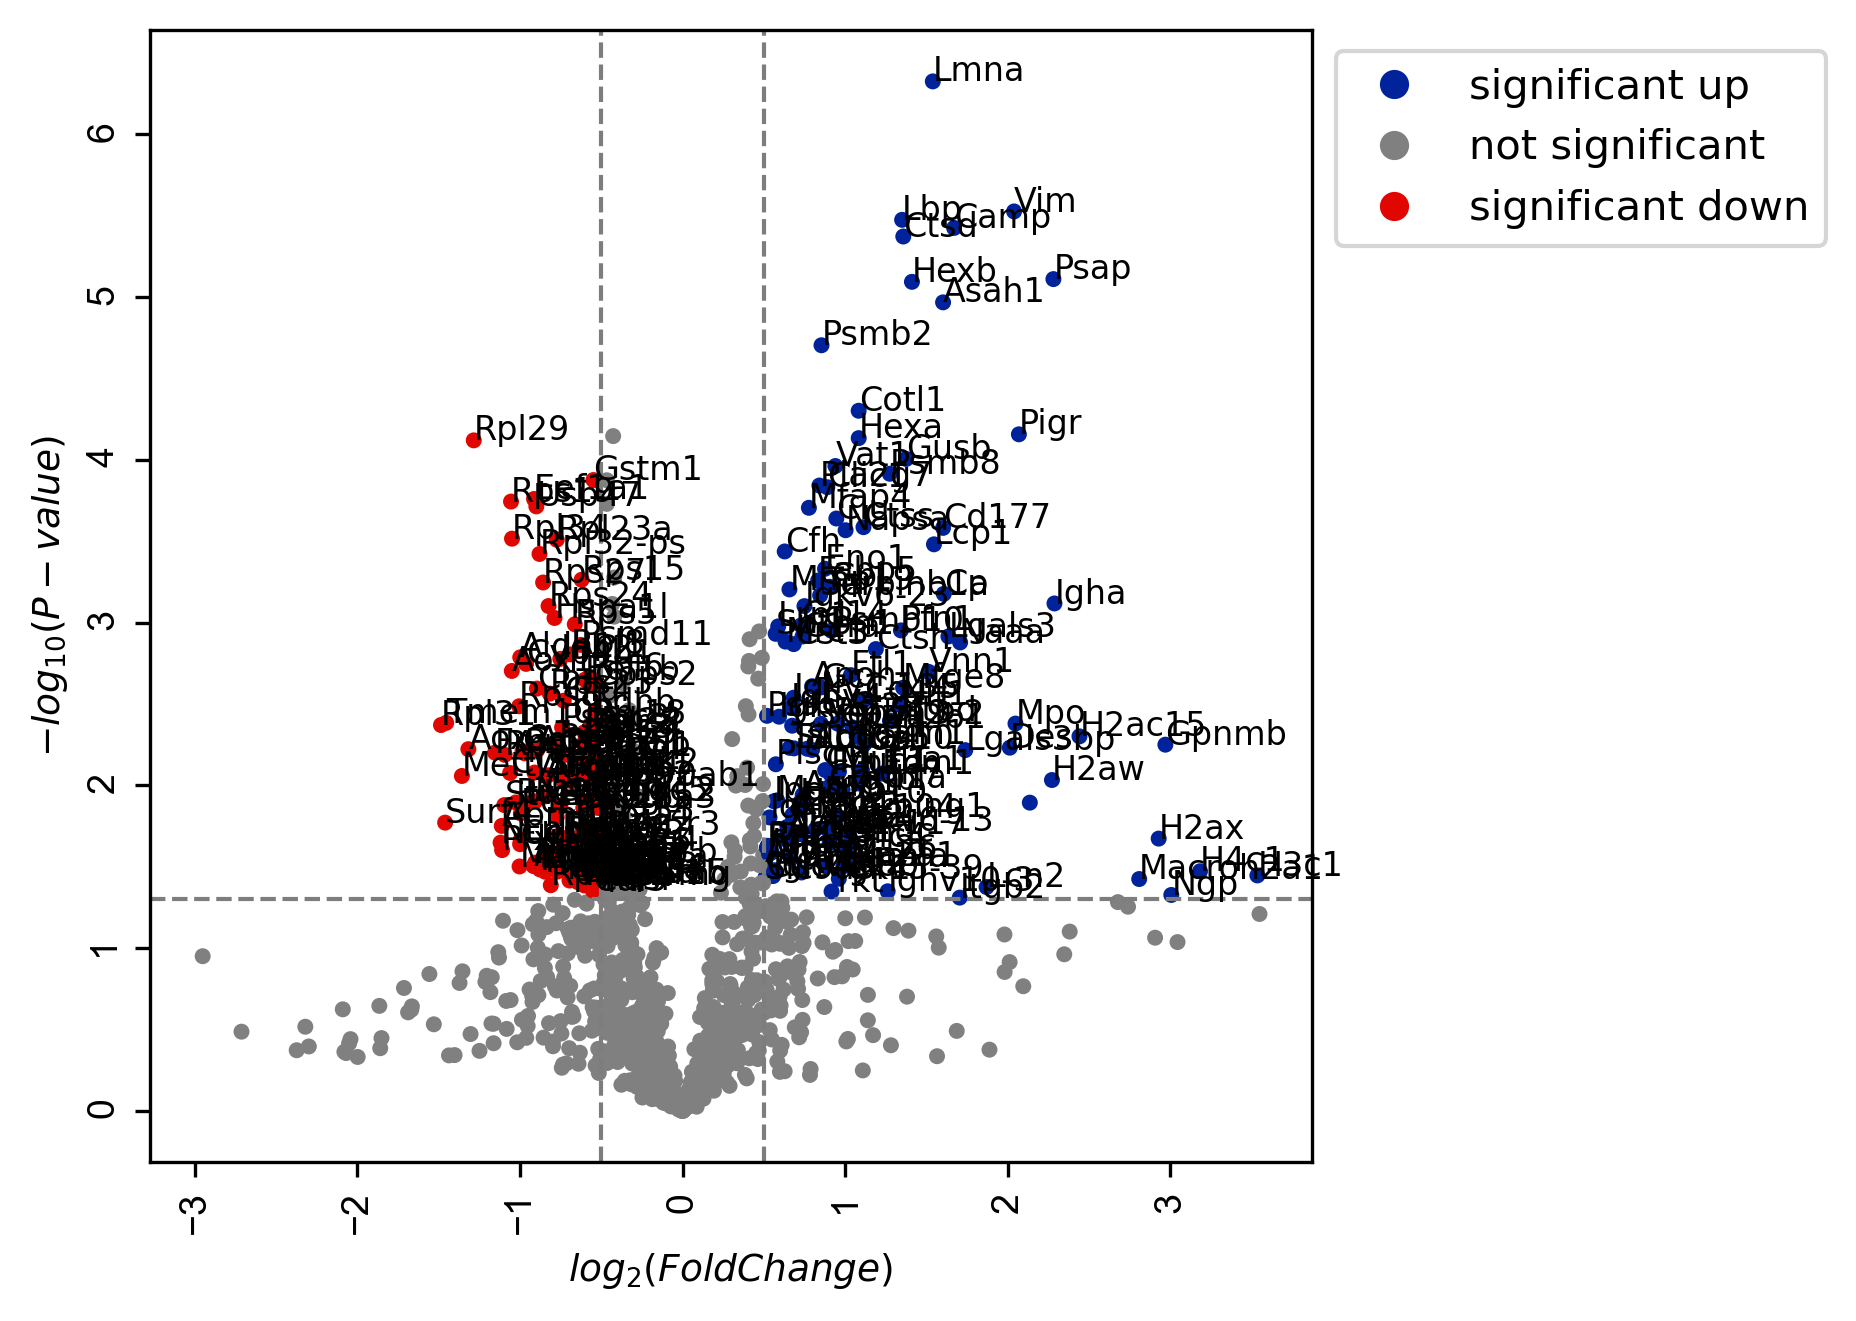

In [433]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp3Grp1a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

In [434]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp3')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

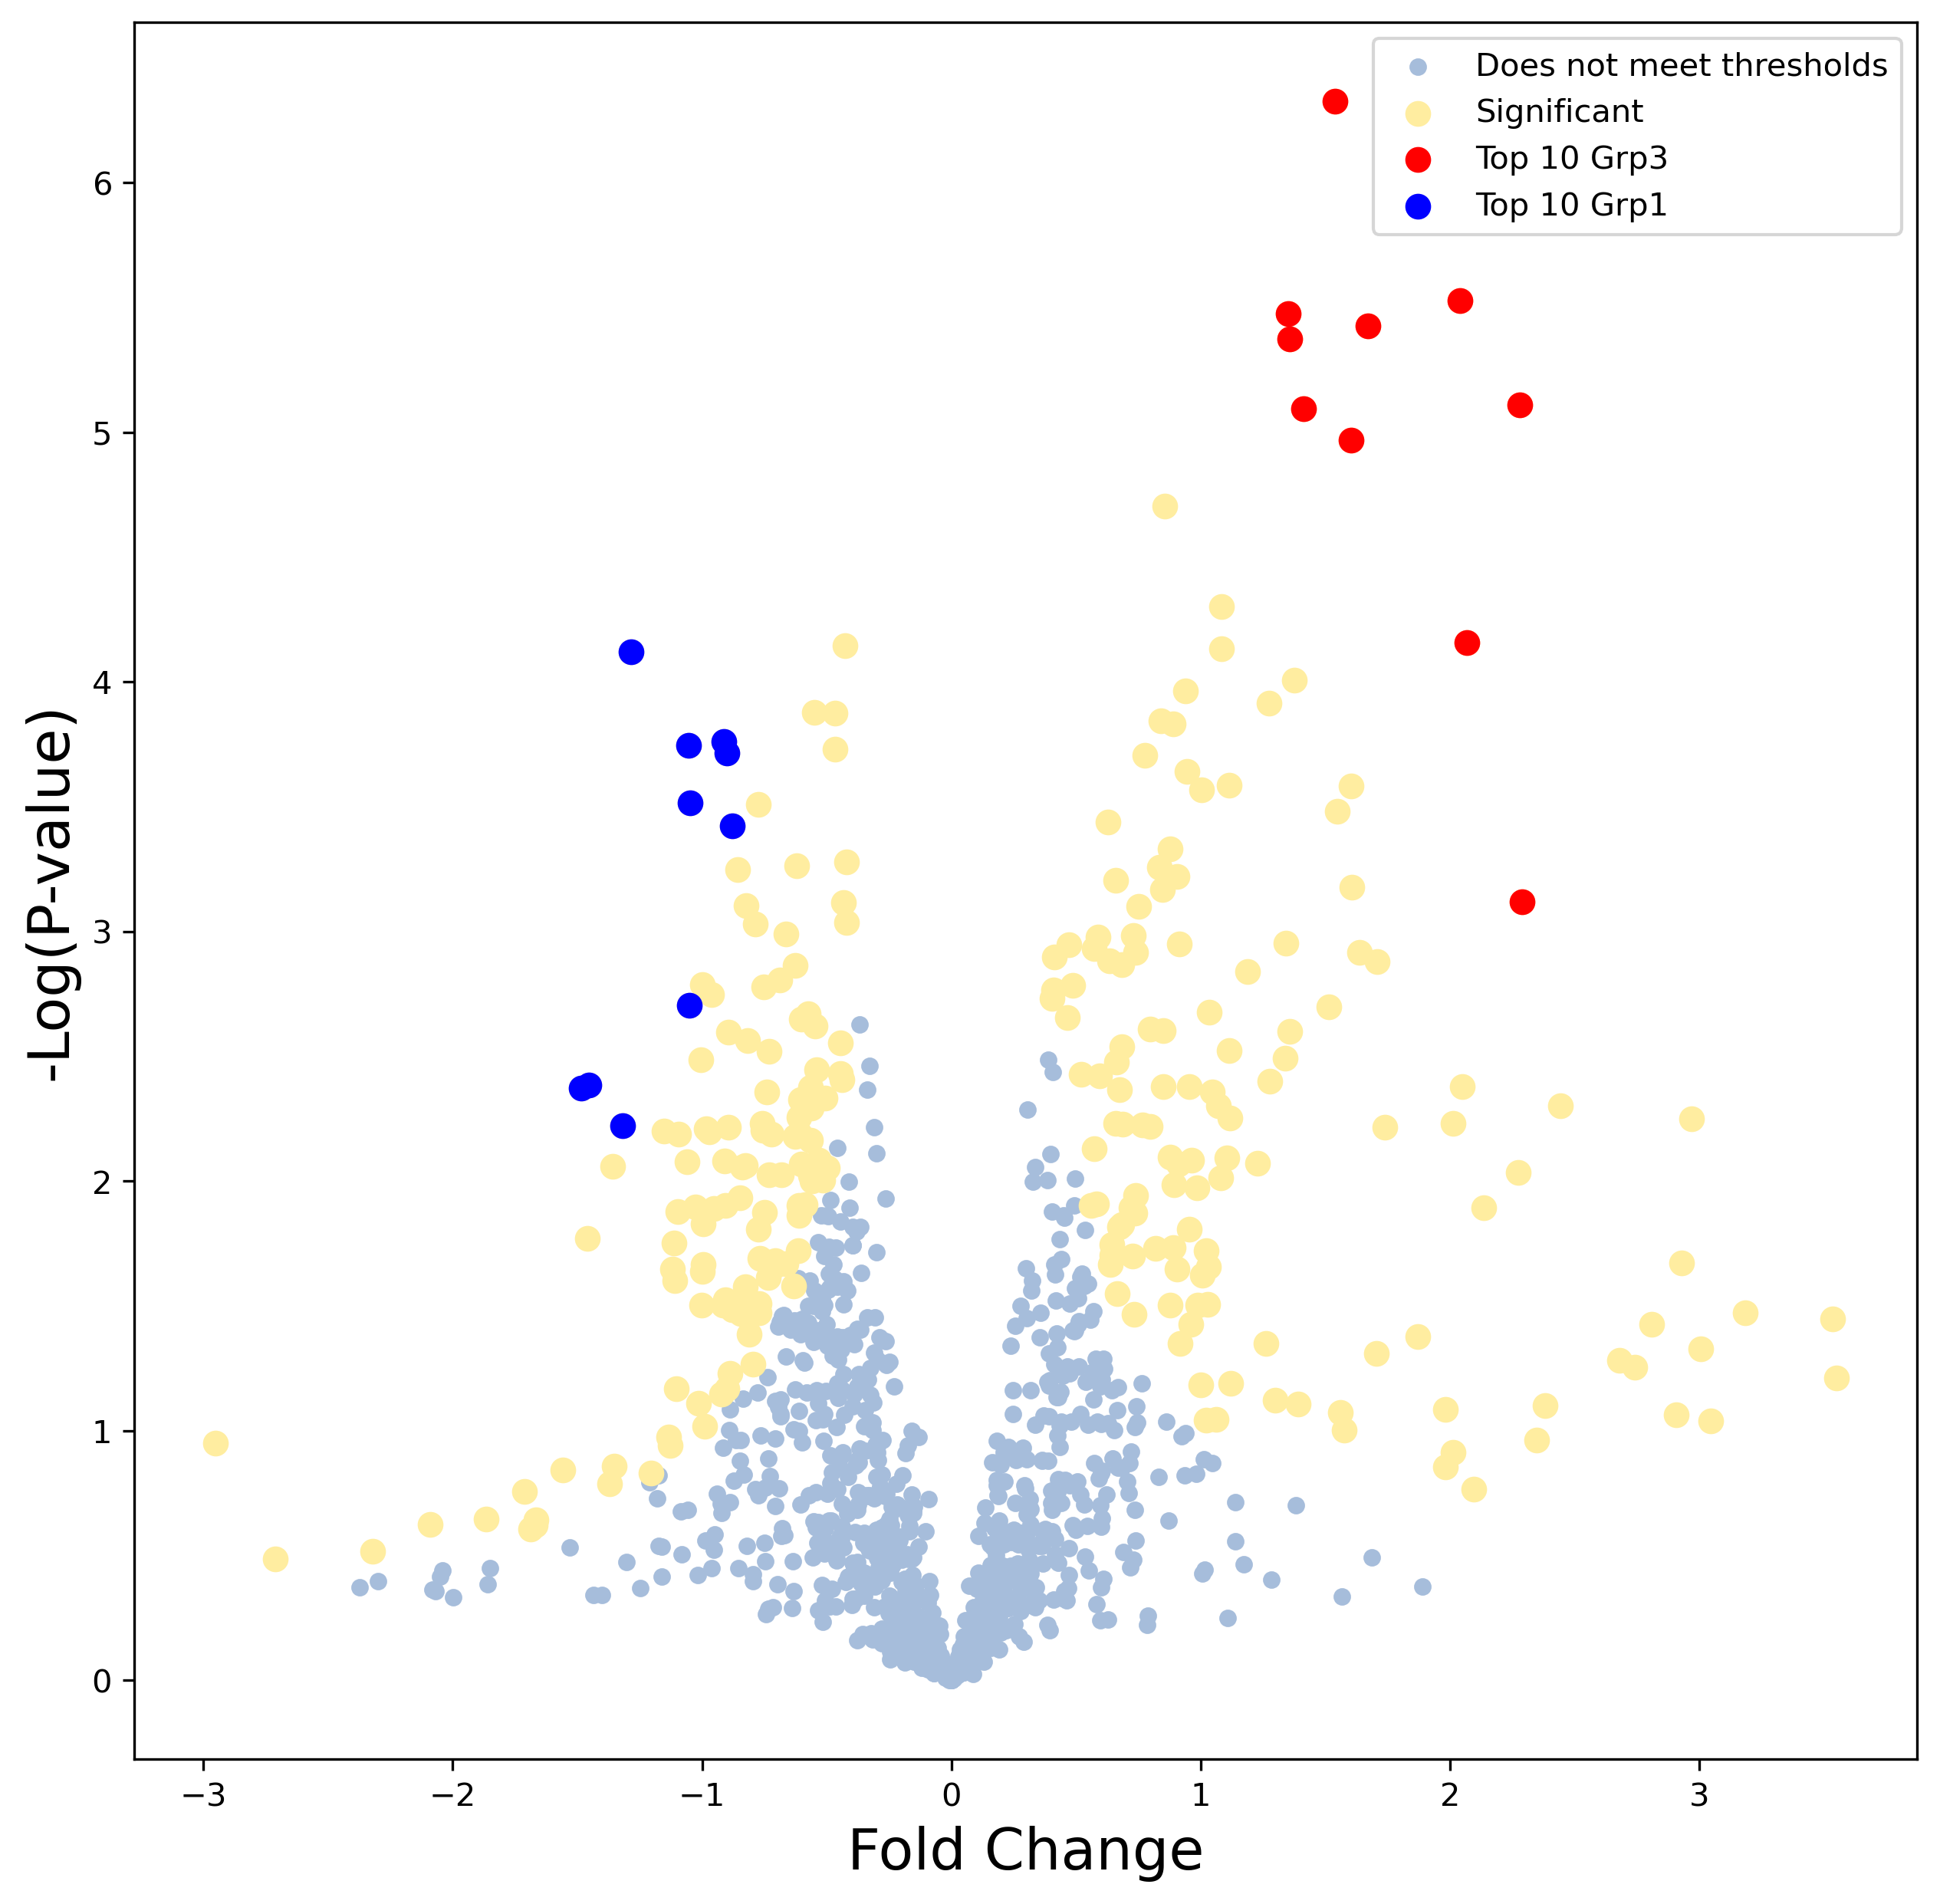

In [435]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

# Pathway analysis based upon biologically significant hits (pi score > 1)

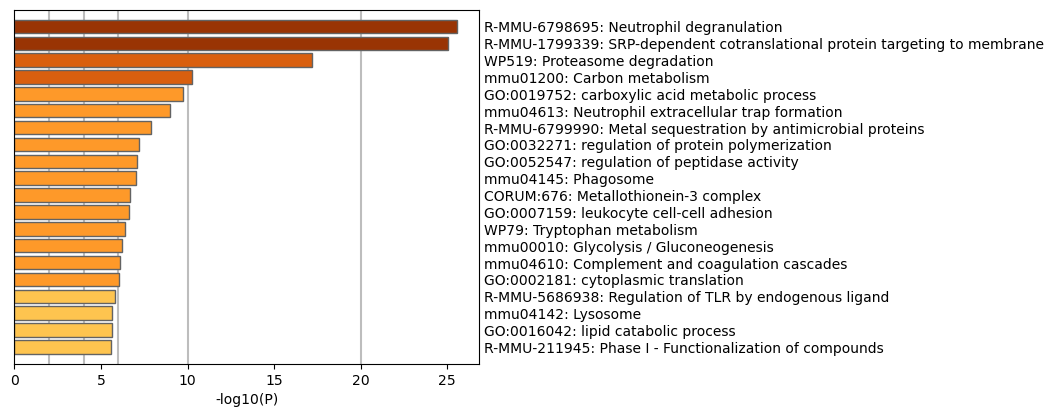